In [ ]:
from notebooks import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The potoo.default_magic_magic extension is already loaded. To reload it, use:
  %reload_ext potoo.default_magic_magic


In [ ]:
# Load models
load = Load()
projection = Projection.load('peterson-v0-26bae1c', features=Features(load=load))

[23:31:41.694] DEBUG  Projection.load
  path: /Users/danb/hack/bubo/features/data/models/projection/peterson-v0-26bae1c.pkl


In [ ]:
# Select recs
#   1. countries: Filter recs to these countries
#   2. com_names: Filter recs to these species
#   3. recs_at_least: Filter species to those with at least this many recs
#   4. num_species: Sample this many of the species
#   5. num_recs: Sample this many recs per species
puts_stats = lambda desc: partial(tap, f=lambda df: print('%-15s %12s (recs/sp)' % (desc, '%s/%s' % (len(df), df.species.nunique()))))
countries, com_names = countries_na, com_names_ca  # 400k/9.4k -> 60k/1.1k -> 35k/334
# recs_at_least, num_species, num_recs = 100, 100, 100  # ca[35k/334 -> 25k/127 -> 21k/100 ->  10k/100 ->  10k/100]
# recs_at_least, num_species, num_recs =  50, 100, 100  # ca[35k/334 -> 32k/224 -> 16k/100 -> 9.0k/100 -> 9.0k/100]
# recs_at_least, num_species, num_recs =   0, 100, 100  # ca[35k/334 -> 35k/334 -> 12k/100 -> 6.8k/100 -> 6.8k/ 99]
# recs_at_least, num_species, num_recs =   0, 168, 100  # ca[34k/334 -> 34k/334 -> 18k/168 ->  11k/168 ->  11k/167]  # compare.ipynb all
recs_at_least, num_species, num_recs =   0, 168,  20  # ca[34k/334 -> 35k/334 -> 18k/168 ->  3.2/168 ->  3.2/167]  # compare.ipynb recs
xcs = (xc.metadata
    .pipe(puts_stats('all'))
    # 1. countries: Filter recs to these countries
    [lambda df: df.country.isin(countries)]
    .pipe(puts_stats('countries'))
    # 2. com_names: Filter recs to these species
    [lambda df: df.com_name.isin(com_names)]
    .pipe(puts_stats('com_names'))
    # Omit not-downloaded recs (should be few within the selected countries)
    [lambda df: df.downloaded]
    .pipe(puts_stats('(downloaded)'))
    # Remove empty cats for perf
    .pipe(df_remove_unused_categories)
    # 3. recs_at_least: Filter species to those with at least this many recs
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= recs_at_least].index)]
    .pipe(puts_stats('recs_at_least'))
    # 4. num_species: Sample this many of the species
    [lambda df: df.species.isin(df.species.drop_duplicates().pipe(lambda s: s.sample(n=min(len(s), num_species), random_state=0)))]
    .pipe(puts_stats('num_species'))
    # 5. num_recs: Sample this many recs per species
    #   - Remove empty cats else .groupby fails on empty groups
    .pipe(df_remove_unused_categories)
    .groupby('species').apply(lambda g: g.sample(n=min(len(g), num_recs), random_state=0))
    .pipe(puts_stats('num_recs'))
    # Drop species with <2 recs, else StratifiedShuffleSplit complains (e.g. 'TUVU')
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= 2].index)]
    .pipe(puts_stats('recs ≥ 2'))
    # Clean up for downstream
    .pipe(df_remove_unused_categories)
)
display(
    df_summary(xcs).T,
    xcs.sample(n=10, random_state=0).sort_values('species'),
)

all              399859/9442 (recs/sp)
countries         59713/1148 (recs/sp)
com_names          35236/334 (recs/sp)
(downloaded)       35232/334 (recs/sp)
recs_at_least      35232/334 (recs/sp)
num_species        18189/168 (recs/sp)


num_recs            3194/168 (recs/sp)
recs ≥ 2            3193/167 (recs/sp)


,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
downloaded,bool,89404,3193,3193,1,NaN,NaN,True,True,True,True,True
species,category,169239,3193,3193,167,NaN,NaN,GWFG,GWGU,TRKI,PHAI,PTWH
id,int64,89404,3193,3193,3193,213958.140,106654.207,1137,139451,197297,304800,416741
sci_name,category,214049,3193,3193,167,NaN,NaN,Anser albifrons,Larus glaucescens,Tyrannus melancholicus,Phainopepla nitens,Vidua macroura
com_name,category,207988,3193,3193,167,NaN,NaN,Greater White-fronted Goose,Glaucous-winged Gull,Tropical Kingbird,Phainopepla,Pin-tailed Whydah
subspecies,object,161278,3193,3193,197,NaN,NaN,,,,,zaboria
recordist,object,201415,3193,3193,279,NaN,NaN,Aaron Boone,Frank Lambert,Mike Nelson,Phil Ranson,patrice adret
country,object,193213,3193,3193,3,NaN,NaN,Canada,United States,United States,United States,United States
locality,object,301762,3193,3193,1621,NaN,NaN,"Bahía la Ventosa, Salina Cruz, Oaxaca","Derby Creek, Council Road, Nome Census Area, Alaska","Merced Grove, near Crane Flat, Yosemite NP, California","Saint-Hilarion, Charlevoix, Québec","western Apalachicola National Forest, Florida"


,,downloaded,species,id,sci_name,com_name,subspecies,recordist,country,locality,lat,lng,type,quality,date,time,license_type,license_detail,license,url,download
species,,,,,,,,,,,,,,,,,,,,,
WFIB,63798,True,WFIB,352723,Plegadis chihi,White-faced Ibis,,Frank Lambert,Mexico,"Laguna Zapotlán, Jalisco",19.8,-103.0,flight call,C,2015-04-07 00:00:00,08:53,by-nc-nd,4.0,//creativecommons.org/licenses/by-nc-nd/4.0/,https://www.xeno-canto.org/352723,//www.xeno-canto.org/352723/download
AMAV,270065,True,AMAV,139921,Recurvirostra americana,American Avocet,,GABRIEL LEITE,United States,"University of Wyoming (near Laramie), Albany, Wyoming",41.3,-106.0,call,C,2013-05-07 00:00:00,11:00,by-nc-sa,3.0,//creativecommons.org/licenses/by-nc-sa/3.0/,https://www.xeno-canto.org/139921,//www.xeno-canto.org/139921/download
BLOY,374555,True,BLOY,28274,Haematopus bachmani,Black Oystercatcher,,Andrew Spencer,United States,"West Cliff Drive, Santa Cruz, Santa Cruz Co., California",37.0,-122.0,call,B,2009-01-12 00:00:00,14:00,by-nc-nd,2.5,//creativecommons.org/licenses/by-nc-nd/2.5/,https://www.xeno-canto.org/28274,//www.xeno-canto.org/28274/download
SEPL,260709,True,SEPL,149624,Charadrius semipalmatus,Semipalmated Plover,,Paul Marvin,United States,"Biolab Road, Canaveral National Seashore, Brevard County, Florida",28.7,-80.7,call,A,2013-09-15 00:00:00,07:38,by-nc-sa,3.0,//creativecommons.org/licenses/by-nc-sa/3.0/,https://www.xeno-canto.org/149624,//www.xeno-canto.org/149624/download
RNPH,208621,True,RNPH,203600,Phalaropus lobatus,Red-necked Phalarope,,Andrew Spencer,United States,"Dalton Highway, Pump Station 4 access road, North Slope Borough, Alaska",68.4,-149.0,call,A,2014-07-01 00:00:00,09:45,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/203600,//www.xeno-canto.org/203600/download
MODO,246559,True,MODO,164123,Zenaida macroura,Mourning Dove,,Patrick Turgeon,Canada,"Foam Lake No. 276 (near Leslie), Division No. 10, Saskatchewan",51.8,-104.0,song,B,2013-07-09 00:00:00,06:02,by-nc-sa,3.0,//creativecommons.org/licenses/by-nc-sa/3.0/,https://www.xeno-canto.org/164123,//www.xeno-canto.org/164123/download
LCPA,63318,True,LCPA,353205,Amazona finschi,Lilac-crowned Amazon,,Richard E. Webster,Mexico,"Arroyo La Aduana, Álamos, Sonora",27.0,-109.0,call,B,2016-03-20 00:00:00,10:41,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/353205,//www.xeno-canto.org/353205/download
BTMJ,16529,True,BTMJ,400960,Calocitta colliei,Black-throated Magpie-Jay,,Richard E. Webster,Mexico,"Minas Nuevas, Álamos, Sonora",27.1,-109.0,call,A,2014-12-22 00:00:00,10:27,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/400960,//www.xeno-canto.org/400960/download
SATH,389358,True,SATH,12118,Oreoscoptes montanus,Sage Thrasher,,Nathan Pieplow,United States,"Mack, Mesa County, Colorado",39.2,-109.0,song,A,2007-04-07 00:00:00,11:30,by-nc-nd,2.5,//creativecommons.org/licenses/by-nc-nd/2.5/,https://www.xeno-canto.org/12118,//www.xeno-canto.org/12118/download


In [ ]:
xcs_paths = [
    ('xc', f'{data_dir}/xc/data/{row.species}/{row.id}/audio.mp3')
    for row in df_rows(xcs)
]
joblib.dump(xcs_paths, '/tmp/xcs_paths')  # In case you want to run load.recs in a terminal (it's long and verbose)
display(
    len(xcs_paths),
    xcs_paths[:10],
)

3193

[
  ('xc', '/Users/danb/hack/bubo/features/data/xc/data/GWFG/149379/audio.mp3'),
  ('xc', '/Users/danb/hack/bubo/features/data/xc/data/GWFG/160186/audio.mp3'),
  ('xc', '/Users/danb/hack/bubo/features/data/xc/data/GWFG/276916/audio.mp3'),
  ('xc', '/Users/danb/hack/bubo/features/data/xc/data/GWFG/149380/audio.mp3'),
  ('xc', '/Users/danb/hack/bubo/features/data/xc/data/GWFG/153074/audio.mp3'),
  ('xc', '/Users/danb/hack/bubo/features/data/xc/data/GWFG/276917/audio.mp3'),
  ('xc', '/Users/danb/hack/bubo/features/data/xc/data/GWFG/294804/audio.mp3'),
  ('xc', '/Users/danb/hack/bubo/features/data/xc/data/GWFG/406248/audio.mp3'),
  ('xc', '/Users/danb/hack/bubo/features/data/xc/data/GWFG/276921/audio.mp3'),
  ('xc', '/Users/danb/hack/bubo/features/data/xc/data/GWFG/149381/audio.mp3')
]

In [ ]:
recs = load.recs(paths=xcs_paths)
display(
    df_summary(recs).T,
    recs[:5],
)

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
dataset,object,162843,3193,3193,1,NaN,NaN,xc,xc,xc,xc,xc
species,category,169239,3193,3193,167,NaN,NaN,GWFG,GWGU,TRKI,PHAI,PTWH
species_com_name,category,207272,3193,3193,167,NaN,NaN,Greater White-fronted Goose,Glaucous-winged Gull,Tropical Kingbird,Phainopepla,Pin-tailed Whydah
species_query,object,169239,3193,3193,167,NaN,NaN,ABTO,CATH,LBDO,RNPH,yecpar
duration_s,float64,76632,3193,3193,2880,5.182e+01,6.747e+01,0.697,13.4,30,62,650
samples_mb,float64,76632,3193,3193,2880,2.180e+00,2.838e+00,0.0293,0.562,1.26,2.61,27.4
samples_n,int64,89404,3193,3193,2880,1.143e+06,1.488e+06,15368,294912,661848,1367982,14341888
basename,object,172422,3193,3193,1,NaN,NaN,audio,audio,audio,audio,audio
species_longhand,category,229633,3193,3193,167,NaN,NaN,Greater White-fronted Goose - GWFG,Glaucous-winged Gull - GWGU,Tropical Kingbird - TRKI,Phainopepla - PHAI,Pin-tailed Whydah - PTWH


,dataset,species,species_com_name,species_query,duration_s,samples_mb,samples_n,basename,species_longhand,id,path
0,xc,GWFG,Greater White-fronted Goose,GWFG,23.7,0.997,522850,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/149379/audio,xc/data/GWFG/149379/audio.mp3
1,xc,GWFG,Greater White-fronted Goose,GWFG,18.3,0.770,403780,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/276918/audio,xc/data/GWFG/276918/audio.mp3
2,xc,GWFG,Greater White-fronted Goose,GWFG,45.0,1.890,991296,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/210100/audio,xc/data/GWFG/210100/audio.mp3
3,xc,GWFG,Greater White-fronted Goose,GWFG,17.6,0.738,387072,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/323113/audio,xc/data/GWFG/323113/audio.mp3
4,xc,GWFG,Greater White-fronted Goose,GWFG,24.0,1.010,528142,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/276919/audio,xc/data/GWFG/276919/audio.mp3


In [ ]:
(recs
    .assign(species=lambda df: df.species_longhand)
    .assign(count=1)
    # 0-fill all (species, dataset) combinations to create empty placeholders for missing bars
    .pipe(lambda df: df.append(
        pd.DataFrame([
            dict(species=species, dataset=dataset, duration_s=0)
            for species in df.species.unique()
            for dataset in df.dataset.unique()
        ])
        .astype({'species': df.species.dtype})
    ))
    .groupby(['dataset', 'species'])[['count', 'duration_s']].sum().reset_index()
    .pipe(df_ordered_cat, species=lambda df: df.sort_values('count').species)  # Order species by count
    .pipe(pd.melt, id_vars=['dataset', 'species'], value_vars=['count', 'duration_s'])
    # .pipe(df_reverse_cat, 'species')  # Order species by taxo
    .pipe(df_remove_unused_categories)
    .pipe(ggplot, aes(x='species', y='value', fill='dataset', color='dataset'))
    + coord_flip()
    + geom_bar(stat='identity', position=position_dodge(), width=.8)
    + facet_wrap('variable', nrow=1, scales='free')
    + xlab('')
    + ylab('')
    + scale_fill_cmap_d(mpl.cm.tab10)
    + scale_color_cmap_d(mpl.cm.tab10)
    + theme(panel_spacing=2.5)
    + theme_figsize(width=18, aspect_ratio=4/1)
    + ggtitle(f'recs: Total (count, duration_s) per (species, dataset), ordered by count')
)

[skip]

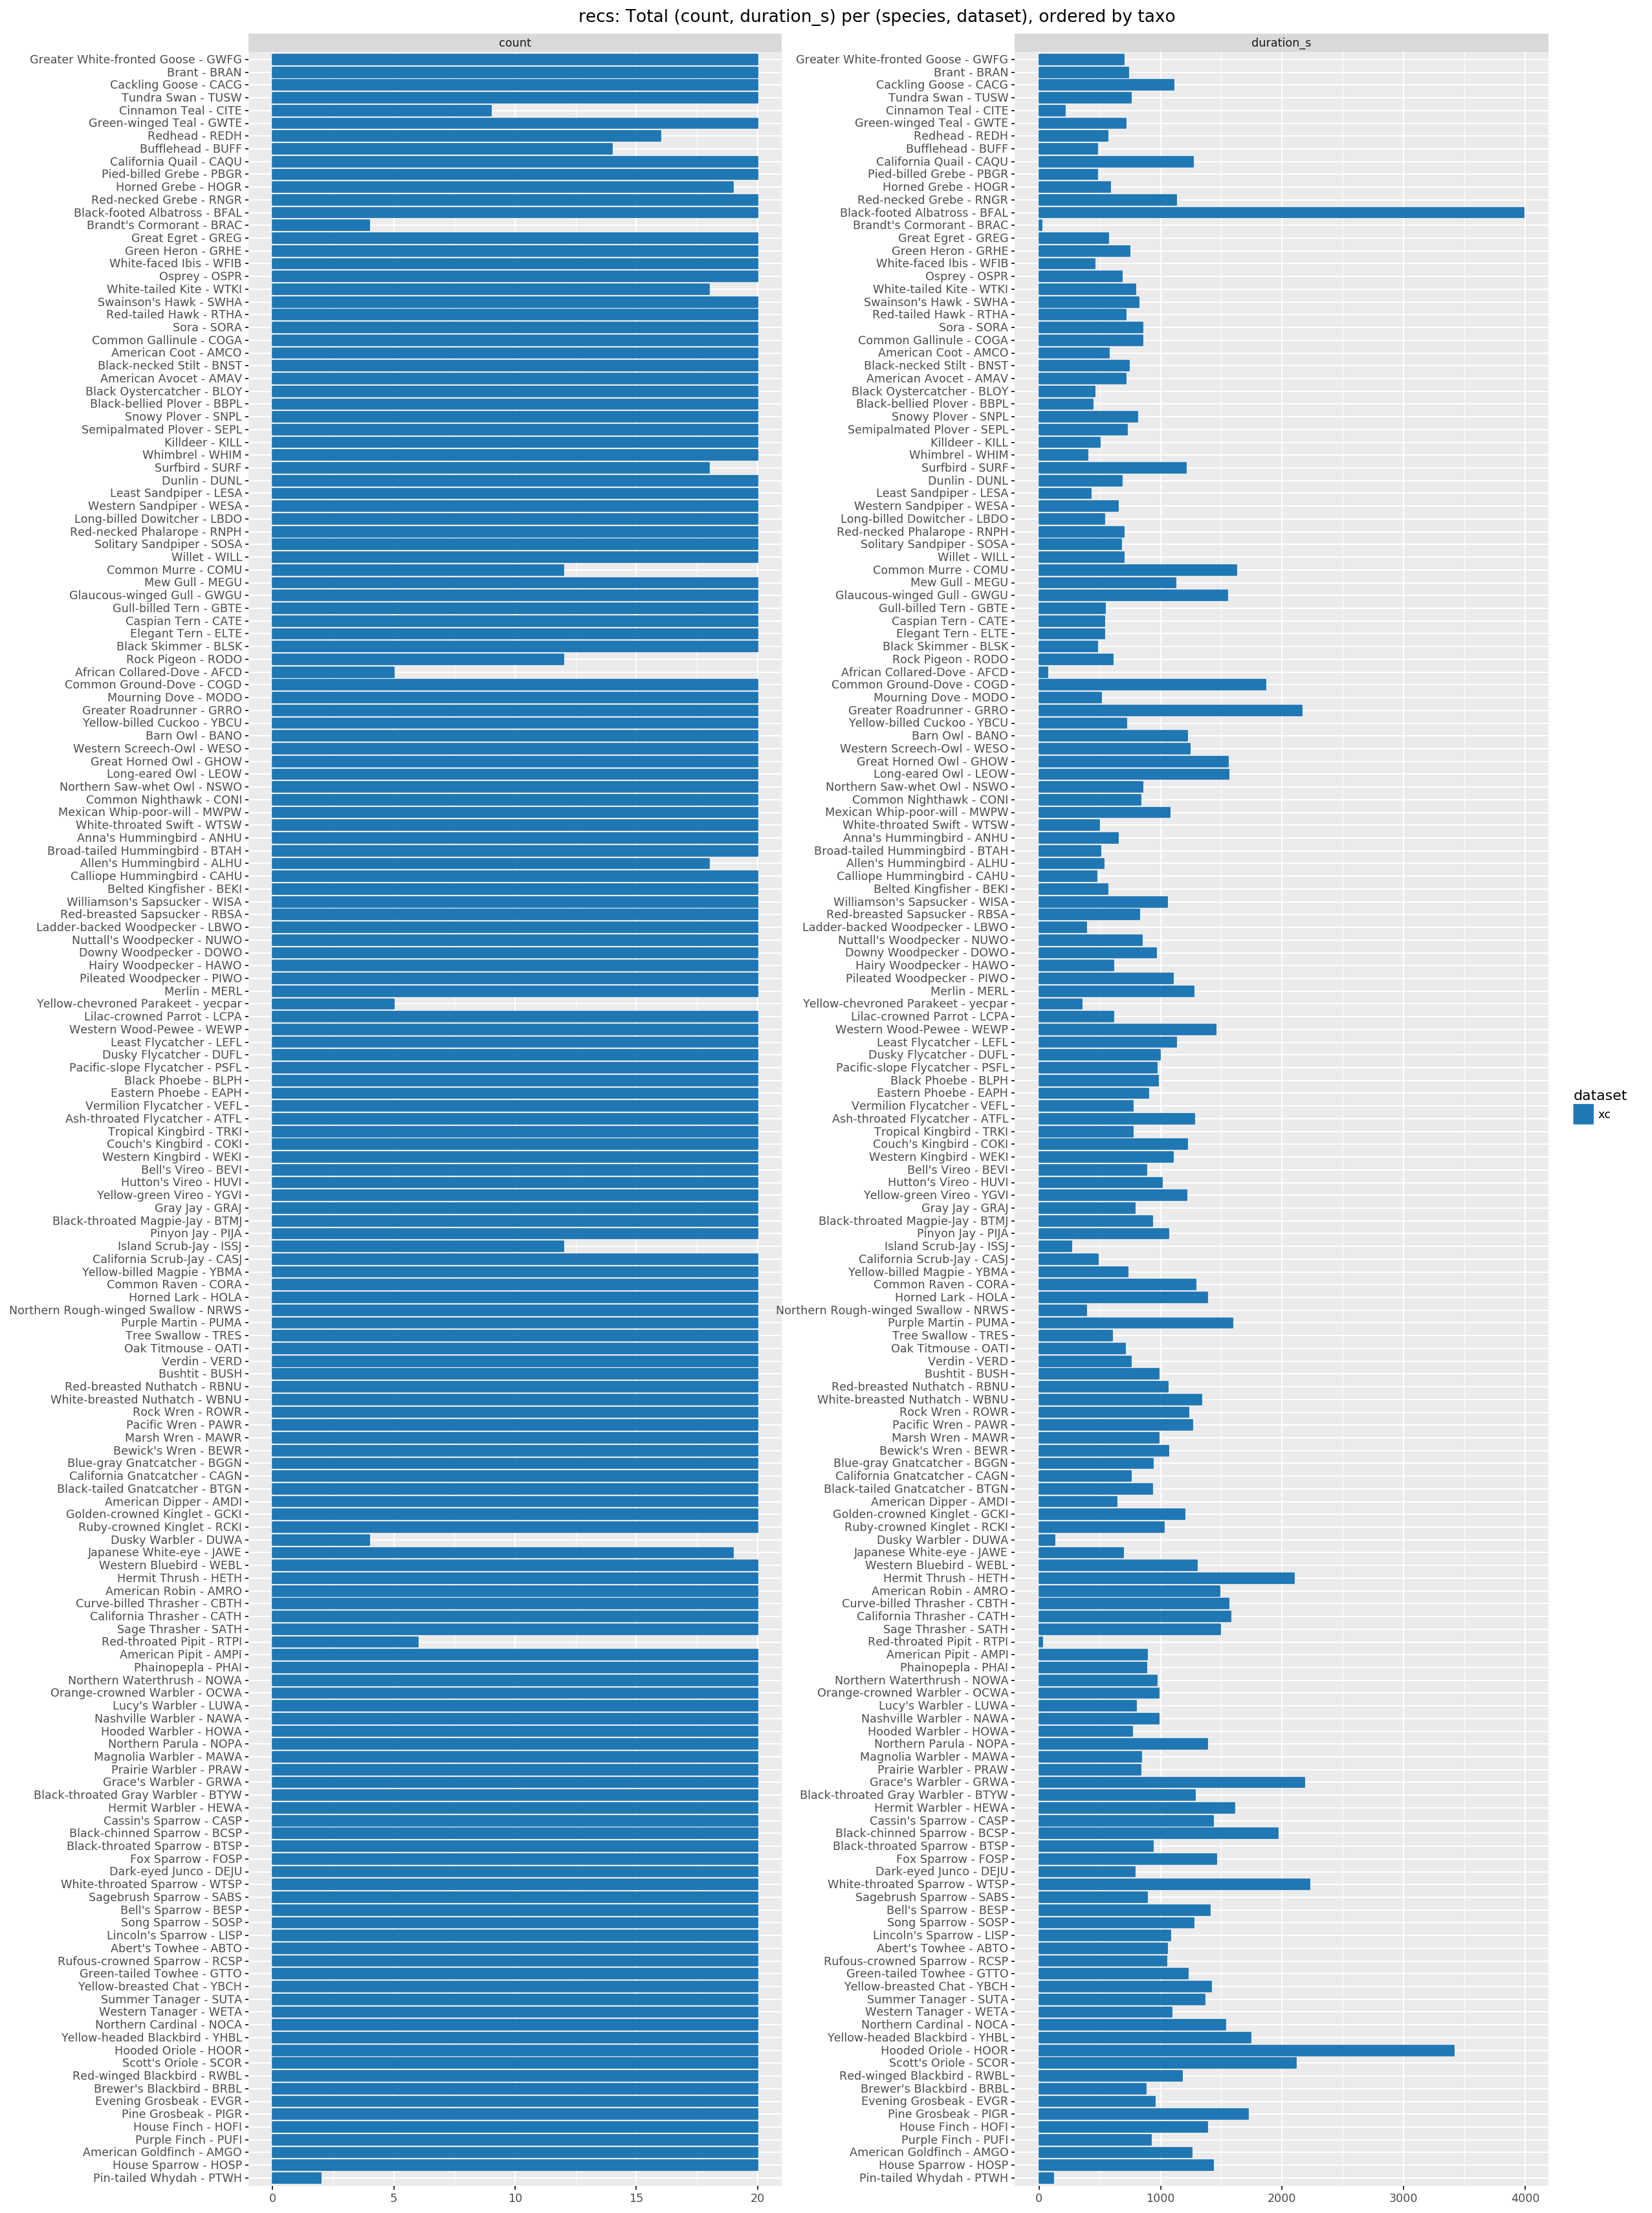

<ggplot: (316521571)>

In [ ]:
(recs
    .assign(species=lambda df: df.species_longhand)
    .assign(count=1)
    # 0-fill all (species, dataset) combinations to create empty placeholders for missing bars
    .pipe(lambda df: df.append(
        pd.DataFrame([
            dict(species=species, dataset=dataset, duration_s=0)
            for species in df.species.unique()
            for dataset in df.dataset.unique()
        ])
        .astype({'species': df.species.dtype})
    ))
    .groupby(['dataset', 'species'])[['count', 'duration_s']].sum().reset_index()
    .pipe(df_reverse_cat, 'species')  # Order species by taxo
    .pipe(pd.melt, id_vars=['dataset', 'species'], value_vars=['count', 'duration_s'])
    # .pipe(df_reverse_cat, 'species')  # Order species by taxo
    .pipe(df_remove_unused_categories)
    .pipe(ggplot, aes(x='species', y='value', fill='dataset', color='dataset'))
    + coord_flip()
    + geom_bar(stat='identity', position=position_dodge(), width=.8)
    + facet_wrap('variable', nrow=1, scales='free')
    + xlab('')
    + ylab('')
    + scale_fill_cmap_d(mpl.cm.tab10)
    + scale_color_cmap_d(mpl.cm.tab10)
    + theme(panel_spacing=2.5)
    + theme_figsize(width=18, aspect_ratio=4/1)
    + ggtitle(f'recs: Total (count, duration_s) per (species, dataset), ordered by taxo')
)

In [ ]:
# Add .feat
recs = projection.transform(recs)

[                                                                                          ] | 0% Completed |  0.0s

[                                                                                          ] | 0% Completed |  0.1s

[                                                                                          ] | 0% Completed |  0.3s

[                                                                                          ] | 0% Completed |  0.4s

[#                                                                                         ] | 1% Completed |  0.5s

•

[##                                                                                        ] | 2% Completed |  0.6s

•

•

[##                                                                                        ] | 2% Completed |  0.7s

•

•

•

•

[##                                                                                        ] | 2% Completed |  0.8s

•

•

•

•

[##                                                                                        ] | 2% Completed |  0.9s

•

•

•

•

[##                                                                                        ] | 2% Completed |  1.0s

•

•

•

[##                                                                                        ] | 2% Completed |  1.1s

•

•

•

•

[##                                                                                        ] | 2% Completed |  1.2s

•

•

•

[##                                                                                        ] | 2% Completed |  1.3s

[##                                                                                        ] | 2% Completed |  1.4s

[##                                                                                        ] | 2% Completed |  1.5s

•

•

[##                                                                                        ] | 2% Completed |  1.6s

•

[##                                                                                        ] | 2% Completed |  1.7s

•

[##                                                                                        ] | 2% Completed |  1.8s

[##                                                                                        ] | 2% Completed |  2.0s

•

•

[##                                                                                        ] | 2% Completed |  2.1s

•

[##                                                                                        ] | 2% Completed |  2.2s

[##                                                                                        ] | 2% Completed |  2.3s

•

•

•

•

[##                                                                                        ] | 2% Completed |  2.4s

•

•

•

[##                                                                                        ] | 2% Completed |  2.5s

•

•

•

•

•

•

•

[##                                                                                        ] | 2% Completed |  2.6s

•

•

•

[##                                                                                        ] | 2% Completed |  2.7s

•

•

•

•

[##                                                                                        ] | 2% Completed |  2.8s

•

•

•

•

[###                                                                                       ] | 3% Completed |  2.9s

•

•

•

•

•

[####                                                                                      ] | 5% Completed |  3.0s

•

•

•

•

[####                                                                                      ] | 5% Completed |  3.1s

•

•

•

•

•

[####                                                                                      ] | 5% Completed |  3.2s

•

•

•

•

[####                                                                                      ] | 5% Completed |  3.4s

•

•

•

•

[####                                                                                      ] | 5% Completed |  3.5s

•

•

•

•

[####                                                                                      ] | 5% Completed |  3.6s

•

[####                                                                                      ] | 5% Completed |  3.7s

•

•

•

[####                                                                                      ] | 5% Completed |  3.8s

•

[####                                                                                      ] | 5% Completed |  3.9s

•

•

[####                                                                                      ] | 5% Completed |  4.0s

•

•

•

[####                                                                                      ] | 5% Completed |  4.1s

•

•

[####                                                                                      ] | 5% Completed |  4.2s

•

•

[####                                                                                      ] | 5% Completed |  4.3s

•

•

[####                                                                                      ] | 5% Completed |  4.4s

•

•

•

[####                                                                                      ] | 5% Completed |  4.5s

•

•

•

[####                                                                                      ] | 5% Completed |  4.6s

•

[####                                                                                      ] | 5% Completed |  4.7s

[####                                                                                      ] | 5% Completed |  4.8s

•

[####                                                                                      ] | 5% Completed |  4.9s

•

•

[####                                                                                      ] | 5% Completed |  5.0s

•

•

[####                                                                                      ] | 5% Completed |  5.1s

•

[####                                                                                      ] | 5% Completed |  5.2s

•

•

•

[####                                                                                      ] | 5% Completed |  5.3s

•

[####                                                                                      ] | 5% Completed |  5.4s

•

•

•

•

•

[####                                                                                      ] | 5% Completed |  5.5s

•

•

[####                                                                                      ] | 5% Completed |  5.6s

•

•

•

•

•

•

[####                                                                                      ] | 5% Completed |  5.7s

•

•

•

[####                                                                                      ] | 5% Completed |  5.8s

•

[####                                                                                      ] | 5% Completed |  5.9s

•

•

[####                                                                                      ] | 5% Completed |  6.0s

•

•

•

[####                                                                                      ] | 5% Completed |  6.1s

•

[####                                                                                      ] | 5% Completed |  6.2s

[####                                                                                      ] | 5% Completed |  6.3s

•

•

[####                                                                                      ] | 5% Completed |  6.5s

•

[####                                                                                      ] | 5% Completed |  6.6s

•

•

•

•

•

[####                                                                                      ] | 5% Completed |  6.7s

•

[####                                                                                      ] | 5% Completed |  6.8s

•

•

[####                                                                                      ] | 5% Completed |  6.9s

•

•

•

•

•

[####                                                                                      ] | 5% Completed |  7.0s

•

•

[####                                                                                      ] | 5% Completed |  7.1s

•

•

•

•

•

•

[####                                                                                      ] | 5% Completed |  7.2s

•

•

•

[####                                                                                      ] | 5% Completed |  7.3s

•

•

[####                                                                                      ] | 5% Completed |  7.4s

•

[####                                                                                      ] | 5% Completed |  7.5s

•

•

[####                                                                                      ] | 5% Completed |  7.6s

[####                                                                                      ] | 5% Completed |  7.7s

•

•

•

•

•

[####                                                                                      ] | 5% Completed |  7.8s

•

•

•

[####                                                                                      ] | 5% Completed |  7.9s

•

•

•

[####                                                                                      ] | 5% Completed |  8.0s

•

•

•

•

•

[####                                                                                      ] | 5% Completed |  8.1s

•

•

[####                                                                                      ] | 5% Completed |  8.2s

•

•

•

•

[####                                                                                      ] | 5% Completed |  8.3s

•

•

•

•

[####                                                                                      ] | 5% Completed |  8.4s

•

[####                                                                                      ] | 5% Completed |  8.5s

•

•

[####                                                                                      ] | 5% Completed |  8.6s

•

•

[####                                                                                      ] | 5% Completed |  8.7s

•

[####                                                                                      ] | 5% Completed |  8.8s

•

•

[####                                                                                      ] | 5% Completed |  8.9s

•

•

•

[####                                                                                      ] | 5% Completed |  9.0s

•

[####                                                                                      ] | 5% Completed |  9.2s

•

•

•

[#####                                                                                     ] | 6% Completed |  9.3s

•

[#####                                                                                     ] | 6% Completed |  9.4s

•

•

•

[#####                                                                                     ] | 6% Completed |  9.5s

•

[#####                                                                                     ] | 6% Completed |  9.6s

•

•

[#####                                                                                     ] | 6% Completed |  9.7s

[#####                                                                                     ] | 6% Completed |  9.8s

•

[#####                                                                                     ] | 6% Completed |  9.9s

•

[#####                                                                                     ] | 6% Completed | 10.0s

•

•

•

[#####                                                                                     ] | 6% Completed | 10.1s

•

•

[#####                                                                                     ] | 6% Completed | 10.2s

•

•

[#####                                                                                     ] | 6% Completed | 10.3s

•

[#####                                                                                     ] | 6% Completed | 10.4s

•

•

[#####                                                                                     ] | 6% Completed | 10.5s

•

•

[#####                                                                                     ] | 6% Completed | 10.6s

•

•

[#####                                                                                     ] | 6% Completed | 10.7s

•

[#####                                                                                     ] | 6% Completed | 10.8s

•

[#####                                                                                     ] | 6% Completed | 10.9s

•

•

•

[#####                                                                                     ] | 6% Completed | 11.0s

•

•

•

[#####                                                                                     ] | 6% Completed | 11.1s

[#####                                                                                     ] | 6% Completed | 11.2s

•

•

[#####                                                                                     ] | 6% Completed | 11.3s

•

[#####                                                                                     ] | 6% Completed | 11.4s

[#####                                                                                     ] | 6% Completed | 11.5s

[#####                                                                                     ] | 6% Completed | 11.6s

•

[#####                                                                                     ] | 6% Completed | 11.7s

[#####                                                                                     ] | 6% Completed | 11.8s

[#####                                                                                     ] | 6% Completed | 11.9s

[#####                                                                                     ] | 6% Completed | 12.1s

[#####                                                                                     ] | 6% Completed | 12.2s

[#####                                                                                     ] | 6% Completed | 12.3s

•

[#####                                                                                     ] | 6% Completed | 12.4s

•

•

[#####                                                                                     ] | 6% Completed | 12.5s

[#####                                                                                     ] | 6% Completed | 12.6s

•

•

[#####                                                                                     ] | 6% Completed | 12.7s

[#####                                                                                     ] | 6% Completed | 12.8s

•

[#####                                                                                     ] | 6% Completed | 12.9s

•

•

•

[#####                                                                                     ] | 6% Completed | 13.0s

•

•

•

[#####                                                                                     ] | 6% Completed | 13.1s

•

•

•

[#####                                                                                     ] | 6% Completed | 13.2s

•

•

•

[#####                                                                                     ] | 6% Completed | 13.3s

•

•

[#####                                                                                     ] | 6% Completed | 13.4s

•

•

•

[#####                                                                                     ] | 6% Completed | 13.5s

•

[#####                                                                                     ] | 6% Completed | 13.6s

•

•

[#####                                                                                     ] | 6% Completed | 13.7s

•

•

[#####                                                                                     ] | 6% Completed | 13.8s

•

•

•

•

[#####                                                                                     ] | 6% Completed | 13.9s

•

[#####                                                                                     ] | 6% Completed | 14.0s

•

•

•

•

[#####                                                                                     ] | 6% Completed | 14.1s

•

•

•

•

[#####                                                                                     ] | 6% Completed | 14.2s

•

[#####                                                                                     ] | 6% Completed | 14.3s

•

•

[#####                                                                                     ] | 6% Completed | 14.4s

•

•

[#####                                                                                     ] | 6% Completed | 14.5s

•

•

[#####                                                                                     ] | 6% Completed | 14.6s

•

•

•

[#####                                                                                     ] | 6% Completed | 14.7s

•

•

[#####                                                                                     ] | 6% Completed | 14.8s

•

•

•

[#####                                                                                     ] | 6% Completed | 14.9s

•

•

•

•

[#####                                                                                     ] | 6% Completed | 15.0s

•

•

[#####                                                                                     ] | 6% Completed | 15.2s

•

[#####                                                                                     ] | 6% Completed | 15.3s

•

•

•

[#####                                                                                     ] | 6% Completed | 15.4s

•

•

•

[#####                                                                                     ] | 6% Completed | 15.5s

•

[#####                                                                                     ] | 6% Completed | 15.6s

•

[#####                                                                                     ] | 6% Completed | 15.7s

•

•

•

[#####                                                                                     ] | 6% Completed | 15.8s

•

•

•

[#####                                                                                     ] | 6% Completed | 15.9s

•

[#####                                                                                     ] | 6% Completed | 16.0s

•

•

•

•

[#####                                                                                     ] | 6% Completed | 16.1s

•

•

[#####                                                                                     ] | 6% Completed | 16.2s

•

[#####                                                                                     ] | 6% Completed | 16.3s

•

•

[#####                                                                                     ] | 6% Completed | 16.4s

•

•

•

[#####                                                                                     ] | 6% Completed | 16.5s

•

•

[#####                                                                                     ] | 6% Completed | 16.6s

•

[#####                                                                                     ] | 6% Completed | 16.7s

•

[#####                                                                                     ] | 6% Completed | 16.8s

•

[#####                                                                                     ] | 6% Completed | 16.9s

[#####                                                                                     ] | 6% Completed | 17.0s

•

•

•

•

•

[#####                                                                                     ] | 6% Completed | 17.1s

•

[######                                                                                    ] | 7% Completed | 17.2s

•

•

•

•

[######                                                                                    ] | 7% Completed | 17.3s

•

[######                                                                                    ] | 7% Completed | 17.4s

•

•

[######                                                                                    ] | 7% Completed | 17.5s

•

•

[######                                                                                    ] | 7% Completed | 17.6s

•

[######                                                                                    ] | 7% Completed | 17.7s

•

[######                                                                                    ] | 7% Completed | 17.8s

[######                                                                                    ] | 7% Completed | 17.9s

[######                                                                                    ] | 7% Completed | 18.0s

•

[######                                                                                    ] | 7% Completed | 18.2s

•

[######                                                                                    ] | 7% Completed | 18.3s

[######                                                                                    ] | 7% Completed | 18.4s

•

•

•

[######                                                                                    ] | 7% Completed | 18.5s

[######                                                                                    ] | 7% Completed | 18.6s

•

[######                                                                                    ] | 7% Completed | 18.7s

•

•

[######                                                                                    ] | 7% Completed | 18.8s

•

•

•

[######                                                                                    ] | 7% Completed | 18.9s

•

[######                                                                                    ] | 7% Completed | 19.0s

•

[######                                                                                    ] | 7% Completed | 19.1s

[#######                                                                                   ] | 8% Completed | 19.2s

•

•

[#######                                                                                   ] | 8% Completed | 19.3s

•

[#######                                                                                   ] | 8% Completed | 19.4s

•

•

[#######                                                                                   ] | 8% Completed | 19.5s

•

•

[#######                                                                                   ] | 8% Completed | 19.6s

•

•

[#######                                                                                   ] | 8% Completed | 19.7s

•

[#######                                                                                   ] | 8% Completed | 19.8s

•

•

•

•

[#######                                                                                   ] | 8% Completed | 19.9s

•

[#######                                                                                   ] | 8% Completed | 20.0s

•

•

[#######                                                                                   ] | 8% Completed | 20.1s

•

•

•

[#######                                                                                   ] | 8% Completed | 20.2s

[#######                                                                                   ] | 8% Completed | 20.3s

•

[#######                                                                                   ] | 8% Completed | 20.4s

[#######                                                                                   ] | 8% Completed | 20.5s

•

•

[#######                                                                                   ] | 8% Completed | 20.6s

•

•

•

[#######                                                                                   ] | 8% Completed | 20.7s

•

•

•

[#######                                                                                   ] | 8% Completed | 20.8s

•

•

[#######                                                                                   ] | 8% Completed | 20.9s

•

•

•

[#########                                                                                 ] | 10% Completed | 21.0s

•

•

•

[#########                                                                                 ] | 10% Completed | 21.1s

•

[#########                                                                                 ] | 10% Completed | 21.2s

•

•

•

[#########                                                                                 ] | 10% Completed | 21.3s

•

[#########                                                                                 ] | 10% Completed | 21.4s

•

[##########                                                                                ] | 11% Completed | 21.5s

•

[##########                                                                                ] | 11% Completed | 21.6s

[##########                                                                                ] | 11% Completed | 21.7s

•

[##########                                                                                ] | 11% Completed | 21.8s

•

•

[##########                                                                                ] | 11% Completed | 22.0s

•

[##########                                                                                ] | 11% Completed | 22.1s

[##########                                                                                ] | 11% Completed | 22.2s

[##########                                                                                ] | 11% Completed | 22.3s

•

[###########                                                                               ] | 12% Completed | 22.4s

•

•

[############                                                                              ] | 13% Completed | 22.5s

•

[############                                                                              ] | 13% Completed | 22.6s

•

•

[#############                                                                             ] | 15% Completed | 22.7s

•

•

[##############                                                                            ] | 16% Completed | 22.9s

•

[###############                                                                           ] | 17% Completed | 23.0s

•

[###############                                                                           ] | 17% Completed | 23.1s

•

[###############                                                                           ] | 17% Completed | 23.2s

•

•

•

[###############                                                                           ] | 17% Completed | 23.3s

•

[###############                                                                           ] | 17% Completed | 23.4s

•

•

•

•

[###############                                                                           ] | 17% Completed | 23.5s

•

[###############                                                                           ] | 17% Completed | 23.6s

[###############                                                                           ] | 17% Completed | 23.8s

•

[###############                                                                           ] | 17% Completed | 23.9s

•

[###############                                                                           ] | 17% Completed | 24.0s

[###############                                                                           ] | 17% Completed | 24.1s

[###############                                                                           ] | 17% Completed | 24.2s

•

[###############                                                                           ] | 17% Completed | 24.3s

[###############                                                                           ] | 17% Completed | 24.4s

•

•

[###############                                                                           ] | 17% Completed | 24.5s

•

[###############                                                                           ] | 17% Completed | 24.6s

[###############                                                                           ] | 17% Completed | 24.7s

•

•

[###############                                                                           ] | 17% Completed | 24.8s

•

•

•

[###############                                                                           ] | 17% Completed | 24.9s

•

[###############                                                                           ] | 17% Completed | 25.0s

•

•

[###############                                                                           ] | 17% Completed | 25.1s

•

•

•

[###############                                                                           ] | 17% Completed | 25.2s

•

•

•

•

[###############                                                                           ] | 17% Completed | 25.3s

•

[###############                                                                           ] | 17% Completed | 25.4s

•

[###############                                                                           ] | 17% Completed | 25.5s

•

[###############                                                                           ] | 17% Completed | 25.6s

•

[###############                                                                           ] | 17% Completed | 25.7s

•

[###############                                                                           ] | 17% Completed | 25.8s

[###############                                                                           ] | 17% Completed | 25.9s

•

[###############                                                                           ] | 17% Completed | 26.0s

•

•

•

[###############                                                                           ] | 17% Completed | 26.1s

•

[###############                                                                           ] | 17% Completed | 26.2s

•

[###############                                                                           ] | 17% Completed | 26.3s

[###############                                                                           ] | 17% Completed | 26.4s

[###############                                                                           ] | 17% Completed | 26.5s

[###############                                                                           ] | 17% Completed | 26.7s

•

•

•

[###############                                                                           ] | 17% Completed | 26.8s

•

•

•

[###############                                                                           ] | 17% Completed | 26.9s

•

[###############                                                                           ] | 17% Completed | 27.0s

•

[###############                                                                           ] | 17% Completed | 27.1s

[###############                                                                           ] | 17% Completed | 27.2s

[###############                                                                           ] | 17% Completed | 27.3s

[###############                                                                           ] | 17% Completed | 27.4s

•

•

[###############                                                                           ] | 17% Completed | 27.5s

•

•

[###############                                                                           ] | 17% Completed | 27.6s

[###############                                                                           ] | 17% Completed | 27.7s

•

[###############                                                                           ] | 17% Completed | 27.8s

[###############                                                                           ] | 17% Completed | 27.9s

•

•

[###############                                                                           ] | 17% Completed | 28.0s

•

[################                                                                          ] | 18% Completed | 28.1s

•

•

[################                                                                          ] | 18% Completed | 28.2s

•

[################                                                                          ] | 18% Completed | 28.3s

•

•

[################                                                                          ] | 18% Completed | 28.4s

•

[################                                                                          ] | 18% Completed | 28.5s

[################                                                                          ] | 18% Completed | 28.6s

•

[################                                                                          ] | 18% Completed | 28.7s

•

[################                                                                          ] | 18% Completed | 28.8s

•

[################                                                                          ] | 18% Completed | 28.9s

[################                                                                          ] | 18% Completed | 29.0s

•

[################                                                                          ] | 18% Completed | 29.1s

[################                                                                          ] | 18% Completed | 29.2s

[################                                                                          ] | 18% Completed | 29.3s

[################                                                                          ] | 18% Completed | 29.4s

•

[################                                                                          ] | 18% Completed | 29.5s

•

[################                                                                          ] | 18% Completed | 29.6s

•

[################                                                                          ] | 18% Completed | 29.7s

[################                                                                          ] | 18% Completed | 29.8s

•

•

[################                                                                          ] | 18% Completed | 29.9s

•

[################                                                                          ] | 18% Completed | 30.0s

•

[################                                                                          ] | 18% Completed | 30.1s

•

[################                                                                          ] | 18% Completed | 30.3s

[################                                                                          ] | 18% Completed | 30.4s

[################                                                                          ] | 18% Completed | 30.5s

[################                                                                          ] | 18% Completed | 30.6s

•

•

[################                                                                          ] | 18% Completed | 30.7s

•

[################                                                                          ] | 18% Completed | 30.8s

•

[################                                                                          ] | 18% Completed | 30.9s

•

•

•

[################                                                                          ] | 18% Completed | 31.0s

•

•

[################                                                                          ] | 18% Completed | 31.1s

[################                                                                          ] | 18% Completed | 31.2s

[##################                                                                        ] | 20% Completed | 31.3s

[##################                                                                        ] | 20% Completed | 31.4s

•

[##################                                                                        ] | 20% Completed | 31.5s

•

[##################                                                                        ] | 20% Completed | 31.6s

•

[##################                                                                        ] | 20% Completed | 31.7s

[##################                                                                        ] | 20% Completed | 31.8s

[##################                                                                        ] | 20% Completed | 31.9s

•

[##################                                                                        ] | 20% Completed | 32.0s

•

[##################                                                                        ] | 20% Completed | 32.1s

[##################                                                                        ] | 20% Completed | 32.2s

•

•

[##################                                                                        ] | 20% Completed | 32.3s

•

[##################                                                                        ] | 20% Completed | 32.4s

•

[##################                                                                        ] | 20% Completed | 32.5s

•

•

•

[##################                                                                        ] | 20% Completed | 32.6s

[##################                                                                        ] | 20% Completed | 32.7s

•

•

[##################                                                                        ] | 20% Completed | 32.8s

•

•

[##################                                                                        ] | 20% Completed | 32.9s

•

•

[##################                                                                        ] | 20% Completed | 33.0s

•

[##################                                                                        ] | 20% Completed | 33.1s

•

•

•

[##################                                                                        ] | 20% Completed | 33.2s

•

[##################                                                                        ] | 20% Completed | 33.3s

•

•

•

[##################                                                                        ] | 20% Completed | 33.5s

[##################                                                                        ] | 20% Completed | 33.6s

•

[##################                                                                        ] | 20% Completed | 33.7s

•

[##################                                                                        ] | 20% Completed | 33.8s

•

•

[##################                                                                        ] | 20% Completed | 33.9s

•

[##################                                                                        ] | 20% Completed | 34.0s

•

[##################                                                                        ] | 20% Completed | 34.1s

•

[##################                                                                        ] | 20% Completed | 34.2s

•

•

[##################                                                                        ] | 20% Completed | 34.3s

[##################                                                                        ] | 20% Completed | 34.4s

•

[##################                                                                        ] | 20% Completed | 34.5s

•

[##################                                                                        ] | 20% Completed | 34.6s

•

•

[##################                                                                        ] | 20% Completed | 34.7s

•

[##################                                                                        ] | 20% Completed | 34.8s

•

[##################                                                                        ] | 20% Completed | 34.9s

•

[##################                                                                        ] | 20% Completed | 35.0s

•

•

[##################                                                                        ] | 20% Completed | 35.1s

•

[##################                                                                        ] | 20% Completed | 35.2s

•

[##################                                                                        ] | 20% Completed | 35.3s

•

[##################                                                                        ] | 20% Completed | 35.4s

•

[##################                                                                        ] | 20% Completed | 35.5s

•

•

[##################                                                                        ] | 20% Completed | 35.6s

•

[##################                                                                        ] | 20% Completed | 35.7s

•

[##################                                                                        ] | 20% Completed | 35.8s

•

•

[##################                                                                        ] | 20% Completed | 35.9s

[##################                                                                        ] | 20% Completed | 36.0s

•

[##################                                                                        ] | 20% Completed | 36.1s

•

[##################                                                                        ] | 20% Completed | 36.2s

•

[##################                                                                        ] | 20% Completed | 36.3s

•

[##################                                                                        ] | 20% Completed | 36.4s

•

[##################                                                                        ] | 20% Completed | 36.5s

•

[##################                                                                        ] | 20% Completed | 36.7s

•

•

[##################                                                                        ] | 20% Completed | 36.8s

•

[##################                                                                        ] | 20% Completed | 36.9s

[##################                                                                        ] | 20% Completed | 37.0s

•

•

•

[##################                                                                        ] | 20% Completed | 37.1s

•

[##################                                                                        ] | 20% Completed | 37.2s

[##################                                                                        ] | 20% Completed | 37.3s

[##################                                                                        ] | 20% Completed | 37.4s

•

•

[##################                                                                        ] | 20% Completed | 37.5s

•

[##################                                                                        ] | 20% Completed | 37.6s

[##################                                                                        ] | 20% Completed | 37.7s

•

[##################                                                                        ] | 20% Completed | 37.8s

•

•

[##################                                                                        ] | 20% Completed | 37.9s

•

[##################                                                                        ] | 20% Completed | 38.0s

•

•

[##################                                                                        ] | 20% Completed | 38.1s

[##################                                                                        ] | 20% Completed | 38.2s

•

•

[##################                                                                        ] | 20% Completed | 38.3s

•

•

•

[##################                                                                        ] | 20% Completed | 38.4s

•

•

•

[##################                                                                        ] | 20% Completed | 38.5s

[##################                                                                        ] | 20% Completed | 38.6s

•

•

[##################                                                                        ] | 20% Completed | 38.7s

•

[##################                                                                        ] | 20% Completed | 38.8s

•

[##################                                                                        ] | 20% Completed | 38.9s

•

•

•

[##################                                                                        ] | 20% Completed | 39.0s

•

[##################                                                                        ] | 20% Completed | 39.1s

•

[##################                                                                        ] | 20% Completed | 39.2s

[##################                                                                        ] | 20% Completed | 39.3s

•

[##################                                                                        ] | 20% Completed | 39.4s

•

[##################                                                                        ] | 20% Completed | 39.5s

[##################                                                                        ] | 20% Completed | 39.6s

•

•

•

[##################                                                                        ] | 20% Completed | 39.7s

•

•

•

[##################                                                                        ] | 20% Completed | 39.8s

•

•

[##################                                                                        ] | 20% Completed | 40.0s

•

•

[##################                                                                        ] | 20% Completed | 40.1s

•

[##################                                                                        ] | 20% Completed | 40.2s

[##################                                                                        ] | 20% Completed | 40.3s

•

•

•

•

[##################                                                                        ] | 20% Completed | 40.4s

•

•

[##################                                                                        ] | 20% Completed | 40.5s

•

•

[##################                                                                        ] | 20% Completed | 40.6s

[##################                                                                        ] | 20% Completed | 40.7s

•

•

[##################                                                                        ] | 20% Completed | 40.8s

•

[##################                                                                        ] | 20% Completed | 40.9s

•

•

[##################                                                                        ] | 20% Completed | 41.0s

•

•

[##################                                                                        ] | 20% Completed | 41.1s

•

[##################                                                                        ] | 20% Completed | 41.2s

•

•

•

•

[##################                                                                        ] | 20% Completed | 41.3s

•

•

[##################                                                                        ] | 20% Completed | 41.4s

•

•

[##################                                                                        ] | 20% Completed | 41.5s

•

•

•

[##################                                                                        ] | 20% Completed | 41.6s

•

•

•

[##################                                                                        ] | 20% Completed | 41.7s

•

•

[##################                                                                        ] | 20% Completed | 41.8s

•

[##################                                                                        ] | 20% Completed | 41.9s

[##################                                                                        ] | 20% Completed | 42.0s

•

[##################                                                                        ] | 20% Completed | 42.1s

•

•

[##################                                                                        ] | 20% Completed | 42.2s

[###################                                                                       ] | 21% Completed | 42.3s

[###################                                                                       ] | 21% Completed | 42.4s

[###################                                                                       ] | 21% Completed | 42.5s

[###################                                                                       ] | 21% Completed | 42.6s

[###################                                                                       ] | 21% Completed | 42.7s

[###################                                                                       ] | 21% Completed | 42.8s

[###################                                                                       ] | 21% Completed | 42.9s

[###################                                                                       ] | 21% Completed | 43.0s

[###################                                                                       ] | 21% Completed | 43.1s

[###################                                                                       ] | 21% Completed | 43.2s

•

•

[###################                                                                       ] | 21% Completed | 43.3s

•

•

•

[###################                                                                       ] | 21% Completed | 43.5s

[###################                                                                       ] | 21% Completed | 43.6s

•

[###################                                                                       ] | 21% Completed | 43.7s

•

[###################                                                                       ] | 21% Completed | 43.8s

•

•

•

[###################                                                                       ] | 21% Completed | 43.9s

•

•

•

[###################                                                                       ] | 21% Completed | 44.0s

[###################                                                                       ] | 21% Completed | 44.1s

•

•

•

[###################                                                                       ] | 21% Completed | 44.2s

•

•

[###################                                                                       ] | 21% Completed | 44.3s

•

•

[###################                                                                       ] | 21% Completed | 44.4s

•

[###################                                                                       ] | 21% Completed | 44.5s

[###################                                                                       ] | 21% Completed | 44.6s

•

[###################                                                                       ] | 21% Completed | 44.7s

•

•

[###################                                                                       ] | 21% Completed | 44.8s

•

[###################                                                                       ] | 21% Completed | 44.9s

•

•

[###################                                                                       ] | 21% Completed | 45.0s

•

•

[###################                                                                       ] | 21% Completed | 45.1s

[###################                                                                       ] | 21% Completed | 45.2s

•

•

[###################                                                                       ] | 21% Completed | 45.3s

•

•

•

[###################                                                                       ] | 21% Completed | 45.4s

•

•

•

[###################                                                                       ] | 21% Completed | 45.5s

•

[###################                                                                       ] | 21% Completed | 45.6s

[###################                                                                       ] | 21% Completed | 45.7s

[###################                                                                       ] | 21% Completed | 45.8s

•

•

[###################                                                                       ] | 21% Completed | 45.9s

•

[###################                                                                       ] | 21% Completed | 46.0s

[###################                                                                       ] | 21% Completed | 46.1s

•

[###################                                                                       ] | 21% Completed | 46.2s

•

•

[###################                                                                       ] | 21% Completed | 46.4s

•

•

•

[###################                                                                       ] | 21% Completed | 46.5s

•

[###################                                                                       ] | 21% Completed | 46.6s

•

[###################                                                                       ] | 21% Completed | 46.7s

•

[###################                                                                       ] | 21% Completed | 46.8s

•

•

[###################                                                                       ] | 21% Completed | 46.9s

[###################                                                                       ] | 21% Completed | 47.0s

[####################                                                                      ] | 22% Completed | 47.1s

[####################                                                                      ] | 22% Completed | 47.2s

[####################                                                                      ] | 22% Completed | 47.3s

[####################                                                                      ] | 22% Completed | 47.4s

•

•

[####################                                                                      ] | 22% Completed | 47.5s

•

•

[####################                                                                      ] | 22% Completed | 47.6s

•

•

[####################                                                                      ] | 22% Completed | 47.7s

•

[####################                                                                      ] | 22% Completed | 47.8s

•

[####################                                                                      ] | 22% Completed | 47.9s

•

•

[####################                                                                      ] | 22% Completed | 48.0s

•

[####################                                                                      ] | 22% Completed | 48.1s

•

[####################                                                                      ] | 22% Completed | 48.2s

•

[####################                                                                      ] | 22% Completed | 48.3s

[####################                                                                      ] | 22% Completed | 48.4s

•

[####################                                                                      ] | 22% Completed | 48.5s

•

•

[####################                                                                      ] | 22% Completed | 48.6s

[####################                                                                      ] | 22% Completed | 48.7s

•

[####################                                                                      ] | 22% Completed | 48.8s

•

[####################                                                                      ] | 22% Completed | 48.9s

[####################                                                                      ] | 22% Completed | 49.0s

•

[####################                                                                      ] | 22% Completed | 49.1s

[####################                                                                      ] | 22% Completed | 49.2s

[####################                                                                      ] | 22% Completed | 49.3s

[####################                                                                      ] | 22% Completed | 49.4s

[####################                                                                      ] | 22% Completed | 49.5s

[####################                                                                      ] | 22% Completed | 49.6s

[####################                                                                      ] | 22% Completed | 49.7s

•

[####################                                                                      ] | 22% Completed | 49.9s

•

[####################                                                                      ] | 22% Completed | 50.0s

[####################                                                                      ] | 22% Completed | 50.1s

•

•

[####################                                                                      ] | 22% Completed | 50.2s

•

[####################                                                                      ] | 22% Completed | 50.3s

•

[####################                                                                      ] | 22% Completed | 50.4s

•

•

[####################                                                                      ] | 22% Completed | 50.5s

[####################                                                                      ] | 22% Completed | 50.6s

•

[####################                                                                      ] | 22% Completed | 50.7s

[####################                                                                      ] | 22% Completed | 50.8s

[####################                                                                      ] | 22% Completed | 50.9s

[####################                                                                      ] | 22% Completed | 51.0s

[####################                                                                      ] | 22% Completed | 51.1s

[####################                                                                      ] | 22% Completed | 51.2s

[####################                                                                      ] | 22% Completed | 51.3s

•

[####################                                                                      ] | 22% Completed | 51.4s

•

[####################                                                                      ] | 22% Completed | 51.5s

•

[####################                                                                      ] | 22% Completed | 51.6s

•

[####################                                                                      ] | 22% Completed | 51.7s

•

[####################                                                                      ] | 22% Completed | 51.8s

[####################                                                                      ] | 22% Completed | 51.9s

[####################                                                                      ] | 22% Completed | 52.0s

•

[####################                                                                      ] | 22% Completed | 52.1s

•

•

•

[####################                                                                      ] | 22% Completed | 52.2s

[####################                                                                      ] | 22% Completed | 52.3s

[####################                                                                      ] | 22% Completed | 52.4s

[####################                                                                      ] | 22% Completed | 52.5s

[####################                                                                      ] | 22% Completed | 52.6s

•

[####################                                                                      ] | 22% Completed | 52.7s

•

[####################                                                                      ] | 22% Completed | 52.8s

•

•

[####################                                                                      ] | 22% Completed | 52.9s

[####################                                                                      ] | 22% Completed | 53.0s

•

[####################                                                                      ] | 22% Completed | 53.1s

•

[#####################                                                                     ] | 23% Completed | 53.2s

•

[######################                                                                    ] | 25% Completed | 53.4s

•

•

[#######################                                                                   ] | 26% Completed | 53.5s

•

[#######################                                                                   ] | 26% Completed | 53.6s

[########################                                                                  ] | 27% Completed | 53.7s

[########################                                                                  ] | 27% Completed | 53.8s

•

[########################                                                                  ] | 27% Completed | 53.9s

[########################                                                                  ] | 27% Completed | 54.0s

•

•

[########################                                                                  ] | 27% Completed | 54.1s

[########################                                                                  ] | 27% Completed | 54.2s

•

[########################                                                                  ] | 27% Completed | 54.4s

•

[########################                                                                  ] | 27% Completed | 54.5s

•

[########################                                                                  ] | 27% Completed | 54.6s

•

•

[########################                                                                  ] | 27% Completed | 54.7s

•

[########################                                                                  ] | 27% Completed | 54.8s

•

[########################                                                                  ] | 27% Completed | 54.9s

•

•

[########################                                                                  ] | 27% Completed | 55.0s

•

•

[########################                                                                  ] | 27% Completed | 55.1s

•

•

[########################                                                                  ] | 27% Completed | 55.2s

•

•

[########################                                                                  ] | 27% Completed | 55.3s

•

[########################                                                                  ] | 27% Completed | 55.4s

•

[########################                                                                  ] | 27% Completed | 55.5s

•

[########################                                                                  ] | 27% Completed | 55.6s

•

•

[#########################                                                                 ] | 28% Completed | 55.7s

•

•

[#########################                                                                 ] | 28% Completed | 55.8s

•

•

•

[#########################                                                                 ] | 28% Completed | 55.9s

[#########################                                                                 ] | 28% Completed | 56.0s

[#########################                                                                 ] | 28% Completed | 56.1s

•

[#########################                                                                 ] | 28% Completed | 56.2s

•

•

[#########################                                                                 ] | 28% Completed | 56.3s

[#########################                                                                 ] | 28% Completed | 56.4s

•

[#########################                                                                 ] | 28% Completed | 56.5s

•

•

[#########################                                                                 ] | 28% Completed | 56.6s

[#########################                                                                 ] | 28% Completed | 56.7s

[#########################                                                                 ] | 28% Completed | 56.8s

•

[#########################                                                                 ] | 28% Completed | 56.9s

•

[#########################                                                                 ] | 28% Completed | 57.0s

•

[#########################                                                                 ] | 28% Completed | 57.1s

•

[#########################                                                                 ] | 28% Completed | 57.2s

•

•

[###########################                                                               ] | 30% Completed | 57.3s

•

•

[###########################                                                               ] | 30% Completed | 57.4s

[###########################                                                               ] | 30% Completed | 57.5s

•

•

•

[###########################                                                               ] | 30% Completed | 57.6s

•

•

[###########################                                                               ] | 30% Completed | 57.7s

[###########################                                                               ] | 30% Completed | 57.9s

•

[###########################                                                               ] | 30% Completed | 58.0s

•

[###########################                                                               ] | 30% Completed | 58.1s

•

[###########################                                                               ] | 30% Completed | 58.2s

[###########################                                                               ] | 30% Completed | 58.3s

•

•

[###########################                                                               ] | 30% Completed | 58.4s

•

•

[###########################                                                               ] | 30% Completed | 58.5s

•

•

•

[###########################                                                               ] | 30% Completed | 58.6s

•

[###########################                                                               ] | 30% Completed | 58.7s

•

•

[###########################                                                               ] | 30% Completed | 58.8s

•

[###########################                                                               ] | 30% Completed | 58.9s

[###########################                                                               ] | 30% Completed | 59.0s

•

[###########################                                                               ] | 30% Completed | 59.1s

•

•

[###########################                                                               ] | 30% Completed | 59.2s

•

[###########################                                                               ] | 30% Completed | 59.3s

•

•

[###########################                                                               ] | 30% Completed | 59.4s

•

•

•

[###########################                                                               ] | 30% Completed | 59.5s

[###########################                                                               ] | 30% Completed | 59.6s

•

•

[###########################                                                               ] | 30% Completed | 59.7s

•

[###########################                                                               ] | 30% Completed | 59.8s

[###########################                                                               ] | 30% Completed | 59.9s

•

•

[###########################                                                               ] | 30% Completed |  1min  0.0s

•

•

•

•

[###########################                                                               ] | 30% Completed |  1min  0.1s

•

•

[###########################                                                               ] | 30% Completed |  1min  0.2s

•

•

[###########################                                                               ] | 30% Completed |  1min  0.3s

•

•

[###########################                                                               ] | 30% Completed |  1min  0.4s

•

•

[###########################                                                               ] | 30% Completed |  1min  0.5s

•

•

[###########################                                                               ] | 30% Completed |  1min  0.6s

•

•

•

•

[###########################                                                               ] | 30% Completed |  1min  0.7s

•

•

•

•

[###########################                                                               ] | 30% Completed |  1min  0.9s

•

[###########################                                                               ] | 30% Completed |  1min  1.0s

•

•

•

•

[###########################                                                               ] | 30% Completed |  1min  1.1s

•

•

[###########################                                                               ] | 30% Completed |  1min  1.2s

[###########################                                                               ] | 30% Completed |  1min  1.3s

•

•

[###########################                                                               ] | 30% Completed |  1min  1.4s

•

[###########################                                                               ] | 30% Completed |  1min  1.5s

•

•

•

•

•

[###########################                                                               ] | 30% Completed |  1min  1.6s

•

[###########################                                                               ] | 30% Completed |  1min  1.7s

•

[############################                                                              ] | 31% Completed |  1min  1.8s

•

[############################                                                              ] | 31% Completed |  1min  1.9s

•

[############################                                                              ] | 31% Completed |  1min  2.0s

•

[############################                                                              ] | 31% Completed |  1min  2.1s

•

[############################                                                              ] | 31% Completed |  1min  2.2s

•

[############################                                                              ] | 31% Completed |  1min  2.3s

•

[############################                                                              ] | 31% Completed |  1min  2.4s

[############################                                                              ] | 31% Completed |  1min  2.5s

•

[############################                                                              ] | 31% Completed |  1min  2.6s

•

[############################                                                              ] | 31% Completed |  1min  2.7s

•

[############################                                                              ] | 31% Completed |  1min  2.8s

[############################                                                              ] | 31% Completed |  1min  2.9s

•

•

[############################                                                              ] | 31% Completed |  1min  3.0s

•

•

[############################                                                              ] | 31% Completed |  1min  3.1s

[############################                                                              ] | 31% Completed |  1min  3.2s

•

•

•

[############################                                                              ] | 31% Completed |  1min  3.3s

•

[############################                                                              ] | 31% Completed |  1min  3.4s

•

•

•

[############################                                                              ] | 31% Completed |  1min  3.5s

•

[############################                                                              ] | 31% Completed |  1min  3.6s

[############################                                                              ] | 31% Completed |  1min  3.7s

•

[############################                                                              ] | 31% Completed |  1min  3.8s

[############################                                                              ] | 31% Completed |  1min  3.9s

•

[############################                                                              ] | 31% Completed |  1min  4.0s

•

•

[############################                                                              ] | 31% Completed |  1min  4.1s

•

•

•

•

[############################                                                              ] | 31% Completed |  1min  4.2s

•

[############################                                                              ] | 31% Completed |  1min  4.3s

•

[############################                                                              ] | 31% Completed |  1min  4.4s

[############################                                                              ] | 31% Completed |  1min  4.5s

•

•

[############################                                                              ] | 31% Completed |  1min  4.6s

[############################                                                              ] | 31% Completed |  1min  4.8s

[############################                                                              ] | 31% Completed |  1min  4.9s

•

•

[############################                                                              ] | 31% Completed |  1min  5.0s

•

[############################                                                              ] | 31% Completed |  1min  5.1s

[############################                                                              ] | 31% Completed |  1min  5.2s

[############################                                                              ] | 31% Completed |  1min  5.3s

•

[############################                                                              ] | 31% Completed |  1min  5.4s

[############################                                                              ] | 31% Completed |  1min  5.5s

•

[############################                                                              ] | 31% Completed |  1min  5.6s

[############################                                                              ] | 31% Completed |  1min  5.7s

•

[############################                                                              ] | 31% Completed |  1min  5.8s

•

[############################                                                              ] | 31% Completed |  1min  5.9s

•

[############################                                                              ] | 31% Completed |  1min  6.0s

•

•

•

[############################                                                              ] | 31% Completed |  1min  6.1s

•

•

[############################                                                              ] | 31% Completed |  1min  6.2s

[############################                                                              ] | 31% Completed |  1min  6.3s

•

•

[############################                                                              ] | 31% Completed |  1min  6.4s

•

[############################                                                              ] | 31% Completed |  1min  6.5s

[############################                                                              ] | 31% Completed |  1min  6.6s

[############################                                                              ] | 31% Completed |  1min  6.7s

•

[############################                                                              ] | 31% Completed |  1min  6.8s

[############################                                                              ] | 31% Completed |  1min  6.9s

•

•

[############################                                                              ] | 31% Completed |  1min  7.0s

•

•

•

[############################                                                              ] | 31% Completed |  1min  7.1s

•

[############################                                                              ] | 31% Completed |  1min  7.2s

•

•

[############################                                                              ] | 31% Completed |  1min  7.3s

•

•

[#############################                                                             ] | 32% Completed |  1min  7.4s

•

•

•

[#############################                                                             ] | 32% Completed |  1min  7.5s

•

[#############################                                                             ] | 32% Completed |  1min  7.6s

•

[#############################                                                             ] | 32% Completed |  1min  7.7s

•

•

[#############################                                                             ] | 32% Completed |  1min  7.8s

•

[#############################                                                             ] | 32% Completed |  1min  7.9s

[#############################                                                             ] | 32% Completed |  1min  8.1s

[#############################                                                             ] | 32% Completed |  1min  8.2s

[#############################                                                             ] | 32% Completed |  1min  8.3s

•

•

•

[#############################                                                             ] | 32% Completed |  1min  8.4s

•

[#############################                                                             ] | 32% Completed |  1min  8.5s

[#############################                                                             ] | 32% Completed |  1min  8.6s

•

•

[#############################                                                             ] | 32% Completed |  1min  8.7s

•

•

•

•

[#############################                                                             ] | 32% Completed |  1min  8.8s

•

•

[#############################                                                             ] | 32% Completed |  1min  8.9s

•

•

[#############################                                                             ] | 32% Completed |  1min  9.0s

•

•

[#############################                                                             ] | 32% Completed |  1min  9.1s

•

•

[#############################                                                             ] | 32% Completed |  1min  9.2s

•

[#############################                                                             ] | 32% Completed |  1min  9.3s

[#############################                                                             ] | 32% Completed |  1min  9.4s

[#############################                                                             ] | 32% Completed |  1min  9.5s

•

•

[#############################                                                             ] | 32% Completed |  1min  9.6s

•

[#############################                                                             ] | 32% Completed |  1min  9.7s

•

•

[#############################                                                             ] | 32% Completed |  1min  9.8s

[#############################                                                             ] | 32% Completed |  1min  9.9s

[##############################                                                            ] | 33% Completed |  1min 10.0s

[##############################                                                            ] | 33% Completed |  1min 10.1s

•

[##############################                                                            ] | 33% Completed |  1min 10.2s

•

•

[##############################                                                            ] | 33% Completed |  1min 10.3s

•

[##############################                                                            ] | 33% Completed |  1min 10.4s

•

[##############################                                                            ] | 33% Completed |  1min 10.5s

[##############################                                                            ] | 33% Completed |  1min 10.6s

•

[##############################                                                            ] | 33% Completed |  1min 10.7s

•

[##############################                                                            ] | 33% Completed |  1min 10.8s

[##############################                                                            ] | 33% Completed |  1min 10.9s

[##############################                                                            ] | 33% Completed |  1min 11.0s

[##############################                                                            ] | 33% Completed |  1min 11.1s

[##############################                                                            ] | 33% Completed |  1min 11.2s

[##############################                                                            ] | 33% Completed |  1min 11.3s

•

[##############################                                                            ] | 33% Completed |  1min 11.4s

[##############################                                                            ] | 33% Completed |  1min 11.5s

•

[##############################                                                            ] | 33% Completed |  1min 11.6s

•

[##############################                                                            ] | 33% Completed |  1min 11.7s

•

•

[##############################                                                            ] | 33% Completed |  1min 11.8s

•

•

[##############################                                                            ] | 33% Completed |  1min 11.9s

[##############################                                                            ] | 33% Completed |  1min 12.0s

[##############################                                                            ] | 33% Completed |  1min 12.1s

•

[##############################                                                            ] | 33% Completed |  1min 12.3s

•

•

•

[##############################                                                            ] | 33% Completed |  1min 12.4s

[##############################                                                            ] | 33% Completed |  1min 12.5s

[##############################                                                            ] | 33% Completed |  1min 12.6s

[##############################                                                            ] | 33% Completed |  1min 12.7s

[##############################                                                            ] | 33% Completed |  1min 12.8s

•

[##############################                                                            ] | 33% Completed |  1min 12.9s

[##############################                                                            ] | 33% Completed |  1min 13.0s

[##############################                                                            ] | 33% Completed |  1min 13.1s

•

[##############################                                                            ] | 33% Completed |  1min 13.2s

•

•

[##############################                                                            ] | 33% Completed |  1min 13.3s

[##############################                                                            ] | 33% Completed |  1min 13.4s

[##############################                                                            ] | 33% Completed |  1min 13.5s

[##############################                                                            ] | 33% Completed |  1min 13.6s

•

[##############################                                                            ] | 33% Completed |  1min 13.7s

•

[##############################                                                            ] | 33% Completed |  1min 13.8s

•

•

•

[##############################                                                            ] | 33% Completed |  1min 13.9s

•

•

[##############################                                                            ] | 33% Completed |  1min 14.0s

•

[##############################                                                            ] | 33% Completed |  1min 14.1s

•

•

•

[##############################                                                            ] | 33% Completed |  1min 14.2s

[##############################                                                            ] | 33% Completed |  1min 14.3s

•

[##############################                                                            ] | 33% Completed |  1min 14.4s

•

[##############################                                                            ] | 33% Completed |  1min 14.5s

•

•

•

•

[##############################                                                            ] | 33% Completed |  1min 14.6s

•

[##############################                                                            ] | 33% Completed |  1min 14.7s

•

[##############################                                                            ] | 33% Completed |  1min 14.8s

•

[##############################                                                            ] | 33% Completed |  1min 14.9s

•

•

[##############################                                                            ] | 33% Completed |  1min 15.0s

•

•

[##############################                                                            ] | 33% Completed |  1min 15.1s

[##############################                                                            ] | 33% Completed |  1min 15.2s

[###############################                                                           ] | 35% Completed |  1min 15.3s

[###############################                                                           ] | 35% Completed |  1min 15.4s

•

•

[###############################                                                           ] | 35% Completed |  1min 15.5s

[###############################                                                           ] | 35% Completed |  1min 15.6s

[###############################                                                           ] | 35% Completed |  1min 15.7s

[###############################                                                           ] | 35% Completed |  1min 15.8s

•

[###############################                                                           ] | 35% Completed |  1min 16.0s

•

[###############################                                                           ] | 35% Completed |  1min 16.1s

•

[###############################                                                           ] | 35% Completed |  1min 16.2s

•

[###############################                                                           ] | 35% Completed |  1min 16.3s

[###############################                                                           ] | 35% Completed |  1min 16.4s

[###############################                                                           ] | 35% Completed |  1min 16.5s

[###############################                                                           ] | 35% Completed |  1min 16.6s

[###############################                                                           ] | 35% Completed |  1min 16.7s

•

[###############################                                                           ] | 35% Completed |  1min 16.8s

[###############################                                                           ] | 35% Completed |  1min 16.9s

[###############################                                                           ] | 35% Completed |  1min 17.0s

[###############################                                                           ] | 35% Completed |  1min 17.1s

[###############################                                                           ] | 35% Completed |  1min 17.2s

•

[###############################                                                           ] | 35% Completed |  1min 17.3s

•

[###############################                                                           ] | 35% Completed |  1min 17.4s

•

•

[###############################                                                           ] | 35% Completed |  1min 17.5s

•

•

[###############################                                                           ] | 35% Completed |  1min 17.6s

[###############################                                                           ] | 35% Completed |  1min 17.7s

•

•

[###############################                                                           ] | 35% Completed |  1min 17.8s

•

[###############################                                                           ] | 35% Completed |  1min 17.9s

•

•

[###############################                                                           ] | 35% Completed |  1min 18.0s

[###############################                                                           ] | 35% Completed |  1min 18.1s

•

•

[###############################                                                           ] | 35% Completed |  1min 18.2s

•

[###############################                                                           ] | 35% Completed |  1min 18.3s

•

[###############################                                                           ] | 35% Completed |  1min 18.4s

[###############################                                                           ] | 35% Completed |  1min 18.5s

•

•

[###############################                                                           ] | 35% Completed |  1min 18.6s

[###############################                                                           ] | 35% Completed |  1min 18.7s

[###############################                                                           ] | 35% Completed |  1min 18.8s

[###############################                                                           ] | 35% Completed |  1min 19.0s

[###############################                                                           ] | 35% Completed |  1min 19.1s

[###############################                                                           ] | 35% Completed |  1min 19.2s

•

[################################                                                          ] | 36% Completed |  1min 19.3s

•

•

[#################################                                                         ] | 37% Completed |  1min 19.4s

•

•

•

•

[##################################                                                        ] | 38% Completed |  1min 19.5s

•

[####################################                                                      ] | 40% Completed |  1min 19.6s

•

[#####################################                                                     ] | 41% Completed |  1min 19.8s

•

[######################################                                                    ] | 42% Completed |  1min 19.9s

[######################################                                                    ] | 42% Completed |  1min 20.0s

•

[######################################                                                    ] | 42% Completed |  1min 20.1s

[######################################                                                    ] | 42% Completed |  1min 20.2s

[######################################                                                    ] | 42% Completed |  1min 20.3s

•

•

[######################################                                                    ] | 42% Completed |  1min 20.4s

[######################################                                                    ] | 42% Completed |  1min 20.5s

•

[######################################                                                    ] | 42% Completed |  1min 20.6s

[######################################                                                    ] | 42% Completed |  1min 20.7s

•

[######################################                                                    ] | 42% Completed |  1min 20.8s

[######################################                                                    ] | 42% Completed |  1min 20.9s

[#######################################                                                   ] | 43% Completed |  1min 21.0s

[#######################################                                                   ] | 43% Completed |  1min 21.1s

•

[#######################################                                                   ] | 43% Completed |  1min 21.2s

[#######################################                                                   ] | 43% Completed |  1min 21.3s

•

[#######################################                                                   ] | 43% Completed |  1min 21.4s

•

[#######################################                                                   ] | 43% Completed |  1min 21.5s

[#######################################                                                   ] | 43% Completed |  1min 21.7s

[#######################################                                                   ] | 43% Completed |  1min 21.8s

[#######################################                                                   ] | 43% Completed |  1min 21.9s

•

[#######################################                                                   ] | 43% Completed |  1min 22.0s

•

[#######################################                                                   ] | 43% Completed |  1min 22.1s

•

[#######################################                                                   ] | 43% Completed |  1min 22.2s

•

[#######################################                                                   ] | 43% Completed |  1min 22.3s

[#######################################                                                   ] | 43% Completed |  1min 22.4s

[#######################################                                                   ] | 43% Completed |  1min 22.5s

[#######################################                                                   ] | 43% Completed |  1min 22.6s

•

[#######################################                                                   ] | 43% Completed |  1min 22.7s

[#######################################                                                   ] | 43% Completed |  1min 22.8s

[#######################################                                                   ] | 43% Completed |  1min 22.9s

[#######################################                                                   ] | 43% Completed |  1min 23.0s

[#######################################                                                   ] | 43% Completed |  1min 23.1s

•

[#######################################                                                   ] | 43% Completed |  1min 23.2s

•

[#######################################                                                   ] | 43% Completed |  1min 23.3s

[#######################################                                                   ] | 43% Completed |  1min 23.4s

[#######################################                                                   ] | 43% Completed |  1min 23.5s

•

[#######################################                                                   ] | 43% Completed |  1min 23.6s

•

[#######################################                                                   ] | 43% Completed |  1min 23.7s

[#######################################                                                   ] | 43% Completed |  1min 23.8s

[#######################################                                                   ] | 43% Completed |  1min 23.9s

[#######################################                                                   ] | 43% Completed |  1min 24.0s

•

[#######################################                                                   ] | 43% Completed |  1min 24.1s

•

[#######################################                                                   ] | 43% Completed |  1min 24.2s

[#######################################                                                   ] | 43% Completed |  1min 24.3s

•

[#######################################                                                   ] | 43% Completed |  1min 24.4s

[#######################################                                                   ] | 43% Completed |  1min 24.5s

[#######################################                                                   ] | 43% Completed |  1min 24.6s

•

[#######################################                                                   ] | 43% Completed |  1min 24.7s

•

•

[#######################################                                                   ] | 43% Completed |  1min 24.8s

•

[#######################################                                                   ] | 43% Completed |  1min 24.9s

•

[#######################################                                                   ] | 43% Completed |  1min 25.0s

•

[#######################################                                                   ] | 43% Completed |  1min 25.1s

•

[#######################################                                                   ] | 43% Completed |  1min 25.2s

[#######################################                                                   ] | 43% Completed |  1min 25.3s

[#######################################                                                   ] | 43% Completed |  1min 25.5s

•

•

[#######################################                                                   ] | 43% Completed |  1min 25.6s

•

[#######################################                                                   ] | 43% Completed |  1min 25.7s

[#######################################                                                   ] | 43% Completed |  1min 25.8s

•

[#######################################                                                   ] | 43% Completed |  1min 25.9s

•

•

[#######################################                                                   ] | 43% Completed |  1min 26.0s

•

[#######################################                                                   ] | 43% Completed |  1min 26.1s

•

•

[#######################################                                                   ] | 43% Completed |  1min 26.2s

•

•

•

[#######################################                                                   ] | 43% Completed |  1min 26.3s

•

[#######################################                                                   ] | 43% Completed |  1min 26.4s

[#######################################                                                   ] | 43% Completed |  1min 26.5s

•

[#######################################                                                   ] | 43% Completed |  1min 26.6s

•

•

[#######################################                                                   ] | 43% Completed |  1min 26.7s

•

[#######################################                                                   ] | 43% Completed |  1min 26.8s

[#######################################                                                   ] | 43% Completed |  1min 26.9s

•

[#######################################                                                   ] | 43% Completed |  1min 27.0s

•

[#######################################                                                   ] | 43% Completed |  1min 27.1s

[#######################################                                                   ] | 43% Completed |  1min 27.2s

•

•

[#######################################                                                   ] | 43% Completed |  1min 27.3s

•

[#######################################                                                   ] | 43% Completed |  1min 27.4s

[#######################################                                                   ] | 43% Completed |  1min 27.5s

•

[#######################################                                                   ] | 43% Completed |  1min 27.6s

[#######################################                                                   ] | 43% Completed |  1min 27.7s

•

•

[#######################################                                                   ] | 43% Completed |  1min 27.8s

•

[#######################################                                                   ] | 43% Completed |  1min 27.9s

[#######################################                                                   ] | 43% Completed |  1min 28.0s

•

•

[#######################################                                                   ] | 43% Completed |  1min 28.1s

•

[#######################################                                                   ] | 43% Completed |  1min 28.2s

•

[#######################################                                                   ] | 43% Completed |  1min 28.3s

•

•

[#######################################                                                   ] | 43% Completed |  1min 28.4s

•

[#######################################                                                   ] | 43% Completed |  1min 28.5s

[#######################################                                                   ] | 43% Completed |  1min 28.6s

•

[#######################################                                                   ] | 43% Completed |  1min 28.7s

•

•

[#######################################                                                   ] | 43% Completed |  1min 28.8s

•

[#######################################                                                   ] | 43% Completed |  1min 28.9s

•

[#######################################                                                   ] | 43% Completed |  1min 29.0s

[#######################################                                                   ] | 43% Completed |  1min 29.2s

•

•

[#######################################                                                   ] | 43% Completed |  1min 29.3s

[#######################################                                                   ] | 43% Completed |  1min 29.4s

•

[#######################################                                                   ] | 43% Completed |  1min 29.5s

[#######################################                                                   ] | 43% Completed |  1min 29.6s

[#######################################                                                   ] | 43% Completed |  1min 29.7s

•

[#######################################                                                   ] | 43% Completed |  1min 29.8s

•

•

•

[#######################################                                                   ] | 43% Completed |  1min 29.9s

•

[#######################################                                                   ] | 43% Completed |  1min 30.0s

•

[#######################################                                                   ] | 43% Completed |  1min 30.1s

•

[#######################################                                                   ] | 43% Completed |  1min 30.2s

•

•

[#######################################                                                   ] | 43% Completed |  1min 30.3s

•

•

[#######################################                                                   ] | 43% Completed |  1min 30.4s

•

•

•

[#######################################                                                   ] | 43% Completed |  1min 30.5s

[#######################################                                                   ] | 43% Completed |  1min 30.6s

•

•

•

[#######################################                                                   ] | 43% Completed |  1min 30.7s

•

[#######################################                                                   ] | 43% Completed |  1min 30.8s

•

•

[#######################################                                                   ] | 43% Completed |  1min 30.9s

•

[#######################################                                                   ] | 43% Completed |  1min 31.0s

•

[#######################################                                                   ] | 43% Completed |  1min 31.1s

•

•

[#######################################                                                   ] | 43% Completed |  1min 31.2s

•

•

•

[#######################################                                                   ] | 43% Completed |  1min 31.3s

[#######################################                                                   ] | 43% Completed |  1min 31.4s

•

•

•

•

•

[#######################################                                                   ] | 43% Completed |  1min 31.5s

[#######################################                                                   ] | 43% Completed |  1min 31.6s

•

•

•

[#######################################                                                   ] | 43% Completed |  1min 31.7s

•

•

[#######################################                                                   ] | 43% Completed |  1min 31.8s

[#######################################                                                   ] | 43% Completed |  1min 31.9s

•

•

[#######################################                                                   ] | 43% Completed |  1min 32.0s

•

[#######################################                                                   ] | 43% Completed |  1min 32.1s

•

[#######################################                                                   ] | 43% Completed |  1min 32.2s

•

[#######################################                                                   ] | 43% Completed |  1min 32.3s

•

•

[#######################################                                                   ] | 43% Completed |  1min 32.4s

•

•

[########################################                                                  ] | 45% Completed |  1min 32.5s

[########################################                                                  ] | 45% Completed |  1min 32.6s

[########################################                                                  ] | 45% Completed |  1min 32.7s

•

[########################################                                                  ] | 45% Completed |  1min 32.9s

•

•

[########################################                                                  ] | 45% Completed |  1min 33.0s

[########################################                                                  ] | 45% Completed |  1min 33.1s

•

[########################################                                                  ] | 45% Completed |  1min 33.2s

[########################################                                                  ] | 45% Completed |  1min 33.3s

[########################################                                                  ] | 45% Completed |  1min 33.4s

•

[########################################                                                  ] | 45% Completed |  1min 33.5s

[########################################                                                  ] | 45% Completed |  1min 33.6s

•

[########################################                                                  ] | 45% Completed |  1min 33.7s

•

•

[########################################                                                  ] | 45% Completed |  1min 33.8s

•

•

•

[########################################                                                  ] | 45% Completed |  1min 33.9s

[########################################                                                  ] | 45% Completed |  1min 34.0s

[########################################                                                  ] | 45% Completed |  1min 34.1s

•

•

[########################################                                                  ] | 45% Completed |  1min 34.2s

•

[########################################                                                  ] | 45% Completed |  1min 34.3s

[########################################                                                  ] | 45% Completed |  1min 34.4s

[########################################                                                  ] | 45% Completed |  1min 34.5s

[########################################                                                  ] | 45% Completed |  1min 34.6s

•

[########################################                                                  ] | 45% Completed |  1min 34.7s

[########################################                                                  ] | 45% Completed |  1min 34.8s

[########################################                                                  ] | 45% Completed |  1min 34.9s

•

[########################################                                                  ] | 45% Completed |  1min 35.0s

•

[########################################                                                  ] | 45% Completed |  1min 35.1s

•

•

[########################################                                                  ] | 45% Completed |  1min 35.2s

•

[########################################                                                  ] | 45% Completed |  1min 35.3s

•

•

•

[########################################                                                  ] | 45% Completed |  1min 35.4s

[########################################                                                  ] | 45% Completed |  1min 35.5s

•

[########################################                                                  ] | 45% Completed |  1min 35.6s

•

•

[########################################                                                  ] | 45% Completed |  1min 35.7s

[########################################                                                  ] | 45% Completed |  1min 35.8s

•

•

[########################################                                                  ] | 45% Completed |  1min 35.9s

•

•

[########################################                                                  ] | 45% Completed |  1min 36.0s

•

•

[########################################                                                  ] | 45% Completed |  1min 36.1s

•

[########################################                                                  ] | 45% Completed |  1min 36.2s

•

[########################################                                                  ] | 45% Completed |  1min 36.3s

•

[########################################                                                  ] | 45% Completed |  1min 36.4s

[########################################                                                  ] | 45% Completed |  1min 36.6s

•

•

•

•

[########################################                                                  ] | 45% Completed |  1min 36.7s

•

•

[########################################                                                  ] | 45% Completed |  1min 36.8s

•

[#########################################                                                 ] | 46% Completed |  1min 36.9s

•

[#########################################                                                 ] | 46% Completed |  1min 37.0s

•

•

[#########################################                                                 ] | 46% Completed |  1min 37.1s

•

[#########################################                                                 ] | 46% Completed |  1min 37.2s

•

•

[#########################################                                                 ] | 46% Completed |  1min 37.3s

[#########################################                                                 ] | 46% Completed |  1min 37.4s

[#########################################                                                 ] | 46% Completed |  1min 37.5s

[#########################################                                                 ] | 46% Completed |  1min 37.6s

[#########################################                                                 ] | 46% Completed |  1min 37.7s

[#########################################                                                 ] | 46% Completed |  1min 37.8s

[#########################################                                                 ] | 46% Completed |  1min 37.9s

•

•

[#########################################                                                 ] | 46% Completed |  1min 38.0s

•

[#########################################                                                 ] | 46% Completed |  1min 38.1s

[#########################################                                                 ] | 46% Completed |  1min 38.2s

•

[#########################################                                                 ] | 46% Completed |  1min 38.3s

•

[#########################################                                                 ] | 46% Completed |  1min 38.4s

•

•

[#########################################                                                 ] | 46% Completed |  1min 38.5s

[#########################################                                                 ] | 46% Completed |  1min 38.6s

[#########################################                                                 ] | 46% Completed |  1min 38.7s

•

•

[#########################################                                                 ] | 46% Completed |  1min 38.8s

•

[#########################################                                                 ] | 46% Completed |  1min 38.9s

[#########################################                                                 ] | 46% Completed |  1min 39.0s

•

•

•

[#########################################                                                 ] | 46% Completed |  1min 39.1s

[#########################################                                                 ] | 46% Completed |  1min 39.2s

•

[#########################################                                                 ] | 46% Completed |  1min 39.3s

[#########################################                                                 ] | 46% Completed |  1min 39.4s

[#########################################                                                 ] | 46% Completed |  1min 39.5s

[#########################################                                                 ] | 46% Completed |  1min 39.6s

[#########################################                                                 ] | 46% Completed |  1min 39.7s

[#########################################                                                 ] | 46% Completed |  1min 39.8s

[#########################################                                                 ] | 46% Completed |  1min 39.9s

•

[#########################################                                                 ] | 46% Completed |  1min 40.0s

[#########################################                                                 ] | 46% Completed |  1min 40.1s

•

[#########################################                                                 ] | 46% Completed |  1min 40.2s

•

[#########################################                                                 ] | 46% Completed |  1min 40.4s

[#########################################                                                 ] | 46% Completed |  1min 40.5s

[#########################################                                                 ] | 46% Completed |  1min 40.6s

[#########################################                                                 ] | 46% Completed |  1min 40.7s

[#########################################                                                 ] | 46% Completed |  1min 40.8s

[#########################################                                                 ] | 46% Completed |  1min 40.9s

•

[#########################################                                                 ] | 46% Completed |  1min 41.0s

[#########################################                                                 ] | 46% Completed |  1min 41.1s

•

[#########################################                                                 ] | 46% Completed |  1min 41.2s

•

•

[#########################################                                                 ] | 46% Completed |  1min 41.3s

•

•

[#########################################                                                 ] | 46% Completed |  1min 41.4s

•

[#########################################                                                 ] | 46% Completed |  1min 41.5s

•

•

[#########################################                                                 ] | 46% Completed |  1min 41.6s

•

[#########################################                                                 ] | 46% Completed |  1min 41.7s

•

[#########################################                                                 ] | 46% Completed |  1min 41.8s

•

•

•

•

[#########################################                                                 ] | 46% Completed |  1min 41.9s

•

•

[#########################################                                                 ] | 46% Completed |  1min 42.0s

•

•

[#########################################                                                 ] | 46% Completed |  1min 42.1s

[#########################################                                                 ] | 46% Completed |  1min 42.2s

•

•

•

[#########################################                                                 ] | 46% Completed |  1min 42.3s

•

[#########################################                                                 ] | 46% Completed |  1min 42.4s

•

•

[#########################################                                                 ] | 46% Completed |  1min 42.5s

[#########################################                                                 ] | 46% Completed |  1min 42.6s

•

[#########################################                                                 ] | 46% Completed |  1min 42.7s

•

•

[#########################################                                                 ] | 46% Completed |  1min 42.8s

[#########################################                                                 ] | 46% Completed |  1min 42.9s

•

[#########################################                                                 ] | 46% Completed |  1min 43.0s

•

[#########################################                                                 ] | 46% Completed |  1min 43.1s

[#########################################                                                 ] | 46% Completed |  1min 43.2s

[#########################################                                                 ] | 46% Completed |  1min 43.3s

[#########################################                                                 ] | 46% Completed |  1min 43.5s

•

•

[#########################################                                                 ] | 46% Completed |  1min 43.6s

•

[#########################################                                                 ] | 46% Completed |  1min 43.7s

•

•

•

[#########################################                                                 ] | 46% Completed |  1min 43.8s

[#########################################                                                 ] | 46% Completed |  1min 43.9s

•

•

[#########################################                                                 ] | 46% Completed |  1min 44.0s

•

•

[#########################################                                                 ] | 46% Completed |  1min 44.1s

•

•

•

[#########################################                                                 ] | 46% Completed |  1min 44.2s

•

[#########################################                                                 ] | 46% Completed |  1min 44.3s

•

•

[#########################################                                                 ] | 46% Completed |  1min 44.4s

•

•

[#########################################                                                 ] | 46% Completed |  1min 44.5s

[#########################################                                                 ] | 46% Completed |  1min 44.6s

[#########################################                                                 ] | 46% Completed |  1min 44.7s

•

•

•

[#########################################                                                 ] | 46% Completed |  1min 44.8s

•

•

•

[#########################################                                                 ] | 46% Completed |  1min 44.9s

•

[#########################################                                                 ] | 46% Completed |  1min 45.0s

•

•

•

[#########################################                                                 ] | 46% Completed |  1min 45.1s

•

•

[#########################################                                                 ] | 46% Completed |  1min 45.2s

•

•

•

[#########################################                                                 ] | 46% Completed |  1min 45.3s

•

•

[#########################################                                                 ] | 46% Completed |  1min 45.4s

•

•

•

[#########################################                                                 ] | 46% Completed |  1min 45.5s

•

•

•

[#########################################                                                 ] | 46% Completed |  1min 45.6s

•

[#########################################                                                 ] | 46% Completed |  1min 45.7s

•

[#########################################                                                 ] | 46% Completed |  1min 45.8s

[#########################################                                                 ] | 46% Completed |  1min 45.9s

•

•

[#########################################                                                 ] | 46% Completed |  1min 46.0s

•

[#########################################                                                 ] | 46% Completed |  1min 46.1s

•

•

[#########################################                                                 ] | 46% Completed |  1min 46.2s

•

•

[#########################################                                                 ] | 46% Completed |  1min 46.3s

•

[#########################################                                                 ] | 46% Completed |  1min 46.4s

•

•

•

•

[#########################################                                                 ] | 46% Completed |  1min 46.5s

•

[##########################################                                                ] | 47% Completed |  1min 46.6s

•

[##########################################                                                ] | 47% Completed |  1min 46.7s

•

•

[##########################################                                                ] | 47% Completed |  1min 46.8s

•

[##########################################                                                ] | 47% Completed |  1min 46.9s

•

[##########################################                                                ] | 47% Completed |  1min 47.0s

[##########################################                                                ] | 47% Completed |  1min 47.1s

[##########################################                                                ] | 47% Completed |  1min 47.3s

•

[##########################################                                                ] | 47% Completed |  1min 47.4s

•

•

[##########################################                                                ] | 47% Completed |  1min 47.5s

•

[##########################################                                                ] | 47% Completed |  1min 47.6s

•

•

[##########################################                                                ] | 47% Completed |  1min 47.7s

•

[##########################################                                                ] | 47% Completed |  1min 47.8s

•

[##########################################                                                ] | 47% Completed |  1min 47.9s

[##########################################                                                ] | 47% Completed |  1min 48.0s

[##########################################                                                ] | 47% Completed |  1min 48.1s

•

•

[##########################################                                                ] | 47% Completed |  1min 48.2s

•

[##########################################                                                ] | 47% Completed |  1min 48.3s

•

[##########################################                                                ] | 47% Completed |  1min 48.4s

•

[##########################################                                                ] | 47% Completed |  1min 48.5s

•

[##########################################                                                ] | 47% Completed |  1min 48.6s

•

•

[##########################################                                                ] | 47% Completed |  1min 48.7s

[##########################################                                                ] | 47% Completed |  1min 48.8s

•

•

[##########################################                                                ] | 47% Completed |  1min 48.9s

•

[##########################################                                                ] | 47% Completed |  1min 49.0s

[##########################################                                                ] | 47% Completed |  1min 49.1s

•

[##########################################                                                ] | 47% Completed |  1min 49.2s

•

[##########################################                                                ] | 47% Completed |  1min 49.3s

[##########################################                                                ] | 47% Completed |  1min 49.4s

•

[##########################################                                                ] | 47% Completed |  1min 49.5s

•

•

•

[##########################################                                                ] | 47% Completed |  1min 49.6s

•

[##########################################                                                ] | 47% Completed |  1min 49.7s

•

[##########################################                                                ] | 47% Completed |  1min 49.8s

•

[##########################################                                                ] | 47% Completed |  1min 49.9s

[###########################################                                               ] | 48% Completed |  1min 50.0s

•

•

[###########################################                                               ] | 48% Completed |  1min 50.1s

•

•

[###########################################                                               ] | 48% Completed |  1min 50.3s

[###########################################                                               ] | 48% Completed |  1min 50.4s

•

[###########################################                                               ] | 48% Completed |  1min 50.5s

•

[###########################################                                               ] | 48% Completed |  1min 50.6s

[###########################################                                               ] | 48% Completed |  1min 50.7s

[###########################################                                               ] | 48% Completed |  1min 50.8s

•

[###########################################                                               ] | 48% Completed |  1min 50.9s

•

[###########################################                                               ] | 48% Completed |  1min 51.0s

•

[###########################################                                               ] | 48% Completed |  1min 51.1s

•

[###########################################                                               ] | 48% Completed |  1min 51.2s

•

[###########################################                                               ] | 48% Completed |  1min 51.3s

•

[###########################################                                               ] | 48% Completed |  1min 51.4s

•

[###########################################                                               ] | 48% Completed |  1min 51.5s

[###########################################                                               ] | 48% Completed |  1min 51.6s

•

[###########################################                                               ] | 48% Completed |  1min 51.7s

•

•

[###########################################                                               ] | 48% Completed |  1min 51.8s

[###########################################                                               ] | 48% Completed |  1min 51.9s

[###########################################                                               ] | 48% Completed |  1min 52.0s

[###########################################                                               ] | 48% Completed |  1min 52.1s

[###########################################                                               ] | 48% Completed |  1min 52.2s

•

[###########################################                                               ] | 48% Completed |  1min 52.3s

[###########################################                                               ] | 48% Completed |  1min 52.4s

•

[###########################################                                               ] | 48% Completed |  1min 52.5s

•

•

[###########################################                                               ] | 48% Completed |  1min 52.6s

[###########################################                                               ] | 48% Completed |  1min 52.7s

[###########################################                                               ] | 48% Completed |  1min 52.8s

[###########################################                                               ] | 48% Completed |  1min 52.9s

[###########################################                                               ] | 48% Completed |  1min 53.0s

[###########################################                                               ] | 48% Completed |  1min 53.2s

•

[#############################################                                             ] | 50% Completed |  1min 53.3s

•

[#############################################                                             ] | 50% Completed |  1min 53.4s

[#############################################                                             ] | 50% Completed |  1min 53.5s

•

•

[#############################################                                             ] | 50% Completed |  1min 53.6s

[#############################################                                             ] | 50% Completed |  1min 53.7s

•

[#############################################                                             ] | 50% Completed |  1min 53.8s

[#############################################                                             ] | 50% Completed |  1min 53.9s

[#############################################                                             ] | 50% Completed |  1min 54.0s

•

•

[##############################################                                            ] | 51% Completed |  1min 54.1s

•

•

•

[###############################################                                           ] | 52% Completed |  1min 54.2s

•

[################################################                                          ] | 53% Completed |  1min 54.3s

•

•

•

[#################################################                                         ] | 55% Completed |  1min 54.4s

•

•

[##################################################                                        ] | 56% Completed |  1min 54.6s

[###################################################                                       ] | 57% Completed |  1min 54.7s

•

•

[###################################################                                       ] | 57% Completed |  1min 54.8s

•

[###################################################                                       ] | 57% Completed |  1min 54.9s

•

•

[###################################################                                       ] | 57% Completed |  1min 55.0s

•

[###################################################                                       ] | 57% Completed |  1min 55.1s

•

[###################################################                                       ] | 57% Completed |  1min 55.2s

•

[###################################################                                       ] | 57% Completed |  1min 55.3s

•

•

[###################################################                                       ] | 57% Completed |  1min 55.4s

•

[###################################################                                       ] | 57% Completed |  1min 55.5s

•

•

[###################################################                                       ] | 57% Completed |  1min 55.6s

•

•

[###################################################                                       ] | 57% Completed |  1min 55.7s

•

[###################################################                                       ] | 57% Completed |  1min 55.8s

•

[###################################################                                       ] | 57% Completed |  1min 55.9s

•

•

[###################################################                                       ] | 57% Completed |  1min 56.0s

•

•

•

[###################################################                                       ] | 57% Completed |  1min 56.1s

•

•

[###################################################                                       ] | 57% Completed |  1min 56.2s

•

[###################################################                                       ] | 57% Completed |  1min 56.3s

[###################################################                                       ] | 57% Completed |  1min 56.4s

•

[###################################################                                       ] | 57% Completed |  1min 56.6s

[###################################################                                       ] | 57% Completed |  1min 56.7s

•

[###################################################                                       ] | 57% Completed |  1min 56.8s

[###################################################                                       ] | 57% Completed |  1min 56.9s

•

[###################################################                                       ] | 57% Completed |  1min 57.0s

•

[###################################################                                       ] | 57% Completed |  1min 57.1s

[###################################################                                       ] | 57% Completed |  1min 57.2s

•

•

•

[###################################################                                       ] | 57% Completed |  1min 57.3s

•

•

[###################################################                                       ] | 57% Completed |  1min 57.4s

•

[###################################################                                       ] | 57% Completed |  1min 57.5s

•

•

•

[###################################################                                       ] | 57% Completed |  1min 57.6s

•

[###################################################                                       ] | 57% Completed |  1min 57.7s

•

[###################################################                                       ] | 57% Completed |  1min 57.8s

•

[###################################################                                       ] | 57% Completed |  1min 57.9s

•

[###################################################                                       ] | 57% Completed |  1min 58.0s

[###################################################                                       ] | 57% Completed |  1min 58.1s

[###################################################                                       ] | 57% Completed |  1min 58.2s

•

•

•

[###################################################                                       ] | 57% Completed |  1min 58.3s

•

•

[###################################################                                       ] | 57% Completed |  1min 58.4s

[###################################################                                       ] | 57% Completed |  1min 58.5s

•

•

[###################################################                                       ] | 57% Completed |  1min 58.6s

•

•

[###################################################                                       ] | 57% Completed |  1min 58.7s

[###################################################                                       ] | 57% Completed |  1min 58.8s

•

•

[###################################################                                       ] | 57% Completed |  1min 58.9s

•

•

[###################################################                                       ] | 57% Completed |  1min 59.0s

•

•

[###################################################                                       ] | 57% Completed |  1min 59.1s

•

•

[###################################################                                       ] | 57% Completed |  1min 59.2s

•

[###################################################                                       ] | 57% Completed |  1min 59.3s

•

[###################################################                                       ] | 57% Completed |  1min 59.4s

•

•

[###################################################                                       ] | 57% Completed |  1min 59.5s

•

[###################################################                                       ] | 57% Completed |  1min 59.6s

•

•

[###################################################                                       ] | 57% Completed |  1min 59.7s

•

[###################################################                                       ] | 57% Completed |  1min 59.8s

•

•

[###################################################                                       ] | 57% Completed |  1min 59.9s

•

•

[###################################################                                       ] | 57% Completed |  2min  0.0s

•

•

[###################################################                                       ] | 57% Completed |  2min  0.1s

•

[####################################################                                      ] | 58% Completed |  2min  0.3s

•

[####################################################                                      ] | 58% Completed |  2min  0.4s

[####################################################                                      ] | 58% Completed |  2min  0.5s

•

[####################################################                                      ] | 58% Completed |  2min  0.6s

•

•

[####################################################                                      ] | 58% Completed |  2min  0.7s

[####################################################                                      ] | 58% Completed |  2min  0.8s

•

[####################################################                                      ] | 58% Completed |  2min  0.9s

•

[####################################################                                      ] | 58% Completed |  2min  1.0s

•

[####################################################                                      ] | 58% Completed |  2min  1.1s

•

[####################################################                                      ] | 58% Completed |  2min  1.2s

•

[####################################################                                      ] | 58% Completed |  2min  1.3s

•

[####################################################                                      ] | 58% Completed |  2min  1.4s

[####################################################                                      ] | 58% Completed |  2min  1.5s

[####################################################                                      ] | 58% Completed |  2min  1.6s

[####################################################                                      ] | 58% Completed |  2min  1.7s

•

[####################################################                                      ] | 58% Completed |  2min  1.8s

[####################################################                                      ] | 58% Completed |  2min  1.9s

[####################################################                                      ] | 58% Completed |  2min  2.0s

•

•

[####################################################                                      ] | 58% Completed |  2min  2.1s

[####################################################                                      ] | 58% Completed |  2min  2.2s

[####################################################                                      ] | 58% Completed |  2min  2.3s

•

[####################################################                                      ] | 58% Completed |  2min  2.4s

•

[####################################################                                      ] | 58% Completed |  2min  2.5s

[####################################################                                      ] | 58% Completed |  2min  2.6s

[####################################################                                      ] | 58% Completed |  2min  2.7s

[####################################################                                      ] | 58% Completed |  2min  2.8s

[####################################################                                      ] | 58% Completed |  2min  2.9s

[####################################################                                      ] | 58% Completed |  2min  3.0s

[####################################################                                      ] | 58% Completed |  2min  3.1s

[####################################################                                      ] | 58% Completed |  2min  3.2s

•

[####################################################                                      ] | 58% Completed |  2min  3.3s

•

[####################################################                                      ] | 58% Completed |  2min  3.4s

•

[####################################################                                      ] | 58% Completed |  2min  3.5s

[####################################################                                      ] | 58% Completed |  2min  3.7s

•

[####################################################                                      ] | 58% Completed |  2min  3.8s

[####################################################                                      ] | 58% Completed |  2min  3.9s

•

[####################################################                                      ] | 58% Completed |  2min  4.0s

•

[####################################################                                      ] | 58% Completed |  2min  4.1s

•

•

•

•

[####################################################                                      ] | 58% Completed |  2min  4.2s

•

[####################################################                                      ] | 58% Completed |  2min  4.3s

•

•

[######################################################                                    ] | 60% Completed |  2min  4.4s

•

[######################################################                                    ] | 60% Completed |  2min  4.5s

•

[######################################################                                    ] | 60% Completed |  2min  4.6s

•

[######################################################                                    ] | 60% Completed |  2min  4.7s

•

[######################################################                                    ] | 60% Completed |  2min  4.8s

•

•

[######################################################                                    ] | 60% Completed |  2min  4.9s

•

[######################################################                                    ] | 60% Completed |  2min  5.0s

•

•

[######################################################                                    ] | 60% Completed |  2min  5.1s

•

•

[######################################################                                    ] | 60% Completed |  2min  5.2s

•

[######################################################                                    ] | 60% Completed |  2min  5.3s

[######################################################                                    ] | 60% Completed |  2min  5.4s

•

•

[######################################################                                    ] | 60% Completed |  2min  5.5s

[######################################################                                    ] | 60% Completed |  2min  5.6s

•

•

[######################################################                                    ] | 60% Completed |  2min  5.7s

[######################################################                                    ] | 60% Completed |  2min  5.8s

•

[######################################################                                    ] | 60% Completed |  2min  5.9s

[######################################################                                    ] | 60% Completed |  2min  6.0s

[######################################################                                    ] | 60% Completed |  2min  6.1s

[######################################################                                    ] | 60% Completed |  2min  6.2s

[######################################################                                    ] | 60% Completed |  2min  6.3s

•

[######################################################                                    ] | 60% Completed |  2min  6.4s

[######################################################                                    ] | 60% Completed |  2min  6.5s

•

•

•

[######################################################                                    ] | 60% Completed |  2min  6.6s

•

[######################################################                                    ] | 60% Completed |  2min  6.7s

•

•

•

[######################################################                                    ] | 60% Completed |  2min  6.8s

•

[######################################################                                    ] | 60% Completed |  2min  6.9s

•

[######################################################                                    ] | 60% Completed |  2min  7.0s

•

•

[######################################################                                    ] | 60% Completed |  2min  7.1s

•

[######################################################                                    ] | 60% Completed |  2min  7.2s

•

•

•

[######################################################                                    ] | 60% Completed |  2min  7.4s

[######################################################                                    ] | 60% Completed |  2min  7.5s

•

•

[######################################################                                    ] | 60% Completed |  2min  7.6s

•

[######################################################                                    ] | 60% Completed |  2min  7.7s

•

[######################################################                                    ] | 60% Completed |  2min  7.8s

•

•

[######################################################                                    ] | 60% Completed |  2min  7.9s

•

•

[######################################################                                    ] | 60% Completed |  2min  8.0s

•

•

•

[######################################################                                    ] | 60% Completed |  2min  8.1s

•

•

•

[######################################################                                    ] | 60% Completed |  2min  8.2s

•

•

[######################################################                                    ] | 60% Completed |  2min  8.3s

•

•

[######################################################                                    ] | 60% Completed |  2min  8.4s

•

[######################################################                                    ] | 60% Completed |  2min  8.5s

•

[######################################################                                    ] | 60% Completed |  2min  8.6s

•

•

[######################################################                                    ] | 60% Completed |  2min  8.7s

•

[######################################################                                    ] | 60% Completed |  2min  8.8s

•

•

[######################################################                                    ] | 60% Completed |  2min  8.9s

•

•

•

[######################################################                                    ] | 60% Completed |  2min  9.0s

•

[######################################################                                    ] | 60% Completed |  2min  9.1s

[######################################################                                    ] | 60% Completed |  2min  9.2s

•

•

[######################################################                                    ] | 60% Completed |  2min  9.3s

•

[######################################################                                    ] | 60% Completed |  2min  9.4s

•

•

•

[######################################################                                    ] | 60% Completed |  2min  9.5s

•

[######################################################                                    ] | 60% Completed |  2min  9.6s

[######################################################                                    ] | 60% Completed |  2min  9.7s

•

•

[######################################################                                    ] | 60% Completed |  2min  9.8s

•

[######################################################                                    ] | 60% Completed |  2min  9.9s

•

•

[######################################################                                    ] | 60% Completed |  2min 10.0s

[######################################################                                    ] | 60% Completed |  2min 10.1s

•

[######################################################                                    ] | 60% Completed |  2min 10.2s

•

[######################################################                                    ] | 60% Completed |  2min 10.4s

•

•

[######################################################                                    ] | 60% Completed |  2min 10.5s

•

[######################################################                                    ] | 60% Completed |  2min 10.6s

•

[######################################################                                    ] | 60% Completed |  2min 10.7s

•

[######################################################                                    ] | 60% Completed |  2min 10.8s

•

[######################################################                                    ] | 60% Completed |  2min 10.9s

•

[######################################################                                    ] | 60% Completed |  2min 11.0s

•

•

•

[######################################################                                    ] | 60% Completed |  2min 11.1s

•

[######################################################                                    ] | 60% Completed |  2min 11.2s

[######################################################                                    ] | 60% Completed |  2min 11.3s

•

[######################################################                                    ] | 60% Completed |  2min 11.4s

•

•

[######################################################                                    ] | 60% Completed |  2min 11.5s

[######################################################                                    ] | 60% Completed |  2min 11.6s

•

•

•

[######################################################                                    ] | 60% Completed |  2min 11.7s

•

•

[######################################################                                    ] | 60% Completed |  2min 11.8s

[######################################################                                    ] | 60% Completed |  2min 11.9s

•

[#######################################################                                   ] | 61% Completed |  2min 12.0s

[#######################################################                                   ] | 61% Completed |  2min 12.1s

•

[#######################################################                                   ] | 61% Completed |  2min 12.2s

•

•

[#######################################################                                   ] | 61% Completed |  2min 12.3s

•

[#######################################################                                   ] | 61% Completed |  2min 12.4s

•

•

[#######################################################                                   ] | 61% Completed |  2min 12.5s

•

•

[#######################################################                                   ] | 61% Completed |  2min 12.6s

•

[#######################################################                                   ] | 61% Completed |  2min 12.7s

[#######################################################                                   ] | 61% Completed |  2min 12.8s

•

•

[#######################################################                                   ] | 61% Completed |  2min 12.9s

•

[#######################################################                                   ] | 61% Completed |  2min 13.0s

•

[#######################################################                                   ] | 61% Completed |  2min 13.1s

•

[#######################################################                                   ] | 61% Completed |  2min 13.2s

•

•

[#######################################################                                   ] | 61% Completed |  2min 13.3s

•

•

[#######################################################                                   ] | 61% Completed |  2min 13.4s

[#######################################################                                   ] | 61% Completed |  2min 13.5s

[#######################################################                                   ] | 61% Completed |  2min 13.6s

•

[#######################################################                                   ] | 61% Completed |  2min 13.7s

•

•

[#######################################################                                   ] | 61% Completed |  2min 13.8s

•

[#######################################################                                   ] | 61% Completed |  2min 13.9s

•

•

[#######################################################                                   ] | 61% Completed |  2min 14.1s

•

•

[#######################################################                                   ] | 61% Completed |  2min 14.2s

•

[#######################################################                                   ] | 61% Completed |  2min 14.3s

[#######################################################                                   ] | 61% Completed |  2min 14.4s

•

[#######################################################                                   ] | 61% Completed |  2min 14.5s

[#######################################################                                   ] | 61% Completed |  2min 14.6s

[#######################################################                                   ] | 61% Completed |  2min 14.7s

•

[#######################################################                                   ] | 61% Completed |  2min 14.8s

•

[#######################################################                                   ] | 61% Completed |  2min 14.9s

•

[#######################################################                                   ] | 61% Completed |  2min 15.0s

[########################################################                                  ] | 62% Completed |  2min 15.1s

•

[########################################################                                  ] | 62% Completed |  2min 15.2s

[########################################################                                  ] | 62% Completed |  2min 15.3s

•

[########################################################                                  ] | 62% Completed |  2min 15.4s

•

[########################################################                                  ] | 62% Completed |  2min 15.5s

[########################################################                                  ] | 62% Completed |  2min 15.6s

•

•

[########################################################                                  ] | 62% Completed |  2min 15.7s

•

•

[########################################################                                  ] | 62% Completed |  2min 15.8s

[########################################################                                  ] | 62% Completed |  2min 15.9s

•

[########################################################                                  ] | 62% Completed |  2min 16.0s

•

[########################################################                                  ] | 62% Completed |  2min 16.1s

•

•

•

[########################################################                                  ] | 62% Completed |  2min 16.2s

•

•

[########################################################                                  ] | 62% Completed |  2min 16.3s

•

[########################################################                                  ] | 62% Completed |  2min 16.4s

•

[########################################################                                  ] | 62% Completed |  2min 16.5s

•

[########################################################                                  ] | 62% Completed |  2min 16.6s

[########################################################                                  ] | 62% Completed |  2min 16.7s

•

[########################################################                                  ] | 62% Completed |  2min 16.8s

•

[########################################################                                  ] | 62% Completed |  2min 16.9s

•

[########################################################                                  ] | 62% Completed |  2min 17.0s

•

•

[########################################################                                  ] | 62% Completed |  2min 17.1s

•

•

[########################################################                                  ] | 62% Completed |  2min 17.2s

•

[########################################################                                  ] | 62% Completed |  2min 17.3s

•

•

[########################################################                                  ] | 62% Completed |  2min 17.4s

•

[########################################################                                  ] | 62% Completed |  2min 17.5s

•

[########################################################                                  ] | 62% Completed |  2min 17.6s

•

[########################################################                                  ] | 62% Completed |  2min 17.7s

[########################################################                                  ] | 62% Completed |  2min 17.8s

•

[########################################################                                  ] | 62% Completed |  2min 18.0s

•

[########################################################                                  ] | 62% Completed |  2min 18.1s

•

[########################################################                                  ] | 62% Completed |  2min 18.2s

•

•

[########################################################                                  ] | 62% Completed |  2min 18.3s

•

[########################################################                                  ] | 62% Completed |  2min 18.4s

•

[########################################################                                  ] | 62% Completed |  2min 18.5s

[########################################################                                  ] | 62% Completed |  2min 18.6s

•

[########################################################                                  ] | 62% Completed |  2min 18.7s

[########################################################                                  ] | 62% Completed |  2min 18.8s

[########################################################                                  ] | 62% Completed |  2min 18.9s

•

[########################################################                                  ] | 62% Completed |  2min 19.0s

•

[########################################################                                  ] | 62% Completed |  2min 19.1s

[########################################################                                  ] | 62% Completed |  2min 19.2s

•

[########################################################                                  ] | 62% Completed |  2min 19.3s

[#########################################################                                 ] | 63% Completed |  2min 19.4s

[#########################################################                                 ] | 63% Completed |  2min 19.5s

[#########################################################                                 ] | 63% Completed |  2min 19.6s

[#########################################################                                 ] | 63% Completed |  2min 19.7s

•

[#########################################################                                 ] | 63% Completed |  2min 19.8s

[#########################################################                                 ] | 63% Completed |  2min 19.9s

•

[#########################################################                                 ] | 63% Completed |  2min 20.0s

[#########################################################                                 ] | 63% Completed |  2min 20.1s

•

[#########################################################                                 ] | 63% Completed |  2min 20.2s

[#########################################################                                 ] | 63% Completed |  2min 20.3s

[#########################################################                                 ] | 63% Completed |  2min 20.4s

[#########################################################                                 ] | 63% Completed |  2min 20.5s

[#########################################################                                 ] | 63% Completed |  2min 20.6s

[#########################################################                                 ] | 63% Completed |  2min 20.7s

[#########################################################                                 ] | 63% Completed |  2min 20.8s

[#########################################################                                 ] | 63% Completed |  2min 20.9s

[#########################################################                                 ] | 63% Completed |  2min 21.0s

•

[#########################################################                                 ] | 63% Completed |  2min 21.1s

•

[#########################################################                                 ] | 63% Completed |  2min 21.2s

[#########################################################                                 ] | 63% Completed |  2min 21.3s

•

[#########################################################                                 ] | 63% Completed |  2min 21.5s

[#########################################################                                 ] | 63% Completed |  2min 21.6s

•

[#########################################################                                 ] | 63% Completed |  2min 21.7s

•

[#########################################################                                 ] | 63% Completed |  2min 21.8s

[#########################################################                                 ] | 63% Completed |  2min 21.9s

•

[#########################################################                                 ] | 63% Completed |  2min 22.0s

•

•

•

[#########################################################                                 ] | 63% Completed |  2min 22.1s

[#########################################################                                 ] | 63% Completed |  2min 22.2s

•

•

[#########################################################                                 ] | 63% Completed |  2min 22.3s

[#########################################################                                 ] | 63% Completed |  2min 22.4s

[#########################################################                                 ] | 63% Completed |  2min 22.5s

•

[#########################################################                                 ] | 63% Completed |  2min 22.6s

[#########################################################                                 ] | 63% Completed |  2min 22.7s

[#########################################################                                 ] | 63% Completed |  2min 22.8s

[#########################################################                                 ] | 63% Completed |  2min 22.9s

[#########################################################                                 ] | 63% Completed |  2min 23.0s

[#########################################################                                 ] | 63% Completed |  2min 23.1s

[#########################################################                                 ] | 63% Completed |  2min 23.2s

•

[#########################################################                                 ] | 63% Completed |  2min 23.3s

[#########################################################                                 ] | 63% Completed |  2min 23.4s

•

[#########################################################                                 ] | 63% Completed |  2min 23.5s

•

[#########################################################                                 ] | 63% Completed |  2min 23.6s

•

[#########################################################                                 ] | 63% Completed |  2min 23.7s

•

[#########################################################                                 ] | 63% Completed |  2min 23.8s

[#########################################################                                 ] | 63% Completed |  2min 23.9s

•

[#########################################################                                 ] | 63% Completed |  2min 24.0s

[#########################################################                                 ] | 63% Completed |  2min 24.1s

[#########################################################                                 ] | 63% Completed |  2min 24.2s

•

[#########################################################                                 ] | 63% Completed |  2min 24.3s

•

[#########################################################                                 ] | 63% Completed |  2min 24.4s

[#########################################################                                 ] | 63% Completed |  2min 24.5s

[#########################################################                                 ] | 63% Completed |  2min 24.6s

•

[#########################################################                                 ] | 63% Completed |  2min 24.8s

•

[#########################################################                                 ] | 63% Completed |  2min 24.9s

[#########################################################                                 ] | 63% Completed |  2min 25.0s

•

[#########################################################                                 ] | 63% Completed |  2min 25.1s

•

[#########################################################                                 ] | 63% Completed |  2min 25.2s

[#########################################################                                 ] | 63% Completed |  2min 25.3s

•

[#########################################################                                 ] | 63% Completed |  2min 25.4s

[#########################################################                                 ] | 63% Completed |  2min 25.5s

[#########################################################                                 ] | 63% Completed |  2min 25.6s

•

[#########################################################                                 ] | 63% Completed |  2min 25.7s

[#########################################################                                 ] | 63% Completed |  2min 25.8s

•

[#########################################################                                 ] | 63% Completed |  2min 25.9s

•

•

[#########################################################                                 ] | 63% Completed |  2min 26.0s

[#########################################################                                 ] | 63% Completed |  2min 26.1s

[#########################################################                                 ] | 63% Completed |  2min 26.2s

•

•

[#########################################################                                 ] | 63% Completed |  2min 26.3s

•

[#########################################################                                 ] | 63% Completed |  2min 26.4s

[#########################################################                                 ] | 63% Completed |  2min 26.5s

•

[#########################################################                                 ] | 63% Completed |  2min 26.6s

[#########################################################                                 ] | 63% Completed |  2min 26.7s

[#########################################################                                 ] | 63% Completed |  2min 26.8s

[#########################################################                                 ] | 63% Completed |  2min 26.9s

•

[#########################################################                                 ] | 63% Completed |  2min 27.0s

[#########################################################                                 ] | 63% Completed |  2min 27.1s

•

[#########################################################                                 ] | 63% Completed |  2min 27.2s

[#########################################################                                 ] | 63% Completed |  2min 27.3s

•

•

[#########################################################                                 ] | 63% Completed |  2min 27.5s

•

[#########################################################                                 ] | 63% Completed |  2min 27.6s

[#########################################################                                 ] | 63% Completed |  2min 27.7s

[#########################################################                                 ] | 63% Completed |  2min 27.8s

•

[#########################################################                                 ] | 63% Completed |  2min 27.9s

•

[#########################################################                                 ] | 63% Completed |  2min 28.0s

•

[#########################################################                                 ] | 63% Completed |  2min 28.1s

•

[##########################################################                                ] | 65% Completed |  2min 28.2s

•

[###########################################################                               ] | 66% Completed |  2min 28.3s

•

•

[############################################################                              ] | 67% Completed |  2min 28.4s

•

[#############################################################                             ] | 68% Completed |  2min 28.6s

•

[##############################################################                            ] | 70% Completed |  2min 28.7s

•

•

[##############################################################                            ] | 70% Completed |  2min 28.8s

•

[##############################################################                            ] | 70% Completed |  2min 28.9s

[##############################################################                            ] | 70% Completed |  2min 29.1s

[##############################################################                            ] | 70% Completed |  2min 29.2s

•

[##############################################################                            ] | 70% Completed |  2min 29.3s

[##############################################################                            ] | 70% Completed |  2min 29.4s

•

[##############################################################                            ] | 70% Completed |  2min 29.5s

•

[##############################################################                            ] | 70% Completed |  2min 29.6s

•

[##############################################################                            ] | 70% Completed |  2min 29.7s

•

[##############################################################                            ] | 70% Completed |  2min 29.8s

[##############################################################                            ] | 70% Completed |  2min 29.9s

•

[##############################################################                            ] | 70% Completed |  2min 30.0s

[##############################################################                            ] | 70% Completed |  2min 30.1s

•

•

[##############################################################                            ] | 70% Completed |  2min 30.2s

•

•

[##############################################################                            ] | 70% Completed |  2min 30.3s

•

•

[##############################################################                            ] | 70% Completed |  2min 30.4s

•

[##############################################################                            ] | 70% Completed |  2min 30.5s

•

[##############################################################                            ] | 70% Completed |  2min 30.6s

•

•

[##############################################################                            ] | 70% Completed |  2min 30.7s

•

[##############################################################                            ] | 70% Completed |  2min 30.8s

•

[##############################################################                            ] | 70% Completed |  2min 30.9s

•

[##############################################################                            ] | 70% Completed |  2min 31.0s

•

•

[##############################################################                            ] | 70% Completed |  2min 31.1s

[################################################################                          ] | 71% Completed |  2min 31.2s

[################################################################                          ] | 71% Completed |  2min 31.3s

•

[################################################################                          ] | 71% Completed |  2min 31.4s

[################################################################                          ] | 71% Completed |  2min 31.5s

•

[################################################################                          ] | 71% Completed |  2min 31.6s

[################################################################                          ] | 71% Completed |  2min 31.7s

•

[################################################################                          ] | 71% Completed |  2min 31.8s

•

[################################################################                          ] | 71% Completed |  2min 31.9s

•

[################################################################                          ] | 71% Completed |  2min 32.0s

•

[################################################################                          ] | 71% Completed |  2min 32.1s

•

[################################################################                          ] | 71% Completed |  2min 32.2s

[################################################################                          ] | 71% Completed |  2min 32.3s

•

[################################################################                          ] | 71% Completed |  2min 32.4s

•

[################################################################                          ] | 71% Completed |  2min 32.5s

•

[################################################################                          ] | 71% Completed |  2min 32.6s

•

[################################################################                          ] | 71% Completed |  2min 32.7s

•

•

[################################################################                          ] | 71% Completed |  2min 32.8s

[################################################################                          ] | 71% Completed |  2min 32.9s

•

[################################################################                          ] | 71% Completed |  2min 33.1s

•

•

[################################################################                          ] | 71% Completed |  2min 33.2s

•

[################################################################                          ] | 71% Completed |  2min 33.3s

[################################################################                          ] | 71% Completed |  2min 33.4s

•

[################################################################                          ] | 71% Completed |  2min 33.5s

[################################################################                          ] | 71% Completed |  2min 33.6s

•

•

•

[################################################################                          ] | 71% Completed |  2min 33.7s

•

[################################################################                          ] | 71% Completed |  2min 33.8s

•

[################################################################                          ] | 71% Completed |  2min 33.9s

•

[################################################################                          ] | 71% Completed |  2min 34.0s

[################################################################                          ] | 71% Completed |  2min 34.1s

•

[################################################################                          ] | 71% Completed |  2min 34.2s

•

•

•

•

[################################################################                          ] | 71% Completed |  2min 34.3s

•

•

[################################################################                          ] | 71% Completed |  2min 34.4s

•

•

•

[################################################################                          ] | 71% Completed |  2min 34.5s

•

•

[################################################################                          ] | 71% Completed |  2min 34.6s

•

•

[################################################################                          ] | 71% Completed |  2min 34.7s

•

•

•

[################################################################                          ] | 71% Completed |  2min 34.8s

[################################################################                          ] | 71% Completed |  2min 34.9s

•

•

[################################################################                          ] | 71% Completed |  2min 35.0s

[################################################################                          ] | 71% Completed |  2min 35.1s

•

•

[################################################################                          ] | 71% Completed |  2min 35.2s

[################################################################                          ] | 71% Completed |  2min 35.3s

•

•

[################################################################                          ] | 71% Completed |  2min 35.4s

[################################################################                          ] | 71% Completed |  2min 35.5s

•

[################################################################                          ] | 71% Completed |  2min 35.6s

•

[################################################################                          ] | 71% Completed |  2min 35.7s

•

•

•

[################################################################                          ] | 71% Completed |  2min 35.8s

•

[################################################################                          ] | 71% Completed |  2min 35.9s

•

•

•

•

[################################################################                          ] | 71% Completed |  2min 36.0s

•

•

•

[################################################################                          ] | 71% Completed |  2min 36.1s

•

[################################################################                          ] | 71% Completed |  2min 36.2s

•

•

[################################################################                          ] | 71% Completed |  2min 36.4s

•

[################################################################                          ] | 71% Completed |  2min 36.5s

•

[################################################################                          ] | 71% Completed |  2min 36.6s

•

[################################################################                          ] | 71% Completed |  2min 36.7s

•

•

[################################################################                          ] | 71% Completed |  2min 36.8s

•

[################################################################                          ] | 71% Completed |  2min 36.9s

•

[################################################################                          ] | 71% Completed |  2min 37.0s

•

•

[################################################################                          ] | 71% Completed |  2min 37.1s

•

•

[################################################################                          ] | 71% Completed |  2min 37.2s

•

[################################################################                          ] | 71% Completed |  2min 37.3s

•

•

[################################################################                          ] | 71% Completed |  2min 37.4s

•

[################################################################                          ] | 71% Completed |  2min 37.5s

•

•

[################################################################                          ] | 71% Completed |  2min 37.6s

•

[################################################################                          ] | 71% Completed |  2min 37.7s

•

[################################################################                          ] | 71% Completed |  2min 37.8s

•

[################################################################                          ] | 71% Completed |  2min 37.9s

[################################################################                          ] | 71% Completed |  2min 38.0s

•

[################################################################                          ] | 71% Completed |  2min 38.1s

•

•

[################################################################                          ] | 71% Completed |  2min 38.2s

•

[################################################################                          ] | 71% Completed |  2min 38.3s

•

•

[################################################################                          ] | 71% Completed |  2min 38.4s

[################################################################                          ] | 71% Completed |  2min 38.5s

•

•

[################################################################                          ] | 71% Completed |  2min 38.6s

•

[################################################################                          ] | 71% Completed |  2min 38.7s

•

[################################################################                          ] | 71% Completed |  2min 38.8s

•

•

[################################################################                          ] | 71% Completed |  2min 38.9s

•

[################################################################                          ] | 71% Completed |  2min 39.0s

•

[################################################################                          ] | 71% Completed |  2min 39.1s

•

[################################################################                          ] | 71% Completed |  2min 39.2s

•

•

[################################################################                          ] | 71% Completed |  2min 39.3s

•

[################################################################                          ] | 71% Completed |  2min 39.4s

[################################################################                          ] | 71% Completed |  2min 39.6s

•

[################################################################                          ] | 71% Completed |  2min 39.7s

•

[################################################################                          ] | 71% Completed |  2min 39.8s

•

[################################################################                          ] | 71% Completed |  2min 39.9s

•

[################################################################                          ] | 71% Completed |  2min 40.0s

[################################################################                          ] | 71% Completed |  2min 40.1s

•

[################################################################                          ] | 71% Completed |  2min 40.2s

•

[################################################################                          ] | 71% Completed |  2min 40.3s

•

[################################################################                          ] | 71% Completed |  2min 40.4s

•

[################################################################                          ] | 71% Completed |  2min 40.5s

•

•

[################################################################                          ] | 71% Completed |  2min 40.6s

•

•

•

[################################################################                          ] | 71% Completed |  2min 40.7s

•

[#################################################################                         ] | 72% Completed |  2min 40.8s

•

[#################################################################                         ] | 72% Completed |  2min 40.9s

•

[#################################################################                         ] | 72% Completed |  2min 41.0s

•

[#################################################################                         ] | 72% Completed |  2min 41.1s

•

[#################################################################                         ] | 72% Completed |  2min 41.2s

•

•

[#################################################################                         ] | 72% Completed |  2min 41.3s

•

•

•

[#################################################################                         ] | 72% Completed |  2min 41.4s

[#################################################################                         ] | 72% Completed |  2min 41.5s

[#################################################################                         ] | 72% Completed |  2min 41.6s

•

•

[#################################################################                         ] | 72% Completed |  2min 41.7s

•

•

[#################################################################                         ] | 72% Completed |  2min 41.8s

•

•

•

[#################################################################                         ] | 72% Completed |  2min 41.9s

[#################################################################                         ] | 72% Completed |  2min 42.0s

[#################################################################                         ] | 72% Completed |  2min 42.1s

•

[#################################################################                         ] | 72% Completed |  2min 42.2s

[#################################################################                         ] | 72% Completed |  2min 42.3s

•

[#################################################################                         ] | 72% Completed |  2min 42.4s

•

[#################################################################                         ] | 72% Completed |  2min 42.5s

[#################################################################                         ] | 72% Completed |  2min 42.7s

•

•

[#################################################################                         ] | 72% Completed |  2min 42.8s

•

[#################################################################                         ] | 72% Completed |  2min 42.9s

[#################################################################                         ] | 72% Completed |  2min 43.0s

[##################################################################                        ] | 73% Completed |  2min 43.1s

[##################################################################                        ] | 73% Completed |  2min 43.2s

[##################################################################                        ] | 73% Completed |  2min 43.3s

[##################################################################                        ] | 73% Completed |  2min 43.4s

•

•

[##################################################################                        ] | 73% Completed |  2min 43.5s

[##################################################################                        ] | 73% Completed |  2min 43.6s

•

[##################################################################                        ] | 73% Completed |  2min 43.7s

•

[##################################################################                        ] | 73% Completed |  2min 43.8s

•

[##################################################################                        ] | 73% Completed |  2min 43.9s

•

[##################################################################                        ] | 73% Completed |  2min 44.0s

[##################################################################                        ] | 73% Completed |  2min 44.1s

•

[##################################################################                        ] | 73% Completed |  2min 44.2s

•

[##################################################################                        ] | 73% Completed |  2min 44.3s

•

•

[##################################################################                        ] | 73% Completed |  2min 44.4s

•

[##################################################################                        ] | 73% Completed |  2min 44.5s

[##################################################################                        ] | 73% Completed |  2min 44.6s

•

[##################################################################                        ] | 73% Completed |  2min 44.7s

[##################################################################                        ] | 73% Completed |  2min 44.8s

•

[##################################################################                        ] | 73% Completed |  2min 44.9s

•

[##################################################################                        ] | 73% Completed |  2min 45.0s

•

[##################################################################                        ] | 73% Completed |  2min 45.1s

[##################################################################                        ] | 73% Completed |  2min 45.2s

[##################################################################                        ] | 73% Completed |  2min 45.3s

•

•

[##################################################################                        ] | 73% Completed |  2min 45.4s

[##################################################################                        ] | 73% Completed |  2min 45.5s

•

[##################################################################                        ] | 73% Completed |  2min 45.6s

[##################################################################                        ] | 73% Completed |  2min 45.7s

•

•

[##################################################################                        ] | 73% Completed |  2min 45.8s

[##################################################################                        ] | 73% Completed |  2min 46.0s

[##################################################################                        ] | 73% Completed |  2min 46.1s

•

•

[##################################################################                        ] | 73% Completed |  2min 46.2s

•

[##################################################################                        ] | 73% Completed |  2min 46.3s

[##################################################################                        ] | 73% Completed |  2min 46.4s

[##################################################################                        ] | 73% Completed |  2min 46.5s

•

•

[##################################################################                        ] | 73% Completed |  2min 46.6s

[##################################################################                        ] | 73% Completed |  2min 46.7s

•

[##################################################################                        ] | 73% Completed |  2min 46.8s

•

•

[##################################################################                        ] | 73% Completed |  2min 46.9s

•

•

[##################################################################                        ] | 73% Completed |  2min 47.0s

[##################################################################                        ] | 73% Completed |  2min 47.1s

•

[##################################################################                        ] | 73% Completed |  2min 47.2s

[##################################################################                        ] | 73% Completed |  2min 47.3s

•

[##################################################################                        ] | 73% Completed |  2min 47.4s

•

[##################################################################                        ] | 73% Completed |  2min 47.5s

•

[##################################################################                        ] | 73% Completed |  2min 47.6s

•

[##################################################################                        ] | 73% Completed |  2min 47.7s

•

[##################################################################                        ] | 73% Completed |  2min 47.8s

•

[##################################################################                        ] | 73% Completed |  2min 47.9s

•

•

[##################################################################                        ] | 73% Completed |  2min 48.0s

•

[##################################################################                        ] | 73% Completed |  2min 48.1s

•

•

[##################################################################                        ] | 73% Completed |  2min 48.2s

•

[##################################################################                        ] | 73% Completed |  2min 48.3s

[##################################################################                        ] | 73% Completed |  2min 48.4s

•

[##################################################################                        ] | 73% Completed |  2min 48.5s

[##################################################################                        ] | 73% Completed |  2min 48.6s

[##################################################################                        ] | 73% Completed |  2min 48.7s

[##################################################################                        ] | 73% Completed |  2min 48.8s

[##################################################################                        ] | 73% Completed |  2min 48.9s

•

•

[##################################################################                        ] | 73% Completed |  2min 49.0s

[##################################################################                        ] | 73% Completed |  2min 49.1s

[##################################################################                        ] | 73% Completed |  2min 49.2s

•

•

[##################################################################                        ] | 73% Completed |  2min 49.3s

•

[##################################################################                        ] | 73% Completed |  2min 49.4s

•

[##################################################################                        ] | 73% Completed |  2min 49.5s

[##################################################################                        ] | 73% Completed |  2min 49.6s

[##################################################################                        ] | 73% Completed |  2min 49.8s

•

[##################################################################                        ] | 73% Completed |  2min 49.9s

•

•

[##################################################################                        ] | 73% Completed |  2min 50.0s

•

[##################################################################                        ] | 73% Completed |  2min 50.1s

[##################################################################                        ] | 73% Completed |  2min 50.2s

[###################################################################                       ] | 75% Completed |  2min 50.3s

[###################################################################                       ] | 75% Completed |  2min 50.4s

[###################################################################                       ] | 75% Completed |  2min 50.5s

[###################################################################                       ] | 75% Completed |  2min 50.6s

[###################################################################                       ] | 75% Completed |  2min 50.7s

[###################################################################                       ] | 75% Completed |  2min 50.8s

[###################################################################                       ] | 75% Completed |  2min 50.9s

[###################################################################                       ] | 75% Completed |  2min 51.0s

[###################################################################                       ] | 75% Completed |  2min 51.1s

[###################################################################                       ] | 75% Completed |  2min 51.2s

[###################################################################                       ] | 75% Completed |  2min 51.3s

•

[###################################################################                       ] | 75% Completed |  2min 51.4s

[###################################################################                       ] | 75% Completed |  2min 51.5s

•

[###################################################################                       ] | 75% Completed |  2min 51.6s

•

[###################################################################                       ] | 75% Completed |  2min 51.7s

[###################################################################                       ] | 75% Completed |  2min 51.8s

[###################################################################                       ] | 75% Completed |  2min 51.9s

•

•

[###################################################################                       ] | 75% Completed |  2min 52.0s

•

[###################################################################                       ] | 75% Completed |  2min 52.1s

•

[###################################################################                       ] | 75% Completed |  2min 52.2s

•

[###################################################################                       ] | 75% Completed |  2min 52.3s

•

[###################################################################                       ] | 75% Completed |  2min 52.4s

•

[###################################################################                       ] | 75% Completed |  2min 52.5s

[###################################################################                       ] | 75% Completed |  2min 52.6s

•

•

[###################################################################                       ] | 75% Completed |  2min 52.7s

•

[###################################################################                       ] | 75% Completed |  2min 52.9s

•

[###################################################################                       ] | 75% Completed |  2min 53.0s

[###################################################################                       ] | 75% Completed |  2min 53.1s

•

•

[###################################################################                       ] | 75% Completed |  2min 53.2s

[###################################################################                       ] | 75% Completed |  2min 53.3s

[###################################################################                       ] | 75% Completed |  2min 53.4s

[###################################################################                       ] | 75% Completed |  2min 53.5s

[###################################################################                       ] | 75% Completed |  2min 53.6s

[###################################################################                       ] | 75% Completed |  2min 53.7s

•

[###################################################################                       ] | 75% Completed |  2min 53.8s

•

[###################################################################                       ] | 75% Completed |  2min 53.9s

[###################################################################                       ] | 75% Completed |  2min 54.0s

•

•

[###################################################################                       ] | 75% Completed |  2min 54.1s

[###################################################################                       ] | 75% Completed |  2min 54.2s

•

[###################################################################                       ] | 75% Completed |  2min 54.3s

•

[###################################################################                       ] | 75% Completed |  2min 54.4s

[###################################################################                       ] | 75% Completed |  2min 54.5s

•

•

•

[###################################################################                       ] | 75% Completed |  2min 54.6s

•

[###################################################################                       ] | 75% Completed |  2min 54.7s

[###################################################################                       ] | 75% Completed |  2min 54.8s

[###################################################################                       ] | 75% Completed |  2min 54.9s

[###################################################################                       ] | 75% Completed |  2min 55.0s

•

[###################################################################                       ] | 75% Completed |  2min 55.1s

•

[###################################################################                       ] | 75% Completed |  2min 55.2s

[###################################################################                       ] | 75% Completed |  2min 55.3s

[###################################################################                       ] | 75% Completed |  2min 55.4s

[###################################################################                       ] | 75% Completed |  2min 55.5s

•

[###################################################################                       ] | 75% Completed |  2min 55.6s

•

[###################################################################                       ] | 75% Completed |  2min 55.7s

•

•

[###################################################################                       ] | 75% Completed |  2min 55.8s

•

•

[###################################################################                       ] | 75% Completed |  2min 55.9s

•

[###################################################################                       ] | 75% Completed |  2min 56.0s

[###################################################################                       ] | 75% Completed |  2min 56.1s

[###################################################################                       ] | 75% Completed |  2min 56.2s

•

[###################################################################                       ] | 75% Completed |  2min 56.3s

[###################################################################                       ] | 75% Completed |  2min 56.4s

[###################################################################                       ] | 75% Completed |  2min 56.6s

[###################################################################                       ] | 75% Completed |  2min 56.7s

[###################################################################                       ] | 75% Completed |  2min 56.8s

[###################################################################                       ] | 75% Completed |  2min 56.9s

•

[###################################################################                       ] | 75% Completed |  2min 57.0s

[###################################################################                       ] | 75% Completed |  2min 57.1s

[###################################################################                       ] | 75% Completed |  2min 57.2s

[###################################################################                       ] | 75% Completed |  2min 57.3s

[###################################################################                       ] | 75% Completed |  2min 57.4s

[###################################################################                       ] | 75% Completed |  2min 57.5s

[###################################################################                       ] | 75% Completed |  2min 57.6s

•

[###################################################################                       ] | 75% Completed |  2min 57.7s

[###################################################################                       ] | 75% Completed |  2min 57.8s

•

[###################################################################                       ] | 75% Completed |  2min 57.9s

[###################################################################                       ] | 75% Completed |  2min 58.0s

•

[###################################################################                       ] | 75% Completed |  2min 58.1s

[###################################################################                       ] | 75% Completed |  2min 58.2s

•

[###################################################################                       ] | 75% Completed |  2min 58.3s

[###################################################################                       ] | 75% Completed |  2min 58.4s

[###################################################################                       ] | 75% Completed |  2min 58.5s

[###################################################################                       ] | 75% Completed |  2min 58.6s

[###################################################################                       ] | 75% Completed |  2min 58.7s

[###################################################################                       ] | 75% Completed |  2min 58.8s

•

[###################################################################                       ] | 75% Completed |  2min 58.9s

[###################################################################                       ] | 75% Completed |  2min 59.0s

[###################################################################                       ] | 75% Completed |  2min 59.1s

•

•

[###################################################################                       ] | 75% Completed |  2min 59.2s

•

•

[###################################################################                       ] | 75% Completed |  2min 59.3s

•

[###################################################################                       ] | 75% Completed |  2min 59.4s

[###################################################################                       ] | 75% Completed |  2min 59.5s

[###################################################################                       ] | 75% Completed |  2min 59.6s

[###################################################################                       ] | 75% Completed |  2min 59.7s

•

[###################################################################                       ] | 75% Completed |  2min 59.8s

[###################################################################                       ] | 75% Completed |  2min 59.9s

•

•

[###################################################################                       ] | 75% Completed |  3min  0.0s

[####################################################################                      ] | 76% Completed |  3min  0.1s

•

[####################################################################                      ] | 76% Completed |  3min  0.3s

[####################################################################                      ] | 76% Completed |  3min  0.4s

[####################################################################                      ] | 76% Completed |  3min  0.5s

•

[####################################################################                      ] | 76% Completed |  3min  0.6s

•

•

•

[#####################################################################                     ] | 77% Completed |  3min  0.7s

[######################################################################                    ] | 78% Completed |  3min  0.8s

•

•

•

•

[########################################################################                  ] | 80% Completed |  3min  0.9s

•

•

[########################################################################                  ] | 80% Completed |  3min  1.0s

•

[#########################################################################                 ] | 81% Completed |  3min  1.2s

[##########################################################################                ] | 82% Completed |  3min  1.3s

[##########################################################################                ] | 82% Completed |  3min  1.4s

•

[##########################################################################                ] | 82% Completed |  3min  1.5s

•

[##########################################################################                ] | 82% Completed |  3min  1.6s

[##########################################################################                ] | 82% Completed |  3min  1.7s

•

[##########################################################################                ] | 82% Completed |  3min  1.8s

•

[##########################################################################                ] | 82% Completed |  3min  1.9s

•

[##########################################################################                ] | 82% Completed |  3min  2.0s

•

•

[##########################################################################                ] | 82% Completed |  3min  2.1s

•

•

[##########################################################################                ] | 82% Completed |  3min  2.2s

•

[##########################################################################                ] | 82% Completed |  3min  2.3s

•

•

•

[##########################################################################                ] | 82% Completed |  3min  2.4s

•

[##########################################################################                ] | 82% Completed |  3min  2.5s

[##########################################################################                ] | 82% Completed |  3min  2.6s

•

[##########################################################################                ] | 82% Completed |  3min  2.7s

•

•

[##########################################################################                ] | 82% Completed |  3min  2.8s

•

[##########################################################################                ] | 82% Completed |  3min  2.9s

•

[##########################################################################                ] | 82% Completed |  3min  3.0s

•

•

[##########################################################################                ] | 82% Completed |  3min  3.1s

•

•

[##########################################################################                ] | 82% Completed |  3min  3.2s

[##########################################################################                ] | 82% Completed |  3min  3.3s

[##########################################################################                ] | 82% Completed |  3min  3.4s

•

•

•

•

[##########################################################################                ] | 82% Completed |  3min  3.5s

[##########################################################################                ] | 82% Completed |  3min  3.6s

•

[##########################################################################                ] | 82% Completed |  3min  3.7s

•

•

[##########################################################################                ] | 82% Completed |  3min  3.8s

•

•

[##########################################################################                ] | 82% Completed |  3min  3.9s

•

•

[##########################################################################                ] | 82% Completed |  3min  4.0s

•

[##########################################################################                ] | 82% Completed |  3min  4.1s

•

[##########################################################################                ] | 82% Completed |  3min  4.2s

•

[##########################################################################                ] | 82% Completed |  3min  4.3s

[##########################################################################                ] | 82% Completed |  3min  4.5s

•

•

•

[##########################################################################                ] | 82% Completed |  3min  4.6s

[##########################################################################                ] | 82% Completed |  3min  4.7s

•

•

•

[##########################################################################                ] | 82% Completed |  3min  4.8s

•

[##########################################################################                ] | 82% Completed |  3min  4.9s

[##########################################################################                ] | 82% Completed |  3min  5.0s

•

[##########################################################################                ] | 82% Completed |  3min  5.1s

[##########################################################################                ] | 82% Completed |  3min  5.2s

•

•

[##########################################################################                ] | 82% Completed |  3min  5.3s

•

[##########################################################################                ] | 82% Completed |  3min  5.4s

•

[##########################################################################                ] | 82% Completed |  3min  5.5s

•

[##########################################################################                ] | 82% Completed |  3min  5.6s

•

•

[##########################################################################                ] | 82% Completed |  3min  5.7s

[##########################################################################                ] | 82% Completed |  3min  5.8s

[##########################################################################                ] | 82% Completed |  3min  5.9s

[23:35:29.493] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/YHBL/160333/audio.wav


•

•

[##########################################################################                ] | 82% Completed |  3min  6.0s

•

[##########################################################################                ] | 82% Completed |  3min  6.1s

•

[##########################################################################                ] | 82% Completed |  3min  6.2s

[##########################################################################                ] | 82% Completed |  3min  6.3s

•

•

[##########################################################################                ] | 82% Completed |  3min  6.4s

•

•

[##########################################################################                ] | 82% Completed |  3min  6.5s

•

[##########################################################################                ] | 82% Completed |  3min  6.6s

•

•

[##########################################################################                ] | 82% Completed |  3min  6.7s

•

[##########################################################################                ] | 82% Completed |  3min  6.8s

•

[##########################################################################                ] | 82% Completed |  3min  6.9s

•

[##########################################################################                ] | 82% Completed |  3min  7.0s

•

[##########################################################################                ] | 82% Completed |  3min  7.1s

[##########################################################################                ] | 82% Completed |  3min  7.2s

•

[##########################################################################                ] | 82% Completed |  3min  7.3s

•

•

•

•

•

[##########################################################################                ] | 82% Completed |  3min  7.4s

•

•

[##########################################################################                ] | 82% Completed |  3min  7.6s

•

[##########################################################################                ] | 82% Completed |  3min  7.7s

•

[##########################################################################                ] | 82% Completed |  3min  7.8s

•

[##########################################################################                ] | 82% Completed |  3min  7.9s

•

[##########################################################################                ] | 82% Completed |  3min  8.0s

•

•

[##########################################################################                ] | 82% Completed |  3min  8.1s

•

[##########################################################################                ] | 82% Completed |  3min  8.2s

•

[##########################################################################                ] | 82% Completed |  3min  8.3s

•

[##########################################################################                ] | 82% Completed |  3min  8.4s

•

•

•

[##########################################################################                ] | 82% Completed |  3min  8.5s

•

[##########################################################################                ] | 82% Completed |  3min  8.6s

•

•

•

•

[##########################################################################                ] | 82% Completed |  3min  8.7s

[##########################################################################                ] | 82% Completed |  3min  8.8s

•

•

•

[##########################################################################                ] | 82% Completed |  3min  8.9s

•

[##########################################################################                ] | 82% Completed |  3min  9.0s

[##########################################################################                ] | 82% Completed |  3min  9.1s

•

•

[##########################################################################                ] | 82% Completed |  3min  9.2s

•

•

•

[##########################################################################                ] | 82% Completed |  3min  9.3s

•

[##########################################################################                ] | 82% Completed |  3min  9.4s

•

[##########################################################################                ] | 82% Completed |  3min  9.5s

•

[##########################################################################                ] | 82% Completed |  3min  9.6s

•

•

[##########################################################################                ] | 82% Completed |  3min  9.7s

•

[##########################################################################                ] | 82% Completed |  3min  9.8s

[##########################################################################                ] | 82% Completed |  3min  9.9s

•

[##########################################################################                ] | 82% Completed |  3min 10.0s

•

[##########################################################################                ] | 82% Completed |  3min 10.1s

•

[##########################################################################                ] | 82% Completed |  3min 10.2s

[##########################################################################                ] | 82% Completed |  3min 10.3s

[##########################################################################                ] | 82% Completed |  3min 10.4s

[##########################################################################                ] | 82% Completed |  3min 10.5s

[##########################################################################                ] | 82% Completed |  3min 10.6s

•

[##########################################################################                ] | 82% Completed |  3min 10.7s

[##########################################################################                ] | 82% Completed |  3min 10.8s

[##########################################################################                ] | 82% Completed |  3min 11.0s

•

[##########################################################################                ] | 82% Completed |  3min 11.1s

[##########################################################################                ] | 82% Completed |  3min 11.2s

•

•

[##########################################################################                ] | 82% Completed |  3min 11.3s

•

[##########################################################################                ] | 82% Completed |  3min 11.4s

•

[##########################################################################                ] | 82% Completed |  3min 11.5s

•

•

•

•

•

[##########################################################################                ] | 82% Completed |  3min 11.6s

•

[##########################################################################                ] | 82% Completed |  3min 11.7s

•

[##########################################################################                ] | 82% Completed |  3min 11.8s

•

[##########################################################################                ] | 82% Completed |  3min 11.9s

•

•

[##########################################################################                ] | 82% Completed |  3min 12.0s

[##########################################################################                ] | 82% Completed |  3min 12.1s

•

•

[###########################################################################               ] | 83% Completed |  3min 12.2s

•

•

[###########################################################################               ] | 83% Completed |  3min 12.3s

•

•

[###########################################################################               ] | 83% Completed |  3min 12.4s

•

•

[############################################################################              ] | 85% Completed |  3min 12.5s

•

[############################################################################              ] | 85% Completed |  3min 12.6s

•

[############################################################################              ] | 85% Completed |  3min 12.7s

•

[############################################################################              ] | 85% Completed |  3min 12.8s

•

[############################################################################              ] | 85% Completed |  3min 12.9s

•

•

•

[############################################################################              ] | 85% Completed |  3min 13.0s

•

[############################################################################              ] | 85% Completed |  3min 13.1s

•

•

[############################################################################              ] | 85% Completed |  3min 13.2s

•

[############################################################################              ] | 85% Completed |  3min 13.3s

[############################################################################              ] | 85% Completed |  3min 13.4s

•

[############################################################################              ] | 85% Completed |  3min 13.5s

•

[############################################################################              ] | 85% Completed |  3min 13.6s

[############################################################################              ] | 85% Completed |  3min 13.7s

•

[############################################################################              ] | 85% Completed |  3min 13.8s

•

•

[############################################################################              ] | 85% Completed |  3min 13.9s

[############################################################################              ] | 85% Completed |  3min 14.0s

•

•

•

[############################################################################              ] | 85% Completed |  3min 14.1s

•

[############################################################################              ] | 85% Completed |  3min 14.3s

•

•

[############################################################################              ] | 85% Completed |  3min 14.4s

•

•

[############################################################################              ] | 85% Completed |  3min 14.5s

•

•

[############################################################################              ] | 85% Completed |  3min 14.6s

•

•

[############################################################################              ] | 85% Completed |  3min 14.7s

•

[############################################################################              ] | 85% Completed |  3min 14.8s

•

•

[############################################################################              ] | 85% Completed |  3min 14.9s

•

•

•

•

[############################################################################              ] | 85% Completed |  3min 15.0s

•

•

[##############################################################################            ] | 87% Completed |  3min 15.1s

•

•

[##############################################################################            ] | 87% Completed |  3min 15.2s

•

•

•

[##############################################################################            ] | 87% Completed |  3min 15.3s

•

•

[##############################################################################            ] | 87% Completed |  3min 15.4s

•

[##############################################################################            ] | 87% Completed |  3min 15.5s

[##############################################################################            ] | 87% Completed |  3min 15.6s

•

•

[##############################################################################            ] | 87% Completed |  3min 15.7s

[##############################################################################            ] | 87% Completed |  3min 15.8s

[##############################################################################            ] | 87% Completed |  3min 15.9s

[##############################################################################            ] | 87% Completed |  3min 16.0s

•

[##############################################################################            ] | 87% Completed |  3min 16.1s

•

[##############################################################################            ] | 87% Completed |  3min 16.2s

•

[##############################################################################            ] | 87% Completed |  3min 16.3s

•

[##############################################################################            ] | 87% Completed |  3min 16.4s

•

[##############################################################################            ] | 87% Completed |  3min 16.5s

•

[##############################################################################            ] | 87% Completed |  3min 16.6s

[##############################################################################            ] | 87% Completed |  3min 16.7s

•

•

[##############################################################################            ] | 87% Completed |  3min 16.8s

•

[##############################################################################            ] | 87% Completed |  3min 16.9s

•

•

[##############################################################################            ] | 87% Completed |  3min 17.0s

•

[##############################################################################            ] | 87% Completed |  3min 17.1s

[##############################################################################            ] | 87% Completed |  3min 17.2s

[##############################################################################            ] | 87% Completed |  3min 17.3s

•

[##############################################################################            ] | 87% Completed |  3min 17.4s

[##############################################################################            ] | 87% Completed |  3min 17.5s

[##############################################################################            ] | 87% Completed |  3min 17.6s

[##############################################################################            ] | 87% Completed |  3min 17.7s

•

[##############################################################################            ] | 87% Completed |  3min 17.9s

[##############################################################################            ] | 87% Completed |  3min 18.0s

•

[##############################################################################            ] | 87% Completed |  3min 18.1s

•

[##############################################################################            ] | 87% Completed |  3min 18.2s

•

[##############################################################################            ] | 87% Completed |  3min 18.3s

•

[##############################################################################            ] | 87% Completed |  3min 18.4s

•

•

[##############################################################################            ] | 87% Completed |  3min 18.5s

•

[###############################################################################           ] | 88% Completed |  3min 18.6s

[#################################################################################         ] | 90% Completed |  3min 18.7s

[#################################################################################         ] | 90% Completed |  3min 18.8s

•

[#################################################################################         ] | 90% Completed |  3min 18.9s

•

•

[#################################################################################         ] | 90% Completed |  3min 19.0s

[#################################################################################         ] | 90% Completed |  3min 19.1s

[#################################################################################         ] | 90% Completed |  3min 19.2s

•

•

[#################################################################################         ] | 90% Completed |  3min 19.3s

•

•

[#################################################################################         ] | 90% Completed |  3min 19.4s

•

•

[#################################################################################         ] | 90% Completed |  3min 19.5s

•

•

•

[#################################################################################         ] | 90% Completed |  3min 19.6s

•

[#################################################################################         ] | 90% Completed |  3min 19.7s

[#################################################################################         ] | 90% Completed |  3min 19.8s

•

•

[#################################################################################         ] | 90% Completed |  3min 19.9s

[#################################################################################         ] | 90% Completed |  3min 20.0s

•

•

[#################################################################################         ] | 90% Completed |  3min 20.2s

•

[#################################################################################         ] | 90% Completed |  3min 20.3s

•

•

[#################################################################################         ] | 90% Completed |  3min 20.4s

•

•

[#################################################################################         ] | 90% Completed |  3min 20.5s

[#################################################################################         ] | 90% Completed |  3min 20.6s

[#################################################################################         ] | 90% Completed |  3min 20.7s

[#################################################################################         ] | 90% Completed |  3min 20.8s

•

[#################################################################################         ] | 90% Completed |  3min 20.9s

•

[#################################################################################         ] | 90% Completed |  3min 21.0s

[#################################################################################         ] | 90% Completed |  3min 21.1s

[#################################################################################         ] | 90% Completed |  3min 21.2s

•

•

[#################################################################################         ] | 90% Completed |  3min 21.3s

•

•

[#################################################################################         ] | 90% Completed |  3min 21.4s

•

•

[#################################################################################         ] | 90% Completed |  3min 21.5s

•

[#################################################################################         ] | 90% Completed |  3min 21.6s

•

•

•

[#################################################################################         ] | 90% Completed |  3min 21.7s

•

•

[#################################################################################         ] | 90% Completed |  3min 21.8s

•

[#################################################################################         ] | 90% Completed |  3min 21.9s

•

•

[#################################################################################         ] | 90% Completed |  3min 22.0s

[#################################################################################         ] | 90% Completed |  3min 22.1s

•

•

[#################################################################################         ] | 90% Completed |  3min 22.2s

•

[#################################################################################         ] | 90% Completed |  3min 22.3s

•

•

[#################################################################################         ] | 90% Completed |  3min 22.4s

•

[#################################################################################         ] | 90% Completed |  3min 22.5s

•

[#################################################################################         ] | 90% Completed |  3min 22.6s

[#################################################################################         ] | 90% Completed |  3min 22.7s

•

[#################################################################################         ] | 90% Completed |  3min 22.8s

•

[#################################################################################         ] | 90% Completed |  3min 22.9s

[#################################################################################         ] | 90% Completed |  3min 23.0s

[#################################################################################         ] | 90% Completed |  3min 23.1s

[#################################################################################         ] | 90% Completed |  3min 23.2s

•

[#################################################################################         ] | 90% Completed |  3min 23.3s

•

[#################################################################################         ] | 90% Completed |  3min 23.4s

•

[#################################################################################         ] | 90% Completed |  3min 23.5s

•

[#################################################################################         ] | 90% Completed |  3min 23.6s

[#################################################################################         ] | 90% Completed |  3min 23.7s

•

[#################################################################################         ] | 90% Completed |  3min 23.8s

[#################################################################################         ] | 90% Completed |  3min 23.9s

•

[#################################################################################         ] | 90% Completed |  3min 24.0s

•

[#################################################################################         ] | 90% Completed |  3min 24.2s

•

[#################################################################################         ] | 90% Completed |  3min 24.3s

[##################################################################################        ] | 91% Completed |  3min 24.4s

•

[###################################################################################       ] | 92% Completed |  3min 24.5s

•

[###################################################################################       ] | 92% Completed |  3min 24.6s

[###################################################################################       ] | 92% Completed |  3min 24.7s

[###################################################################################       ] | 92% Completed |  3min 24.8s

[###################################################################################       ] | 92% Completed |  3min 24.9s

[###################################################################################       ] | 92% Completed |  3min 25.0s

•

[###################################################################################       ] | 92% Completed |  3min 25.1s

•

[###################################################################################       ] | 92% Completed |  3min 25.2s

•

[###################################################################################       ] | 92% Completed |  3min 25.3s

[###################################################################################       ] | 92% Completed |  3min 25.4s

•

[###################################################################################       ] | 92% Completed |  3min 25.5s

[###################################################################################       ] | 92% Completed |  3min 25.6s

•

[###################################################################################       ] | 92% Completed |  3min 25.7s

•

[###################################################################################       ] | 92% Completed |  3min 25.8s

•

[###################################################################################       ] | 92% Completed |  3min 25.9s

[###################################################################################       ] | 92% Completed |  3min 26.0s

•

•

[###################################################################################       ] | 92% Completed |  3min 26.1s

[###################################################################################       ] | 92% Completed |  3min 26.2s

[###################################################################################       ] | 92% Completed |  3min 26.3s

[###################################################################################       ] | 92% Completed |  3min 26.4s

[###################################################################################       ] | 92% Completed |  3min 26.5s

[###################################################################################       ] | 92% Completed |  3min 26.6s

[###################################################################################       ] | 92% Completed |  3min 26.7s

[###################################################################################       ] | 92% Completed |  3min 26.8s

[###################################################################################       ] | 92% Completed |  3min 26.9s

[###################################################################################       ] | 92% Completed |  3min 27.0s

[###################################################################################       ] | 92% Completed |  3min 27.1s

[###################################################################################       ] | 92% Completed |  3min 27.2s

[###################################################################################       ] | 92% Completed |  3min 27.3s

[###################################################################################       ] | 92% Completed |  3min 27.4s

[###################################################################################       ] | 92% Completed |  3min 27.5s

[###################################################################################       ] | 92% Completed |  3min 27.7s

[###################################################################################       ] | 92% Completed |  3min 27.8s

[###################################################################################       ] | 92% Completed |  3min 27.9s

[###################################################################################       ] | 92% Completed |  3min 28.0s

[###################################################################################       ] | 92% Completed |  3min 28.1s

[###################################################################################       ] | 92% Completed |  3min 28.2s

•

[###################################################################################       ] | 92% Completed |  3min 28.3s

[###################################################################################       ] | 92% Completed |  3min 28.4s

[###################################################################################       ] | 92% Completed |  3min 28.5s

[###################################################################################       ] | 92% Completed |  3min 28.6s

[###################################################################################       ] | 92% Completed |  3min 28.7s

•

•

[###################################################################################       ] | 92% Completed |  3min 28.8s

•

[###################################################################################       ] | 92% Completed |  3min 28.9s

[###################################################################################       ] | 92% Completed |  3min 29.0s

[###################################################################################       ] | 92% Completed |  3min 29.1s

[###################################################################################       ] | 92% Completed |  3min 29.2s

•

[###################################################################################       ] | 92% Completed |  3min 29.3s

•

•

[###################################################################################       ] | 92% Completed |  3min 29.4s

•

•

[###################################################################################       ] | 92% Completed |  3min 29.5s

[###################################################################################       ] | 92% Completed |  3min 29.6s

•

•

[###################################################################################       ] | 92% Completed |  3min 29.7s

•

•

[###################################################################################       ] | 92% Completed |  3min 29.8s

[###################################################################################       ] | 92% Completed |  3min 29.9s

•

[###################################################################################       ] | 92% Completed |  3min 30.0s

•

•

[###################################################################################       ] | 92% Completed |  3min 30.1s

•

[###################################################################################       ] | 92% Completed |  3min 30.2s

[###################################################################################       ] | 92% Completed |  3min 30.3s

[###################################################################################       ] | 92% Completed |  3min 30.4s

[###################################################################################       ] | 92% Completed |  3min 30.5s

[###################################################################################       ] | 92% Completed |  3min 30.6s

[###################################################################################       ] | 92% Completed |  3min 30.7s

[###################################################################################       ] | 92% Completed |  3min 30.8s

[###################################################################################       ] | 92% Completed |  3min 30.9s

•

[###################################################################################       ] | 92% Completed |  3min 31.1s

•

•

[###################################################################################       ] | 92% Completed |  3min 31.2s

•

[###################################################################################       ] | 92% Completed |  3min 31.3s

[###################################################################################       ] | 92% Completed |  3min 31.4s

[###################################################################################       ] | 92% Completed |  3min 31.5s

•

[###################################################################################       ] | 92% Completed |  3min 31.6s

•

[###################################################################################       ] | 92% Completed |  3min 31.7s

•

[###################################################################################       ] | 92% Completed |  3min 31.8s

•

[###################################################################################       ] | 92% Completed |  3min 31.9s

[###################################################################################       ] | 92% Completed |  3min 32.0s

•

[###################################################################################       ] | 92% Completed |  3min 32.1s

•

[###################################################################################       ] | 92% Completed |  3min 32.2s

•

[###################################################################################       ] | 92% Completed |  3min 32.3s

[###################################################################################       ] | 92% Completed |  3min 32.4s

[###################################################################################       ] | 92% Completed |  3min 32.5s

[###################################################################################       ] | 92% Completed |  3min 32.6s

[###################################################################################       ] | 92% Completed |  3min 32.7s

•

[###################################################################################       ] | 92% Completed |  3min 32.8s

•

[####################################################################################      ] | 93% Completed |  3min 32.9s

[#####################################################################################     ] | 95% Completed |  3min 33.0s

[#####################################################################################     ] | 95% Completed |  3min 33.1s

[#####################################################################################     ] | 95% Completed |  3min 33.2s

•

[#####################################################################################     ] | 95% Completed |  3min 33.3s

•

[#####################################################################################     ] | 95% Completed |  3min 33.4s

•

[#####################################################################################     ] | 95% Completed |  3min 33.5s

•

[#####################################################################################     ] | 95% Completed |  3min 33.6s

•

[#####################################################################################     ] | 95% Completed |  3min 33.7s

•

[#####################################################################################     ] | 95% Completed |  3min 33.8s

[#####################################################################################     ] | 95% Completed |  3min 33.9s

•

•

[#####################################################################################     ] | 95% Completed |  3min 34.0s

•

[#####################################################################################     ] | 95% Completed |  3min 34.1s

•

[#####################################################################################     ] | 95% Completed |  3min 34.2s

[#####################################################################################     ] | 95% Completed |  3min 34.4s

[#####################################################################################     ] | 95% Completed |  3min 34.5s

[#####################################################################################     ] | 95% Completed |  3min 34.6s

•

•

[#####################################################################################     ] | 95% Completed |  3min 34.7s

•

•

•

[#####################################################################################     ] | 95% Completed |  3min 34.8s

[#####################################################################################     ] | 95% Completed |  3min 34.9s

[#####################################################################################     ] | 95% Completed |  3min 35.0s

[#####################################################################################     ] | 95% Completed |  3min 35.1s

[#####################################################################################     ] | 95% Completed |  3min 35.2s

•

[#####################################################################################     ] | 95% Completed |  3min 35.3s

[#####################################################################################     ] | 95% Completed |  3min 35.4s

[#####################################################################################     ] | 95% Completed |  3min 35.5s

•

[#####################################################################################     ] | 95% Completed |  3min 35.6s

[#####################################################################################     ] | 95% Completed |  3min 35.7s

•

[#####################################################################################     ] | 95% Completed |  3min 35.8s

•

[#####################################################################################     ] | 95% Completed |  3min 35.9s

•

[######################################################################################    ] | 96% Completed |  3min 36.0s

[#######################################################################################   ] | 97% Completed |  3min 36.1s

[#######################################################################################   ] | 97% Completed |  3min 36.2s

[#######################################################################################   ] | 97% Completed |  3min 36.3s

[#######################################################################################   ] | 97% Completed |  3min 36.4s

[#######################################################################################   ] | 97% Completed |  3min 36.5s

[#######################################################################################   ] | 97% Completed |  3min 36.6s

[#######################################################################################   ] | 97% Completed |  3min 36.7s

[#######################################################################################   ] | 97% Completed |  3min 36.8s

[#######################################################################################   ] | 97% Completed |  3min 36.9s

•

[#######################################################################################   ] | 97% Completed |  3min 37.0s

[#######################################################################################   ] | 97% Completed |  3min 37.1s

[#######################################################################################   ] | 97% Completed |  3min 37.2s

[#######################################################################################   ] | 97% Completed |  3min 37.3s

•

[#######################################################################################   ] | 97% Completed |  3min 37.4s

•

•

[#######################################################################################   ] | 97% Completed |  3min 37.5s

[#######################################################################################   ] | 97% Completed |  3min 37.6s

•

[#######################################################################################   ] | 97% Completed |  3min 37.7s

•

[#######################################################################################   ] | 97% Completed |  3min 37.8s

[#######################################################################################   ] | 97% Completed |  3min 37.9s

•

[#######################################################################################   ] | 97% Completed |  3min 38.0s

•

[#######################################################################################   ] | 97% Completed |  3min 38.2s

[#######################################################################################   ] | 97% Completed |  3min 38.3s

[#######################################################################################   ] | 97% Completed |  3min 38.4s

[#######################################################################################   ] | 97% Completed |  3min 38.5s

•

[#######################################################################################   ] | 97% Completed |  3min 38.6s

•

[#######################################################################################   ] | 97% Completed |  3min 38.7s

•

[#######################################################################################   ] | 97% Completed |  3min 38.8s

[#######################################################################################   ] | 97% Completed |  3min 38.9s

[#######################################################################################   ] | 97% Completed |  3min 39.0s

[#######################################################################################   ] | 97% Completed |  3min 39.1s

•

[#######################################################################################   ] | 97% Completed |  3min 39.2s

[#######################################################################################   ] | 97% Completed |  3min 39.3s

[#######################################################################################   ] | 97% Completed |  3min 39.4s

[#######################################################################################   ] | 97% Completed |  3min 39.5s

[#######################################################################################   ] | 97% Completed |  3min 39.6s

[#######################################################################################   ] | 97% Completed |  3min 39.7s

[#######################################################################################   ] | 97% Completed |  3min 39.8s

•

[#######################################################################################   ] | 97% Completed |  3min 39.9s

•

[#######################################################################################   ] | 97% Completed |  3min 40.0s

[#######################################################################################   ] | 97% Completed |  3min 40.1s

•

[#######################################################################################   ] | 97% Completed |  3min 40.2s

•

[#######################################################################################   ] | 97% Completed |  3min 40.3s

[#######################################################################################   ] | 97% Completed |  3min 40.4s

•

[#######################################################################################   ] | 97% Completed |  3min 40.5s

[########################################################################################  ] | 98% Completed |  3min 40.6s

[##########################################################################################] | 100% Completed |  3min 40.7s

In [ ]:
# GridSearchCV many models / model params
param_grid = dict(
    classifier=[

        # # KNN
        # #   - Bad for large k because we only have ~7-26 instances per class
        # #   - Bad for small k because KNN
        # # 'cls: knn, n_neighbors: 100',
        # 'cls: knn, n_neighbors: 50',
        # 'cls: knn, n_neighbors: 25',
        # # 'cls: knn, n_neighbors: 15',
        # 'cls: knn, n_neighbors: 10',
        # 'cls: knn, n_neighbors: 5',
        # 'cls: knn, n_neighbors: 3',
        # 'cls: knn, n_neighbors: 1',

        # # SVM(RBF)
        # #   - [SBF16] Uses these
        # 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1',
        # 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 10',  # [SBF16]
        # 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 100',  # Same as C:10 [why?]
        # # 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1000',  # Same as C:10 [why?]

        # # RandomForest(entropy)
        # #   - [SP14] uses entropy
        # # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 10',
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 50',
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 100',
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 200',  # [SP14]
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 400',
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 800',
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 1000',

        # # RandomForest(gini)
        # #   - sk uses gini by default
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 1',  # Faster dev
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 10',  # [sk default]
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 50',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 100',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 200',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 400',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 600',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 800',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 1000',
        # WARNING These two are not very mem safe...
        #   - They finish, but they cause OSX to "Not responding" most/all of its apps at ~2-3 different times
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 1500',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 2000',

    ],
    # Downsample for learning curves
    downsample_classes=[
        # .1, # Faster dev
        # .1, 1.0,  # Faster dev
        100, 50,  # Faster dev
        # 100, 75, 50, 25,  # Biggest first, to fail fast
    ],
)

# TODO Increase cv to decrease variance in eval metrics (this made Alex extremely squirmy)
cv = GridSearchCVCached(
    estimator=Search(projection=projection),
    param_grid=param_grid,
    refit=False,  # Don't spend time fitting cv.best_estimator_ at the end (default: True)
    # cv=3,  # [SP14] uses two-/three-fold CV [why?]
    # Stratified ensures that all classes have >0 instances in each split, which is statistically maybe fishy but avoids
    # breaking various code that merges the split results back together and assumes all splits' classes are the same
    cv=sk.model_selection.StratifiedShuffleSplit(
        # n_splits=1,  # [for ~18/20 miss: ~19m, ~16g disk cache]
        n_splits=3,
        # n_splits=5,
        # n_splits=10,
        # n_splits=20,  # Known good [>51m uncached, >25g disk cache]
        # n_splits=100,  # [?m runtime, ?g disk cache]
        test_size=.2,
        random_state=0,
    ),
    return_train_score=True,
    extra_metrics=dict(
        # [How to specify SearchEvals here without creating caching headaches?]
        #   - e.g. defs don't bust cache on code edit
        #   - And avoid thrashing cache every time we refactor SearchEvals
        test_i='i_test',
        test_y='y_test',
        test_classes='estimator.classes_',
        test_predict_proba='estimator.classifier_.predict_proba(X_test)',
    ),
    # return_estimator=True,  # Verrrry heavy, use extra_metrics instead
    # verbose=100,
    # verbose=10,  # O(models * n_splits) lines of outputs
    verbose=1,  # O(1) lines of outputs
    # n_jobs=1,  # For %prun
    # n_jobs=6,  # Doesn't peg all 8 hyperthreads
    # n_jobs=8,
    n_jobs=16,  # Not mem safe on laptop (16x rf classifiers)
)
with contextlib.ExitStack() as stack:
    # stack.enter_context(cache_control(refresh=True))  # Disk unsafe...
    stack.enter_context(cache_control(enabled=False))  # Disk safe
    # stack.enter_context(joblib.parallel_backend('threading'))  # Default: 'multiprocessing'
    # stack.enter_context(joblib.parallel_backend('sequential'))  # For %prun [FIXME Has no effect; why?]
    stack.enter_context(log.context(level='info'))
    X, y = Search.Xy(recs)
    cv.fit(X, y)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[23:36:05.682] INFO   _fit_and_score... split_i[0], train[2554], test[639], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 10', random_state=0)]


[23:36:05.693] INFO   _fit_and_score... split_i[1], train[2554], test[639], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 10', random_state=0)]


[23:36:05.722] INFO   _fit_and_score... split_i[2], train[2554], test[639], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 10', random_state=0)]


[23:36:05.759] INFO   _fit_and_score... split_i[0], train[2554], test[639], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 10', random_state=0)]


[23:36:05.788] INFO   _fit_and_score... split_i[1], train[2554], test[639], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 10', random_state=0)]


[23:36:05.820] INFO   _fit_and_score... split_i[2], train[2554], test[639], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 10', random_state=0)]


[23:36:16.444] INFO   _fit_and_score[10.749s]: split_i[1], train[2554], test[639], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 10', random_state=0)]


[23:36:16.581] INFO   _fit_and_score[10.857s]: split_i[2], train[2554], test[639], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 10', random_state=0)]


[23:36:16.677] INFO   _fit_and_score[10.887s]: split_i[1], train[2554], test[639], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 10', random_state=0)]


[23:36:16.743] INFO   _fit_and_score[10.921s]: split_i[2], train[2554], test[639], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 10', random_state=0)]


[23:36:16.867] INFO   _fit_and_score[11.183s]: split_i[0], train[2554], test[639], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 10', random_state=0)]


[Parallel(n_jobs=16)]: Done   3 out of   6 | elapsed:   11.2s remaining:   11.2s


[23:36:16.982] INFO   _fit_and_score[11.221s]: split_i[0], train[2554], test[639], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 10', random_state=0)]


[Parallel(n_jobs=16)]: Done   6 out of   6 | elapsed:   11.5s finished


In [ ]:
# Precompute eval metrics + dims for the plots below
#   - Grain: models
#   - Metrics: train_score, test_score, ...
#   - Dims: model_id, classifier_type, fold, ...
cv_models = (cv_results_splits_df(cv.cv_results_)
    # Slow yaml parsing, compute up front
    .assign(params_dict=lambda df: df.apply(axis=1, func=lambda row: {
        **{strip_startswith(k, 'param_'): row[k] for k in df if k.startswith('param_')},
        'classifier': yaml.safe_load('{%s}' % row.param_classifier),
    }))
    [lambda df: [c for c in df if not c.startswith('param_')]]
    # Dims from params
    .assign(
        # Useful for validation curves (vary params by classifier type)
        # classifier_type=lambda df: df.params_dict.str['classifier'].apply(lambda x: (
        #     '%s-%s' % (x['cls'], x['criterion']) if x['cls'] == 'rf' else
        #     x['cls']
        # )),
        # Useful for learning curves (vary downsample_classes per classifier)
        classifier_type=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, v) for k, v in d.items() if k not in ['downsample_classes']
        )),
    )
    # .eval
    .assign(test_evals=lambda df: np.vectorize(SearchEvals)(
        i=df.pop('test_i'),
        y=df.pop('test_y'),
        classes=df.pop('test_classes'),
        y_scores=df.pop('test_predict_proba'),
    ))
    # Reorder
    .pipe(df_reorder_cols, first=[
        'model_id', 'params', 'params_dict', 'classifier_type',
    ])
)
param_list = list(cv_models.params.unique())
display(
    df_summary(cv_models).T,
    # cv_models[:5],
    cv_models,
    param_list,
)

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
model_id,object,921,6,6,6.0,NaN,NaN,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[1]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[2]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[2]"
params,object,867,6,6,2.0,NaN,NaN,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]"
params_dict,object,1440,6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
classifier_type,object,804,6,6,1.0,NaN,NaN,"classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]"
fold,int64,160,6,6,3.0,NaN,NaN,0,0,1,1,2
train_score,float64,144,6,6,1.0,NaN,NaN,-1,-1,-1,-1,-1
test_score,float64,144,6,6,1.0,NaN,NaN,-167,-167,-167,-167,-167
test_evals,object,5272734,6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,model_id,params,params_dict,classifier_type,fold,train_score,test_score,test_evals
0,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","{'classifier': {'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}, 'downsample_classes': 100}","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,-1.0,-167.0,"SearchEvals(i[(639,)], y[(639,)], classes[(167,)], y_scores[(639, 167)])"
1,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[1]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","{'classifier': {'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}, 'downsample_classes': 100}","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",1,-1.0,-167.0,"SearchEvals(i[(639,)], y[(639,)], classes[(167,)], y_scores[(639, 167)])"
2,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[2]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","{'classifier': {'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}, 'downsample_classes': 100}","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",2,-1.0,-167.0,"SearchEvals(i[(639,)], y[(639,)], classes[(167,)], y_scores[(639, 167)])"
3,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","{'classifier': {'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}, 'downsample_classes': 50}","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,-1.0,-167.0,"SearchEvals(i[(639,)], y[(639,)], classes[(167,)], y_scores[(639, 167)])"
4,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[1]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","{'classifier': {'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}, 'downsample_classes': 50}","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",1,-1.0,-167.0,"SearchEvals(i[(639,)], y[(639,)], classes[(167,)], y_scores[(639, 167)])"
5,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[2]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","{'classifier': {'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}, 'downsample_classes': 50}","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",2,-1.0,-167.0,"SearchEvals(i[(639,)], y[(639,)], classes[(167,)], y_scores[(639, 167)])"


[
  'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]',
  'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]'
]

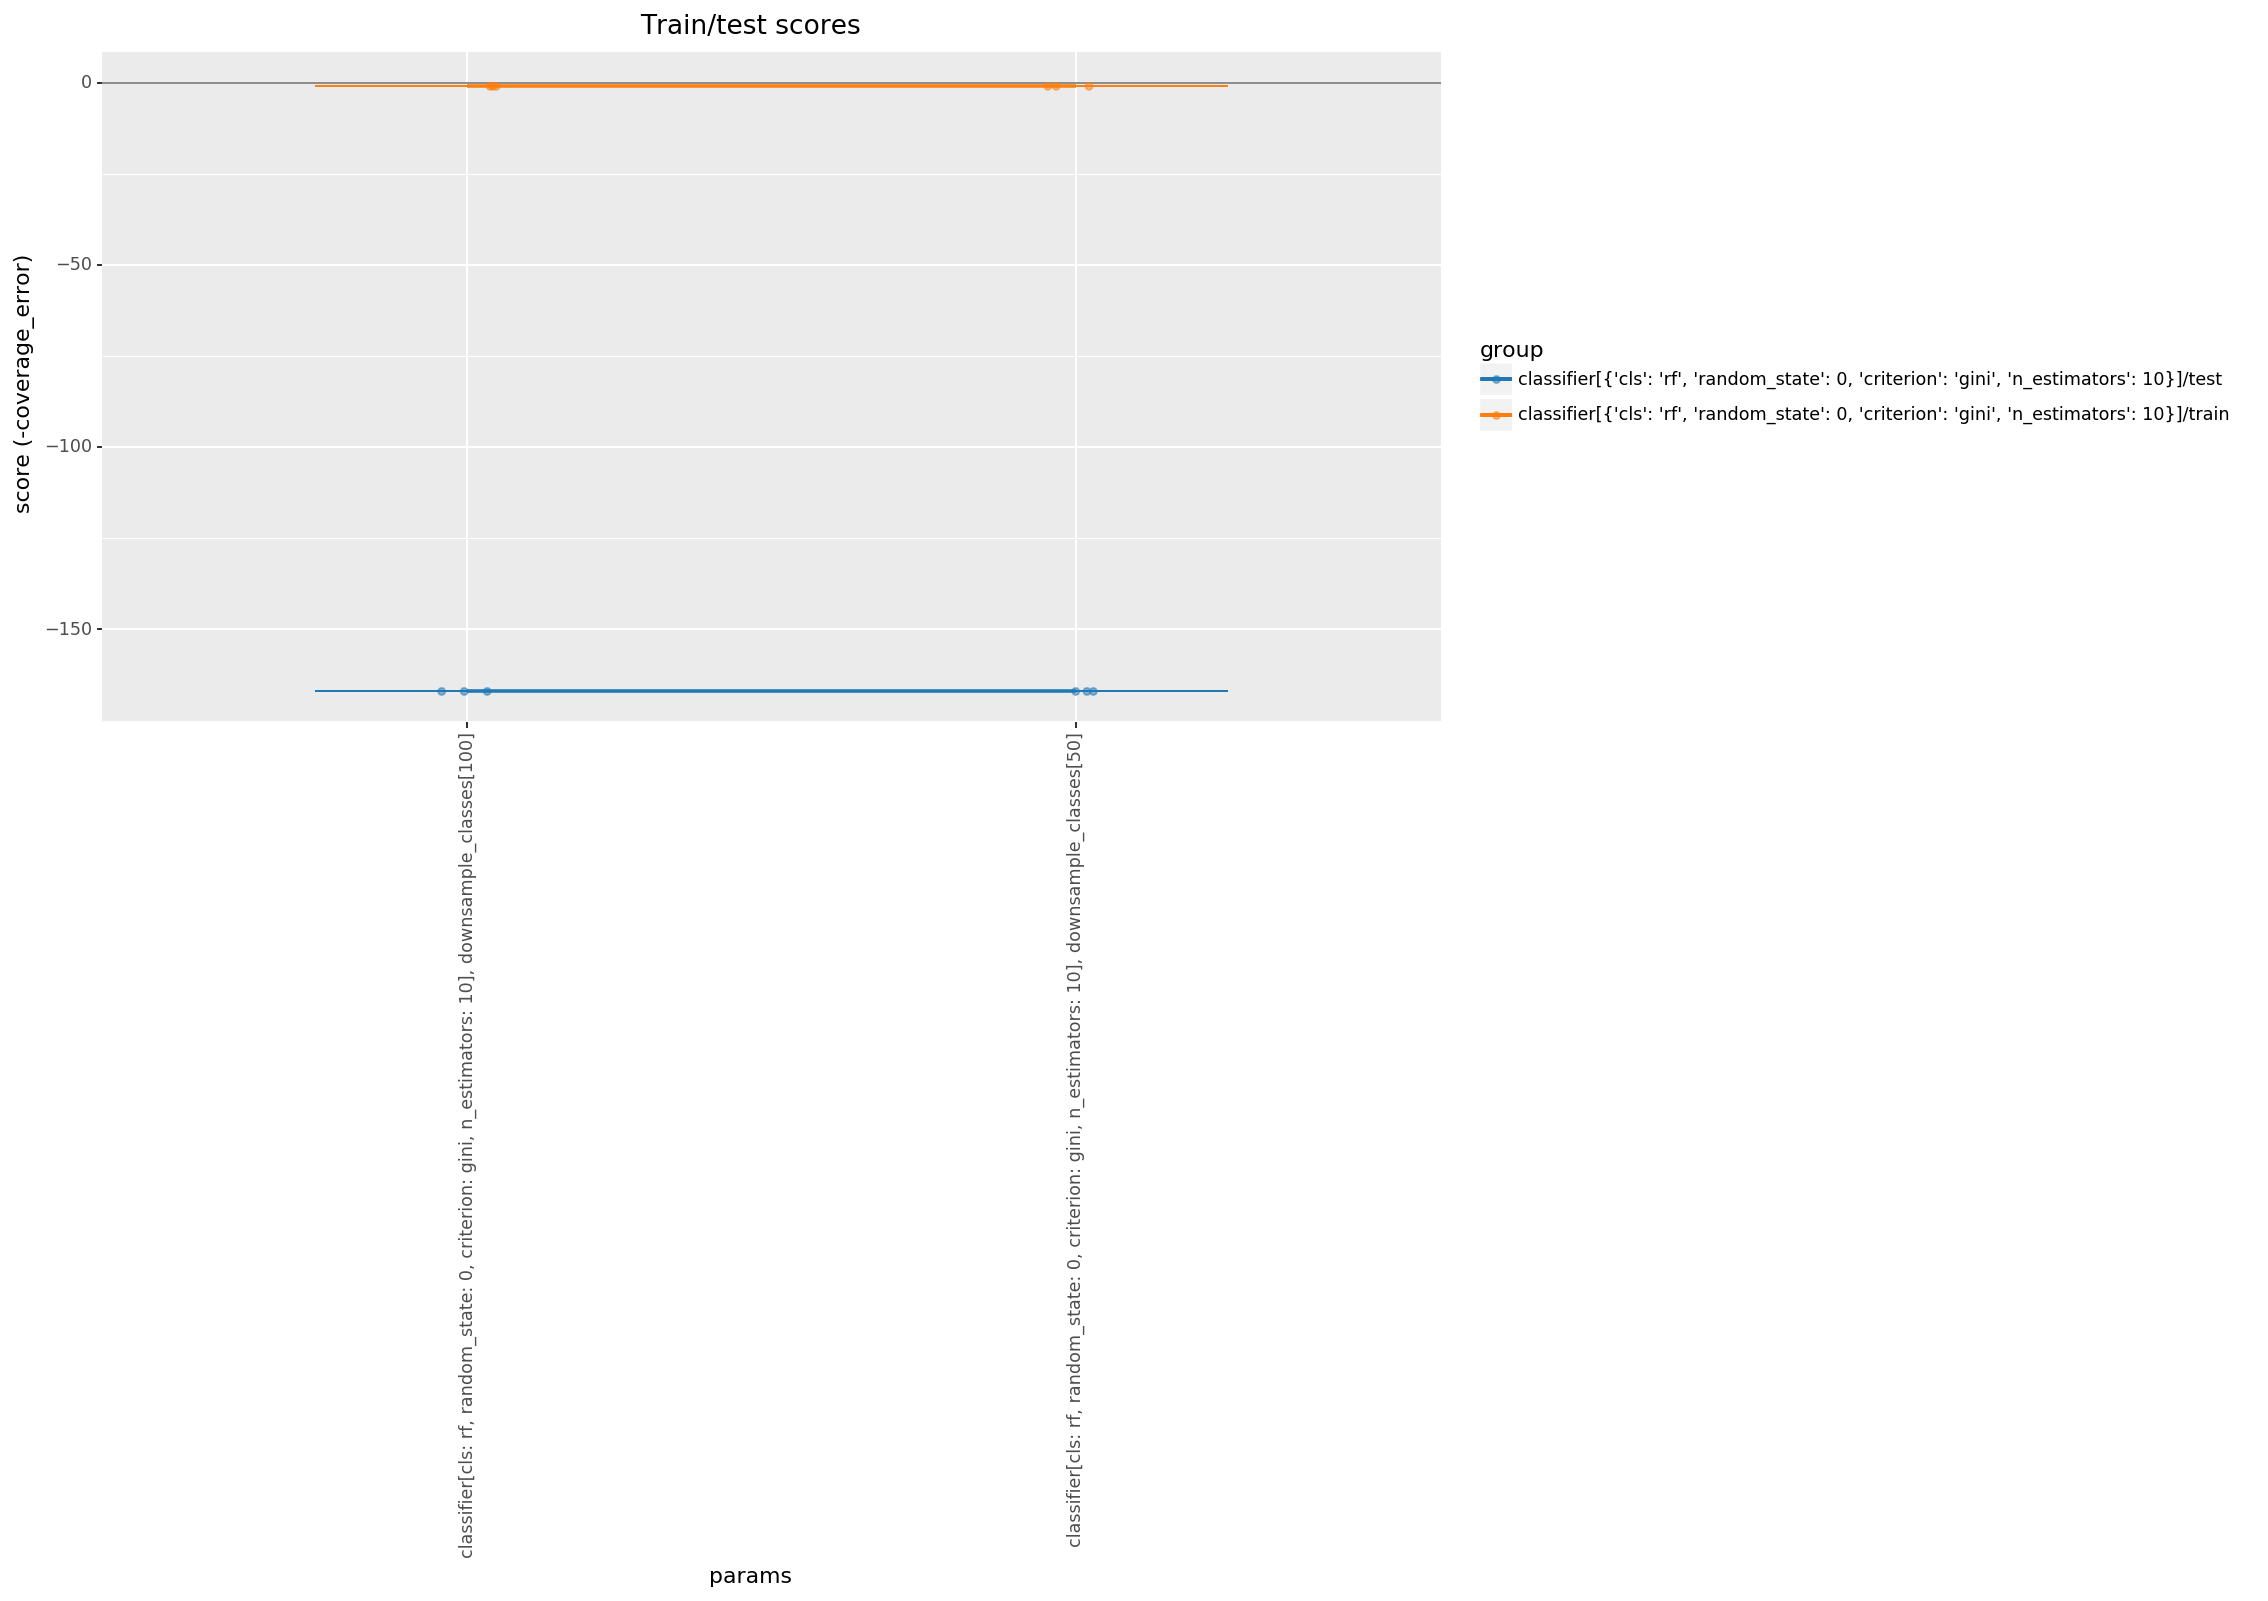

<ggplot: (-9223372036522486482)>

In [ ]:
# Train/test scores
#   - Grain: models x {train,test}
#   - Metrics: score
#   - Dims: group, params
(cv_models
    .pipe(lambda df: pd.melt(
        df,
        id_vars=['classifier_type', 'params', 'fold'],
        value_vars=['train_score', 'test_score'],
        var_name='split',
        value_name='score'),
    )
    .assign(
        split=lambda df: df.split.str.replace('_score', ''),
        group=lambda df: df.apply(axis=1, func=lambda row: row.classifier_type + '/' + row.split),
    )
    .pipe(df_ordered_cat, params=lambda df: param_list)
    .pipe(ggplot, aes(x='params', y='score', color='group'))
    + geom_hline(yintercept=0, color='grey')
    + geom_jitter(alpha=.5, width=.05, height=1e-9)
    # + geom_point(alpha=.5)
    + geom_line(aes(group='group + str(fold)'), alpha=.2)
    + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='errorbar')
    + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='line', size=1)
    + scale_color_cmap_d(mpl.cm.tab10)
    + theme(axis_text_x=element_text(angle=90, hjust=.5))
    + theme_figsize(width=12, aspect_ratio=1/2)
    # + coord_cartesian(ylim=(-35, 0))
    + ylab('score (-coverage_error)')
    + ggtitle('Train/test scores')
)

# Model diagnostics: all models, all folds

In [ ]:
print('models:')
print('  params[*/%s]' % len(param_list))
print('  fold[*/%s]' % cv.cv.n_splits)

models:
  params[*/2]
  fold[*/3]


In [ ]:
# TODO Cache
# Coverage errors: all models, all folds
#   - Subset: all models
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_all_all = (cv_models
    # .sample(n=5, random_state=0)  # For faster dev
    .pipe(lambda df: DF(
        OrderedDict(
            # **row[['model_id', 'params', 'fold']],  # Slow (in this inner loop), unpack manually instead
            model_id=row.model_id,
            params=row.params,
            classifier_type=row.classifier_type,
            fold=row.fold,
            i=i,
            y_true=y_true,
            coverage_error=coverage_error,
        )
        for row in iter_progress(df_rows(df), n=len(df))
        for i, y_true, coverage_error in zip(
            row.test_evals.i,
            row.test_evals.y,
            row.test_evals.coverage_errors(),
        )
    ))
)
display(
    df_summary(coverage_errors_all_all).T,
    coverage_errors_all_all[:10],
)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

 17%|██████████████                                                                      | 1/6 [00:00<00:01,  3.57it/s]

 33%|████████████████████████████                                                        | 2/6 [00:00<00:01,  3.37it/s]

 50%|██████████████████████████████████████████                                          | 3/6 [00:00<00:00,  3.55it/s]

 67%|████████████████████████████████████████████████████████                            | 4/6 [00:01<00:00,  3.61it/s]

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:01<00:00,  3.70it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.75it/s]

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
model_id,object,1938087,3834,3834,6,NaN,NaN,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[1]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[2]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[1]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[2]"
params,object,1788561,3834,3834,2,NaN,NaN,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]"
classifier_type,object,1612836,3834,3834,1,NaN,NaN,"classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]"
fold,int64,102240,3834,3834,3,NaN,NaN,0,0,1,2,2
i,int64,107352,3834,3834,1551,NaN,NaN,3,791,1590,2392,3188
y_true,object,325902,3834,3834,166,NaN,NaN,ABTO,CATH,KILL,RNPH,yecpar
coverage_error,float64,92016,3834,3834,11,NaN,NaN,1,9,167,167,167


,model_id,params,classifier_type,fold,i,y_true,coverage_error
0,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,2963,NOCA,167.0
1,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,2688,BTSP,167.0
2,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,1442,WEWP,10.0
3,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,915,COGD,10.0
4,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,2355,SATH,167.0
5,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,2920,SUTA,167.0
6,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,2740,WTSP,167.0
7,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,3142,PUFI,167.0
8,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,96,GWTE,167.0
9,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,2878,GTTO,167.0


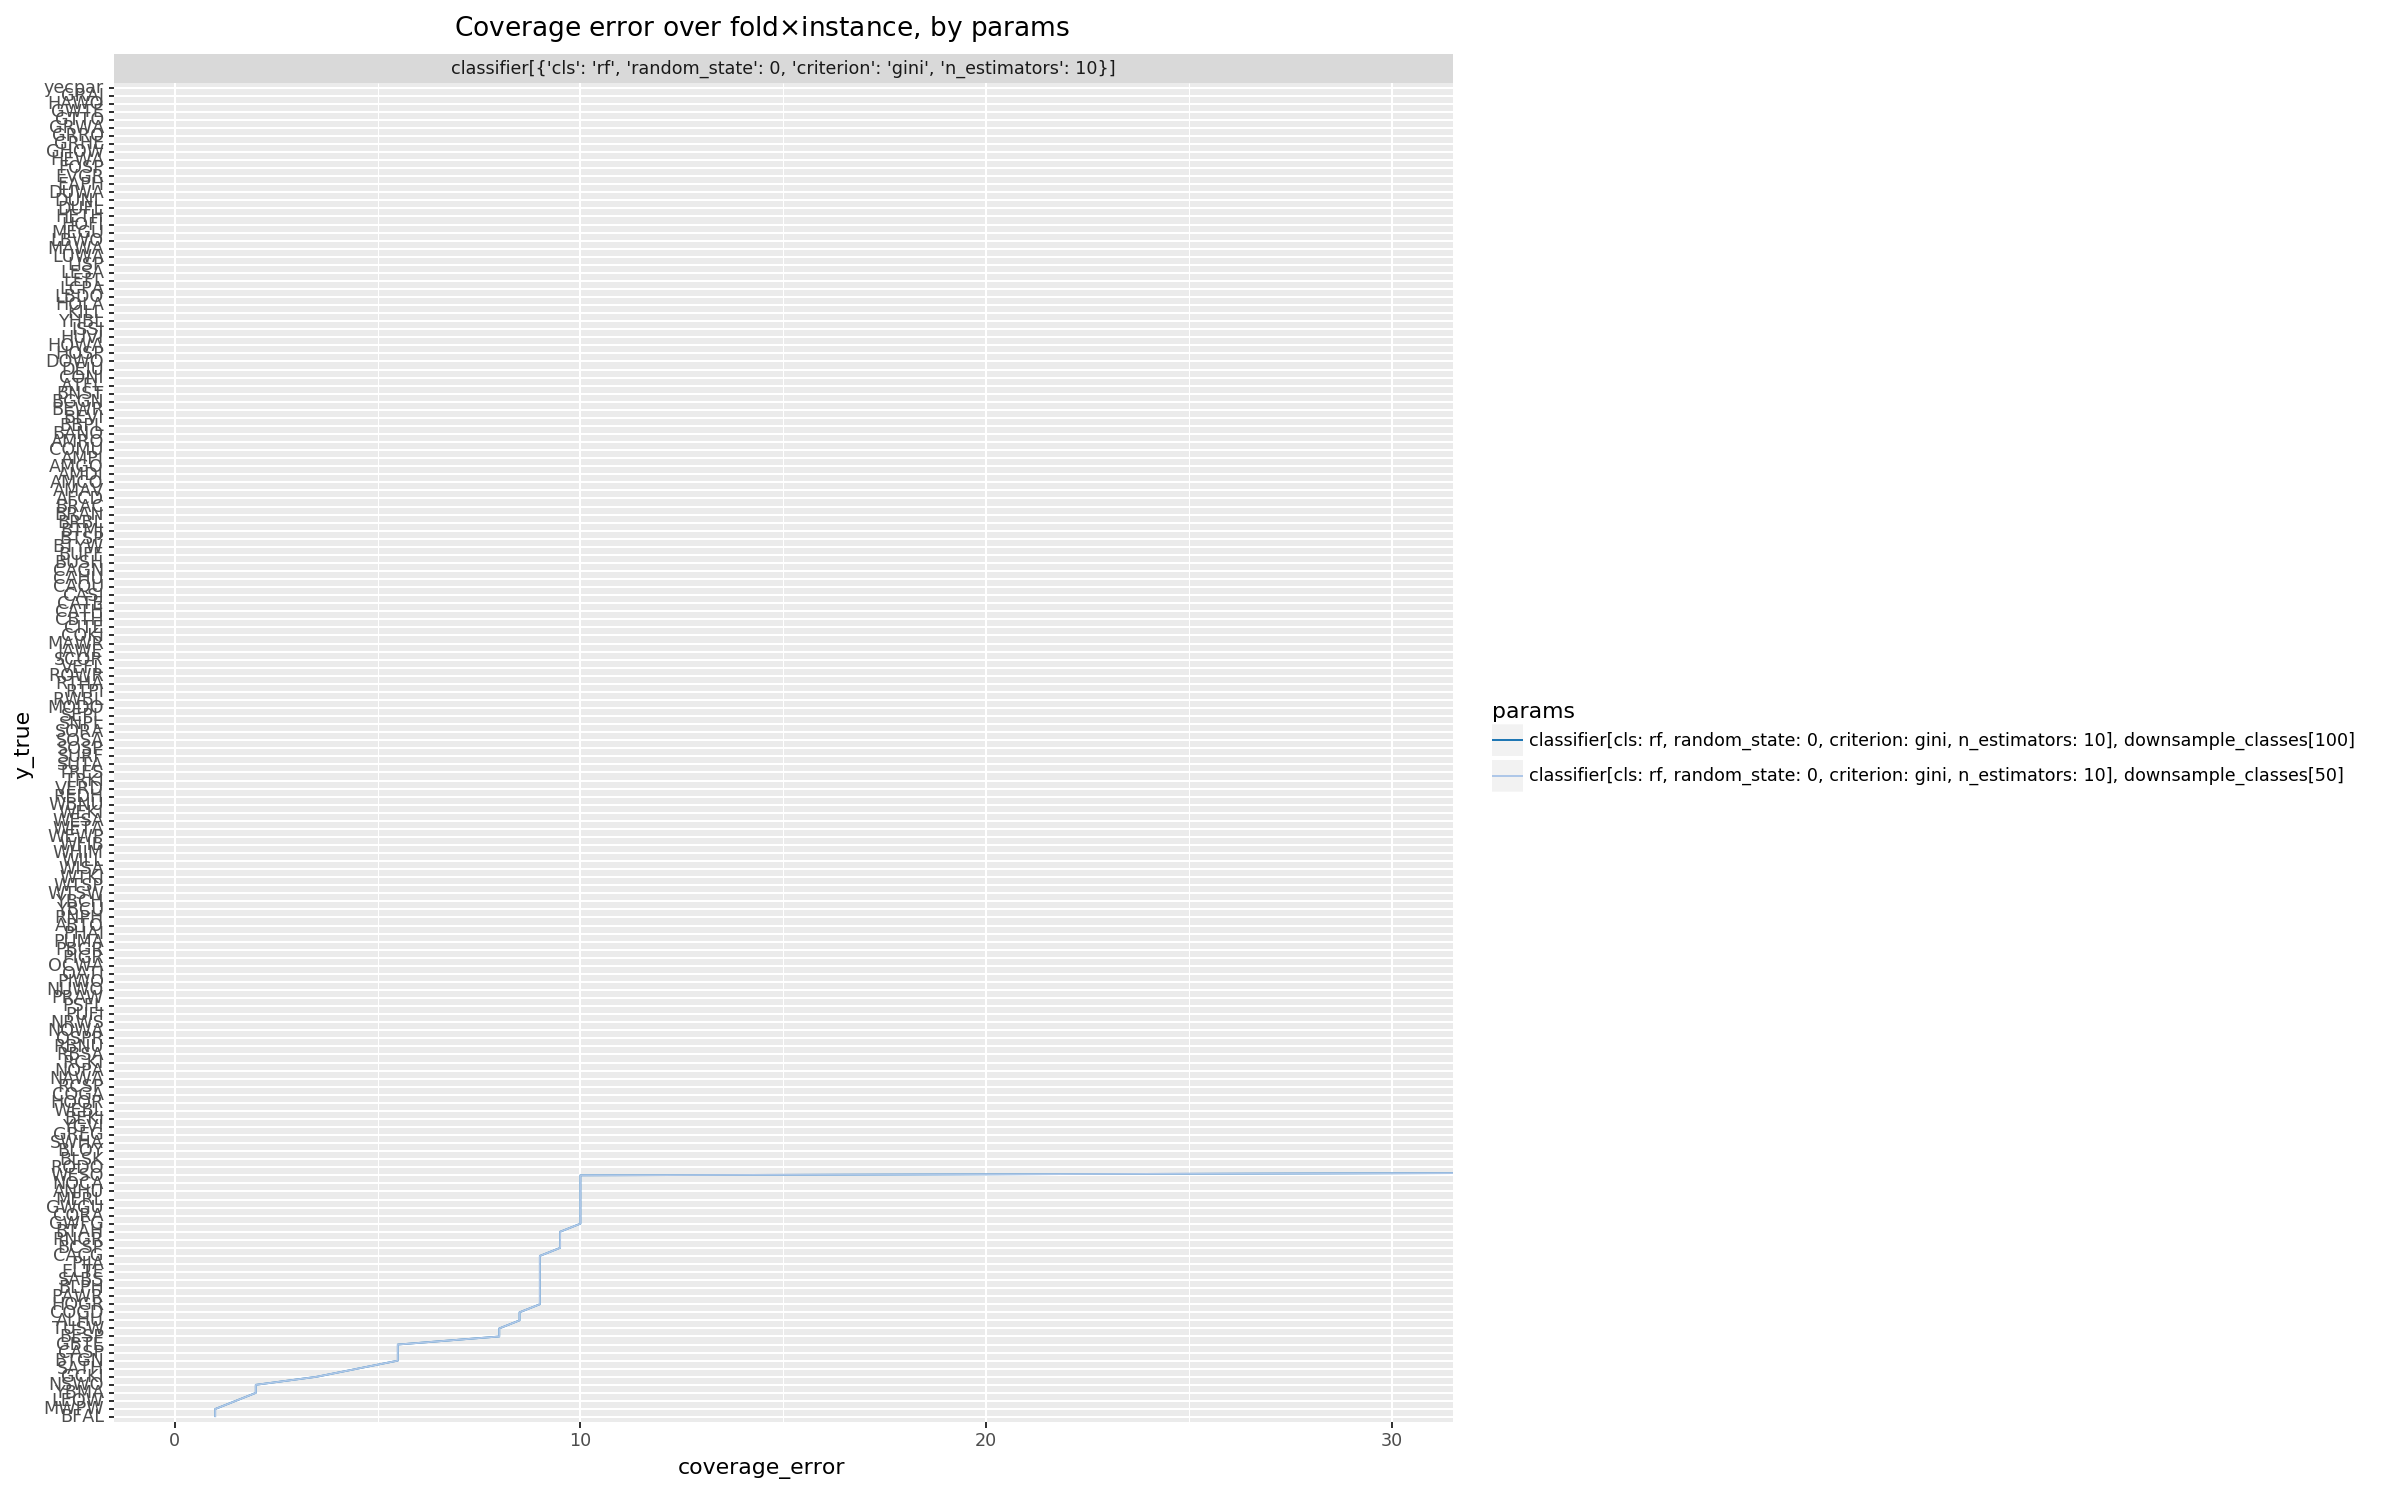

<ggplot: (317327922)>

In [ ]:
# Facet by classifier_type, order by median(coverage_error)
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
(coverage_errors_all_all
    # Sort species by median(coverage_error) (across all models)
    .pipe(df_ordered_cat, y_true=lambda df: (
        df.groupby('y_true').agg({'coverage_error': np.median}).reset_index().sort_values('coverage_error').y_true
    ))
    .pipe(ggplot, aes(x='y_true', y='coverage_error', color='params'))
    + facet_wrap('classifier_type')
    + geom_line(aes(group='params'), stat='summary', fun_y=np.median)
    + coord_flip(ylim=(0, min(30, len(np.unique(y)))))
    + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + scale_color_cmap_d(mpl.cm.tab20)
    + theme_figsize('square')
    # + theme_figsize('full')
    # + theme_figsize('full_dense')
    + ggtitle(rf'Coverage error over fold$\times$instance, by params')
)

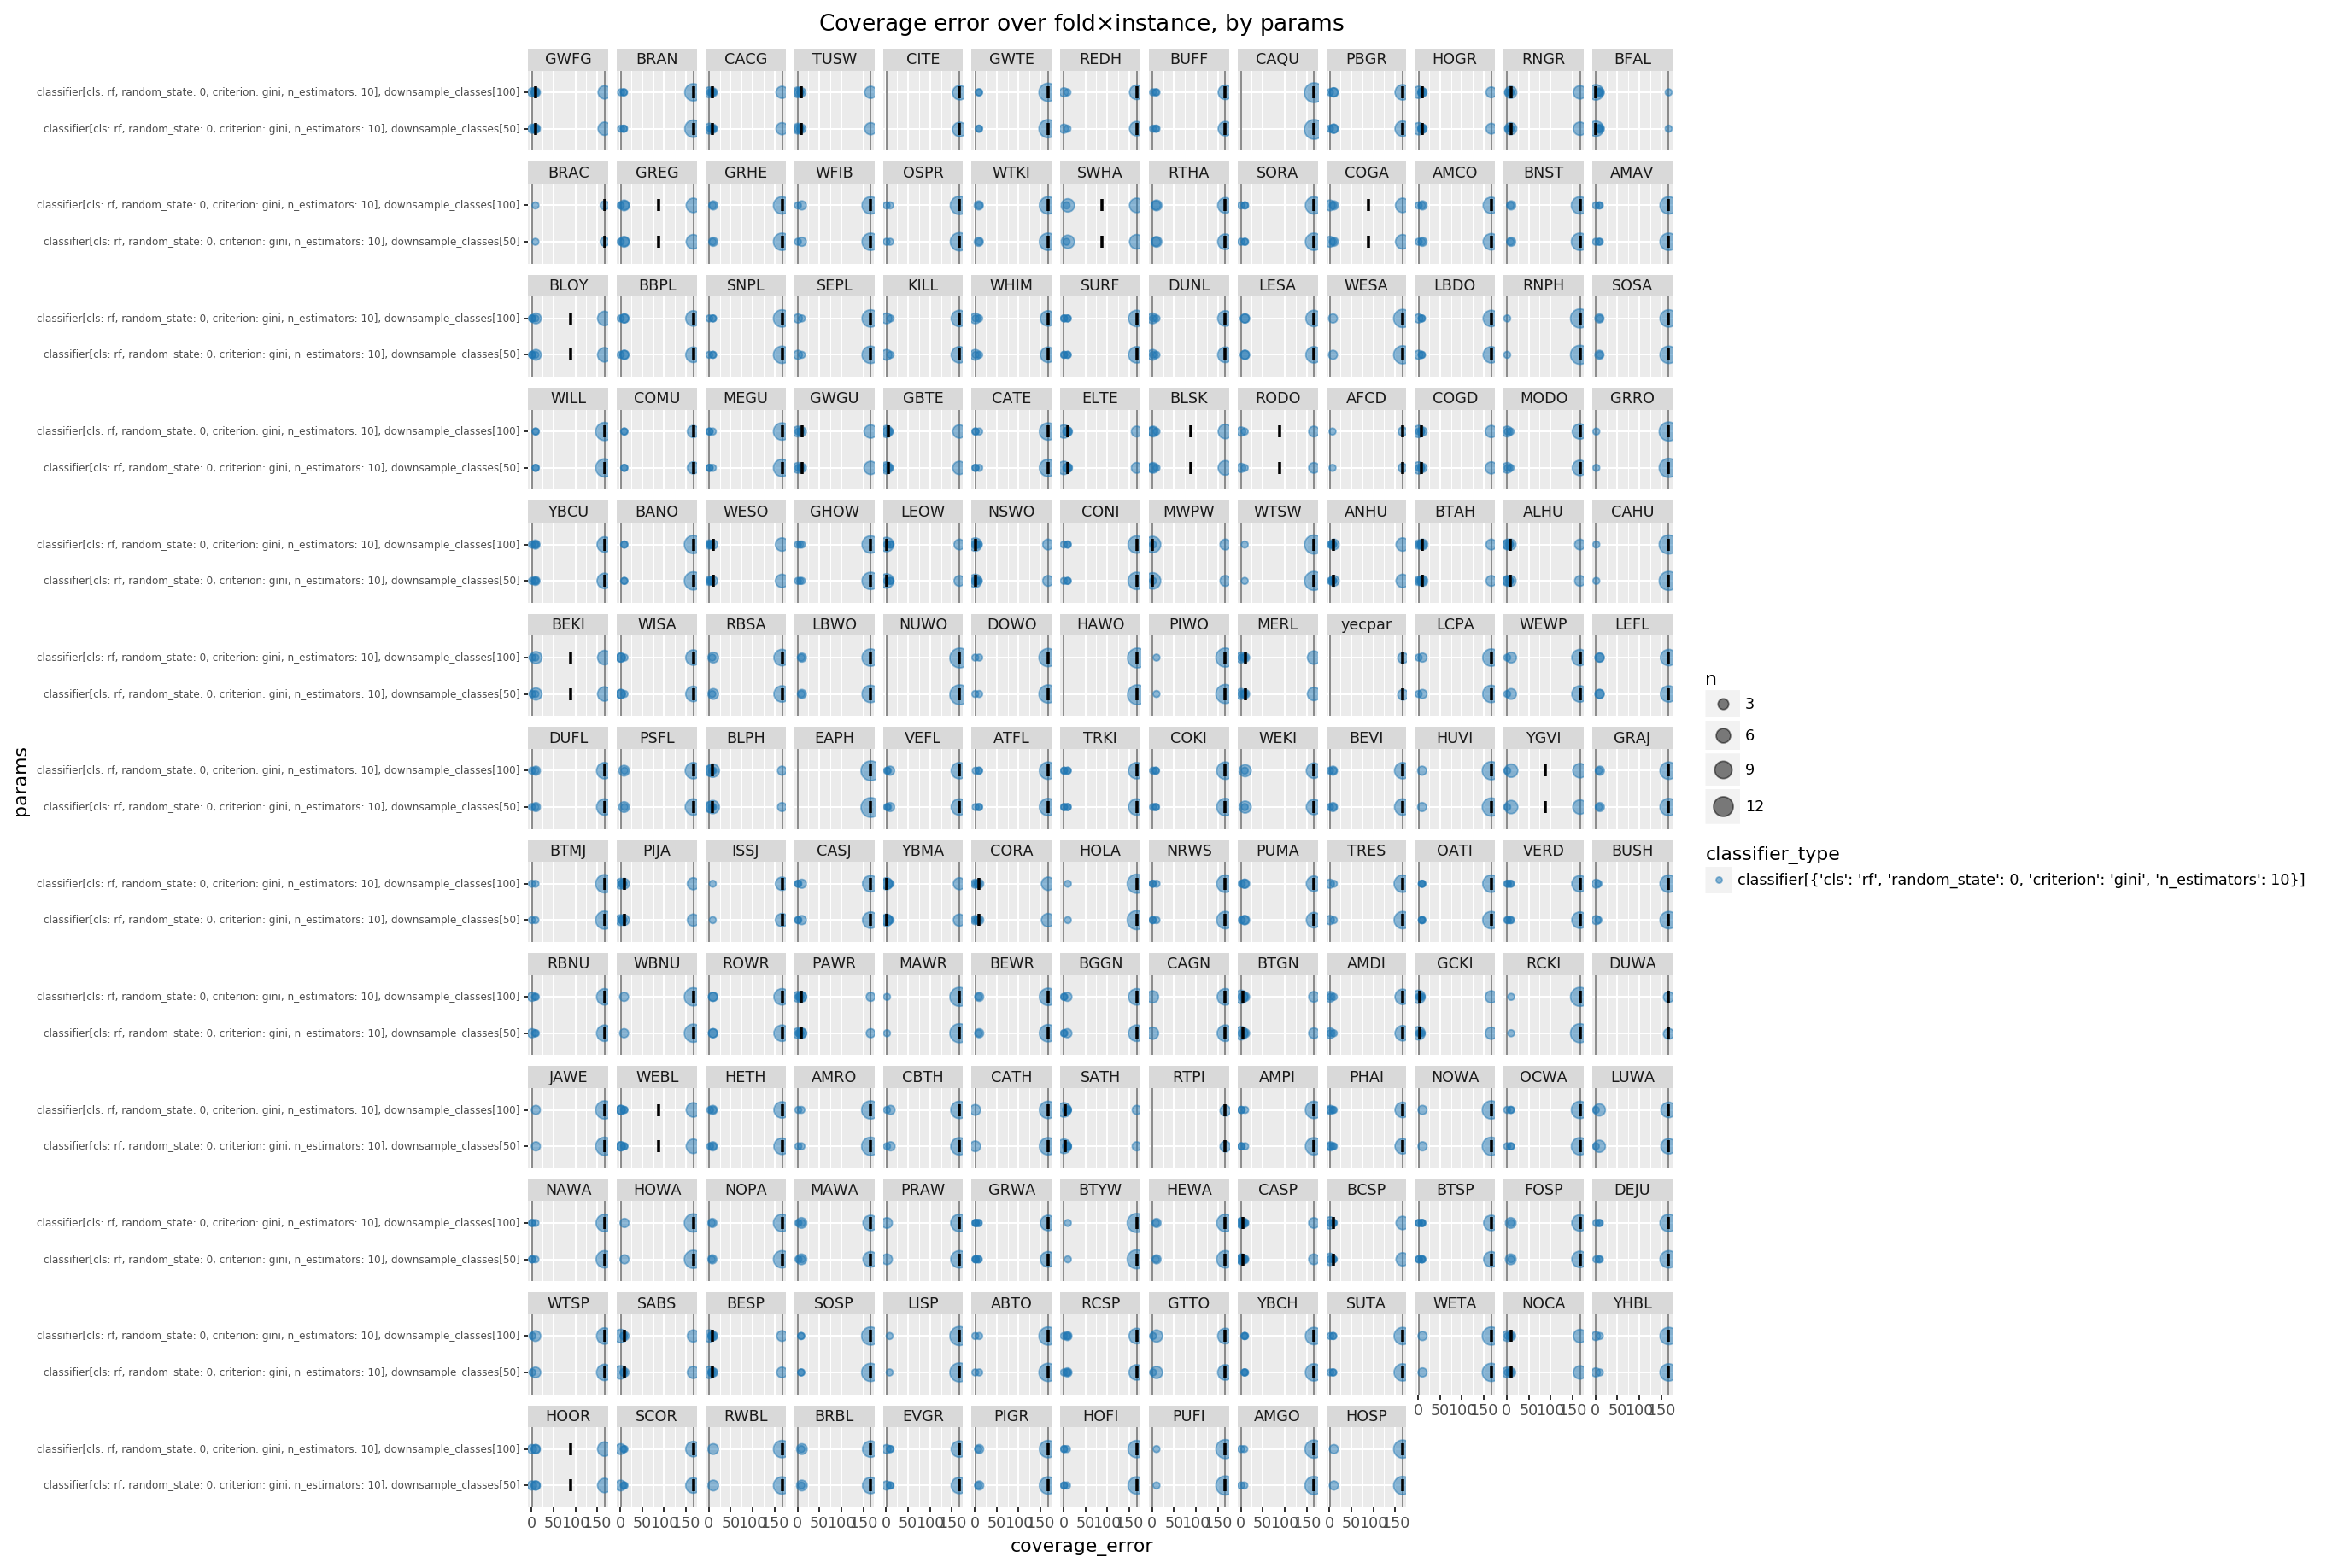

<ggplot: (286113533)>

In [ ]:
# TODO Slow, bad for notebook dev loop -- move lower, or disable by default?
# Facet by species
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
(coverage_errors_all_all
    # .sample(200, random_state=0)  # Faster dev
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_ordered_cat, params=lambda df: reversed(param_list))
    .pipe(ggplot, aes(x='params', y='coverage_error', color='classifier_type'))
    + facet_wrap('y_true')
    + geom_hline(yintercept=1, color='grey')
    + geom_hline(yintercept=recs.species.nunique(), color='grey')

    # Percentiles (faster, no overplot)
    # + geom_point(stat='summary', fun_y=np.median)
    # + geom_linerange(stat='summary', fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75))

    # Violin (slow, no overplot)
    # + geom_violin()

    # Boxplot (very slow, no overplot)
    # + geom_boxplot()

    # Points (medium cost, high overplot)
    #   - n (count) instead of prop (proportion)
    #   - scale_size_area() instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_count(aes(size='..n..'), alpha=.5)
    + scale_size_area()
    + geom_point(stat='summary', fun_y=np.median, alpha=1, color='black', shape='|', size=3, stroke=1)

    + coord_flip()
    + scale_color_cmap_d(mpl.cm.tab20)
    + theme(axis_text_y=element_text(size=6))
    + theme_figsize('square')  # Faster
    # + theme_figsize('half')
    # + theme_figsize('full')
    # + theme_figsize('full_dense')
    + ggtitle(rf'Coverage error over fold$\times$instance, by params')
)

# Model diagnostics: one model, all folds

In [ ]:
params_i = -1
params = param_list[params_i]
print("param_list:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(param_list)))
print()
print('models:')
print('  params[%s/%s]: %r' % (params_i, len(param_list), params))
print('  fold[*/%s]' % cv.cv.n_splits)

param_list:
  0: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]'
  1: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]'

models:
  params[-1/2]: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]'
  fold[*/3]


In [ ]:
# Coverage errors: one model, all folds
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_one_all = (coverage_errors_all_all
    [lambda df: df.params == params]  # One model, all folds
)
display(
    df_summary(coverage_errors_one_all).T,
    coverage_errors_one_all[:10],
)

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
model_id,object,1098441,1917,1917,3,NaN,NaN,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[1]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[2]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[2]"
params,object,766800,1917,1917,1,NaN,NaN,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]"
classifier_type,object,916326,1917,1917,1,NaN,NaN,"classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]"
fold,int64,51120,1917,1917,3,NaN,NaN,0,0,1,2,2
i,int64,53676,1917,1917,1551,NaN,NaN,3,791,1590,2392,3188
y_true,object,163031,1917,1917,166,NaN,NaN,ABTO,CATH,KILL,RNPH,yecpar
coverage_error,float64,46008,1917,1917,11,NaN,NaN,1,9,167,167,167


,model_id,params,classifier_type,fold,i,y_true,coverage_error
1917,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,2963,NOCA,167.0
1918,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,2688,BTSP,167.0
1919,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,1442,WEWP,10.0
1920,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,915,COGD,10.0
1921,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,2355,SATH,167.0
1922,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,2920,SUTA,167.0
1923,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,2740,WTSP,167.0
1924,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,3142,PUFI,167.0
1925,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,96,GWTE,167.0
1926,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,2878,GTTO,167.0


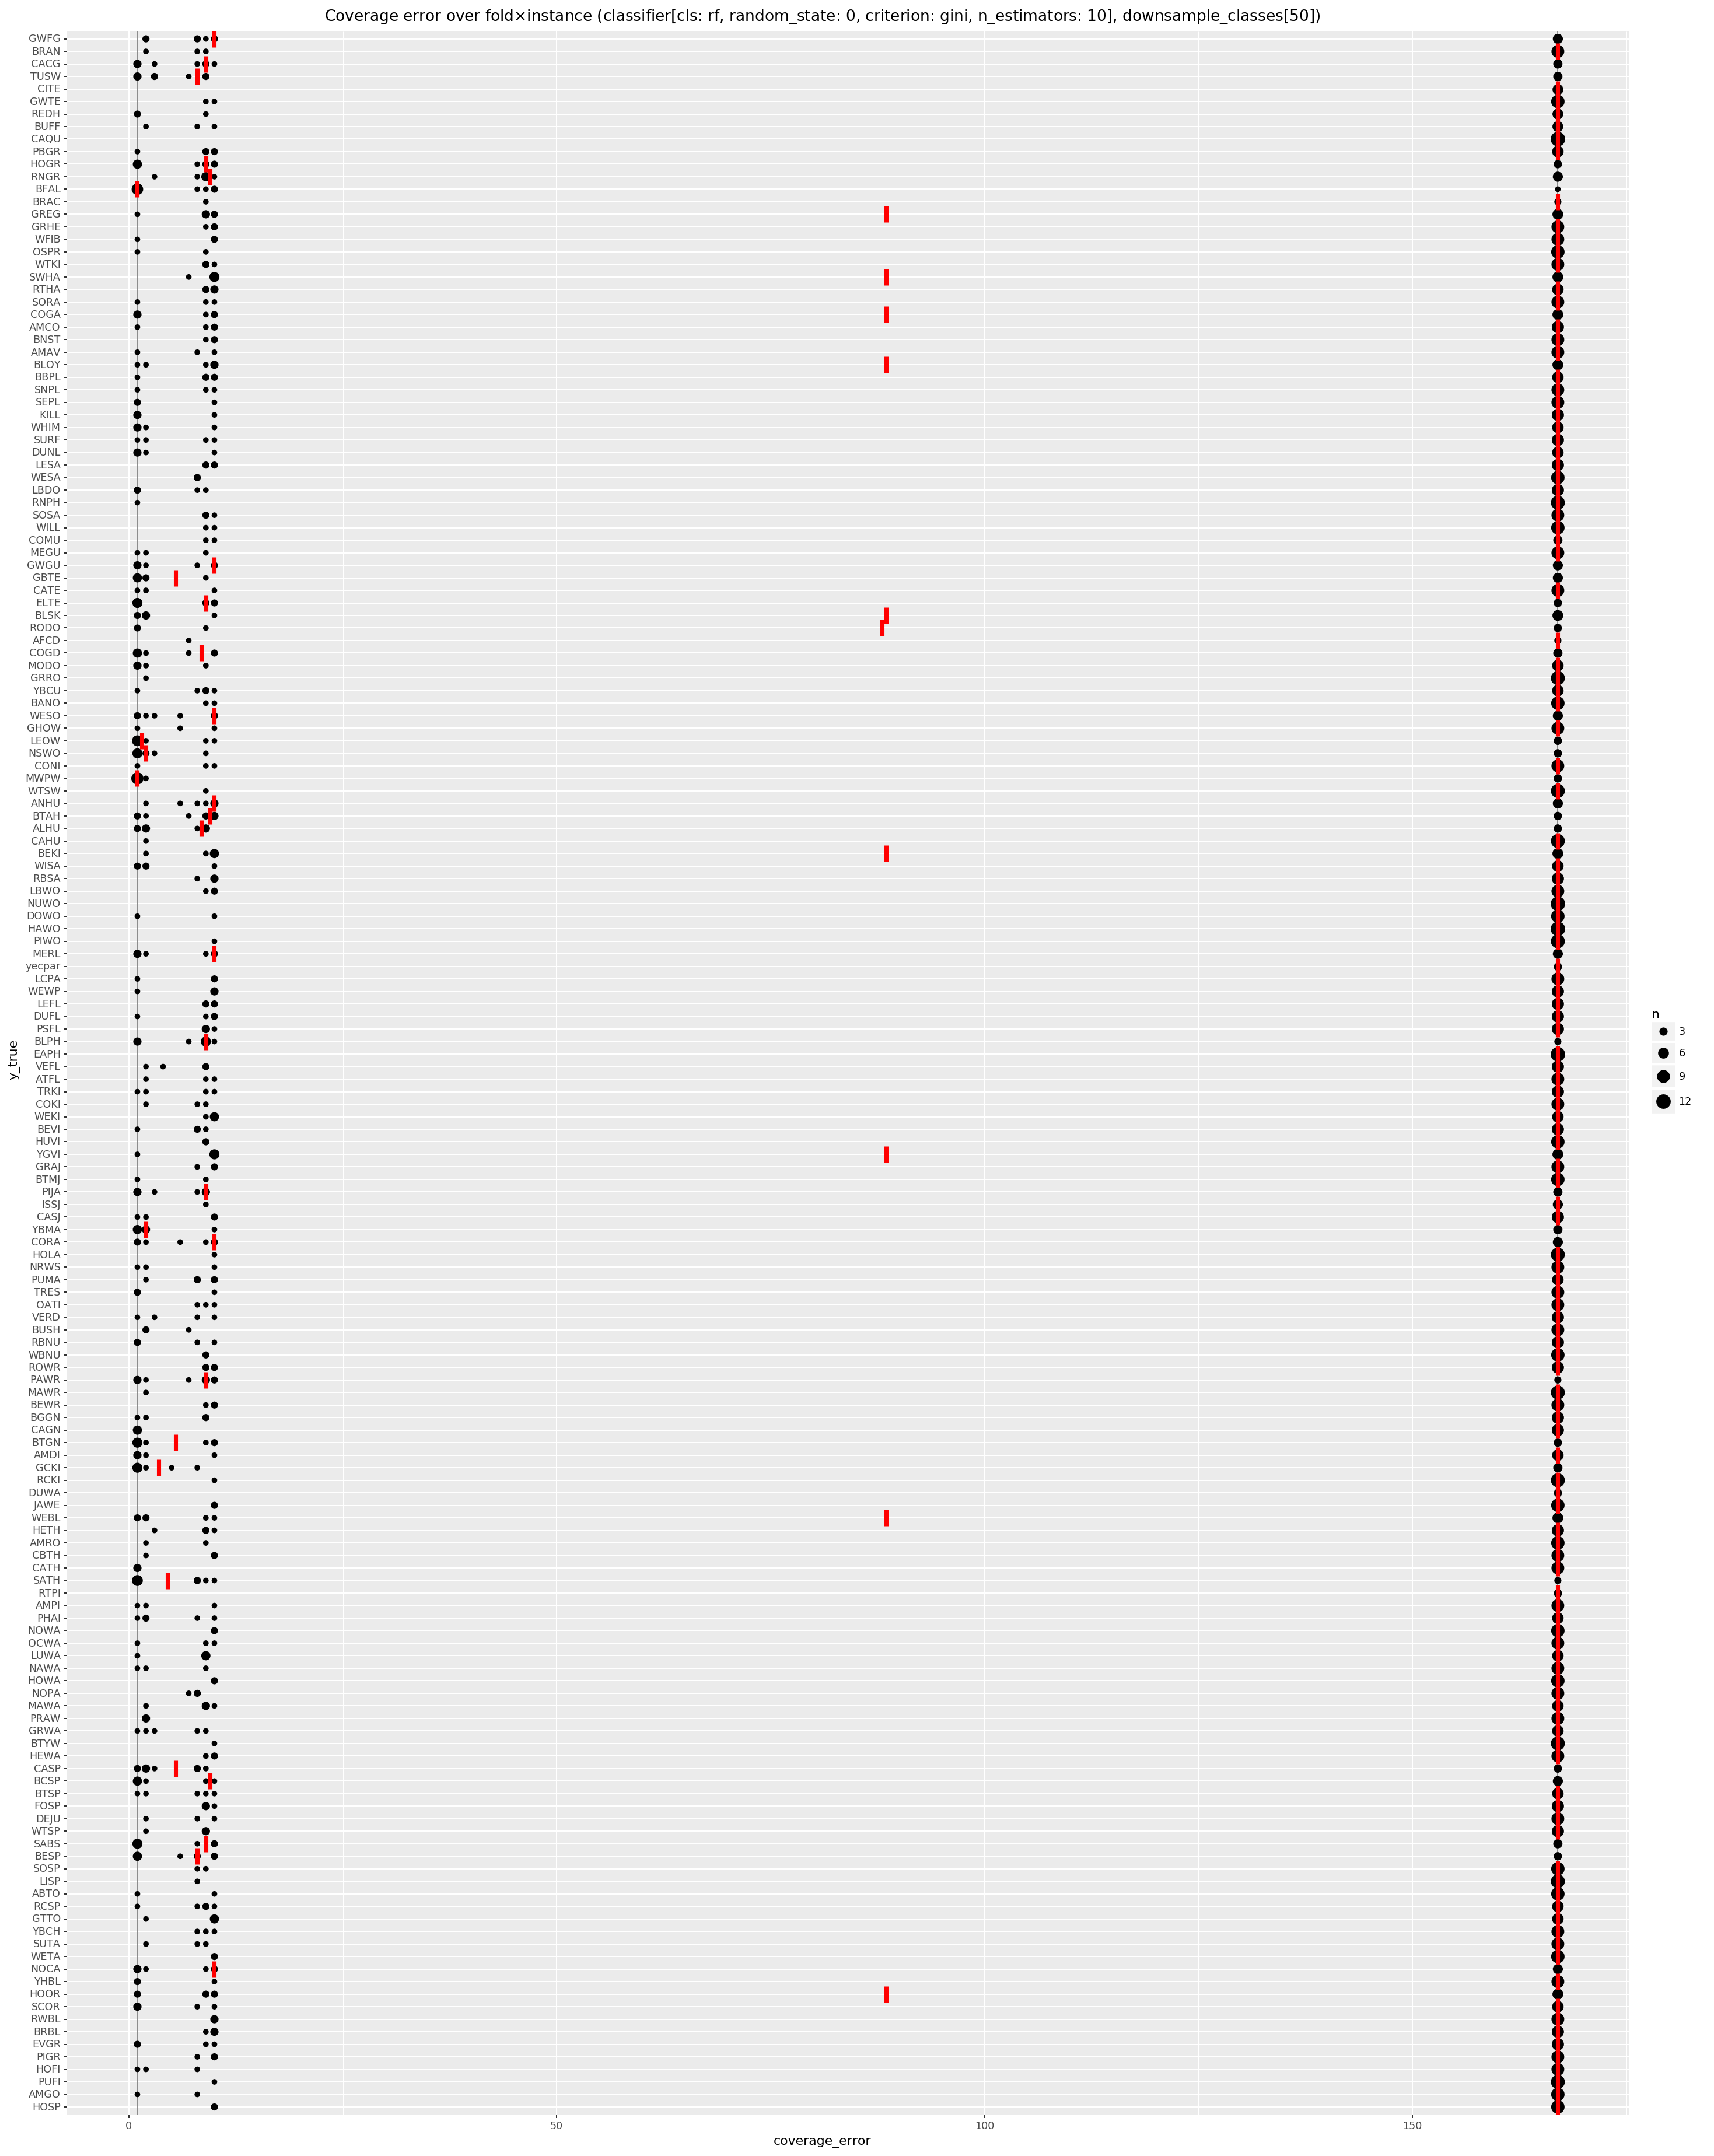

<ggplot: (-9223372036526848782)>

In [ ]:
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i].groupby(y_true) for model)
#       - Over: fold, rec_id
#   - Dims: y_true
#   - Metrics: count, coverage_error.percentiles
# in: coverage_errors_one_all, recs
(coverage_errors_one_all
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_reverse_cat, 'y_true')
    .pipe(ggplot, aes(x='y_true', y='coverage_error'))
    + geom_hline(yintercept=1, color='grey')
    + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + geom_count(aes(size='..n..'), alpha=1)  # n (count) instead of prop (proportion)
    + scale_size_area()  # Instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_point(stat='summary', fun_y=np.median, alpha=1, color='red', shape='|', size=6, stroke=2)
    + coord_flip()
    # + theme_figsize('inline')
    # + theme_figsize('square')
    # + theme_figsize('half')
    + theme_figsize('half_dense')
    # + theme_figsize('full')
    # + theme_figsize('full_dense')
    + ggtitle(rf'Coverage error over fold$\times$instance ({params})')
)

/Users/danb/hack/bubo/features/viz.py:195: RuntimeWarning: invalid value encountered in true_divide
  M = M.astype('float') / M.sum(axis=1)[:, np.newaxis]


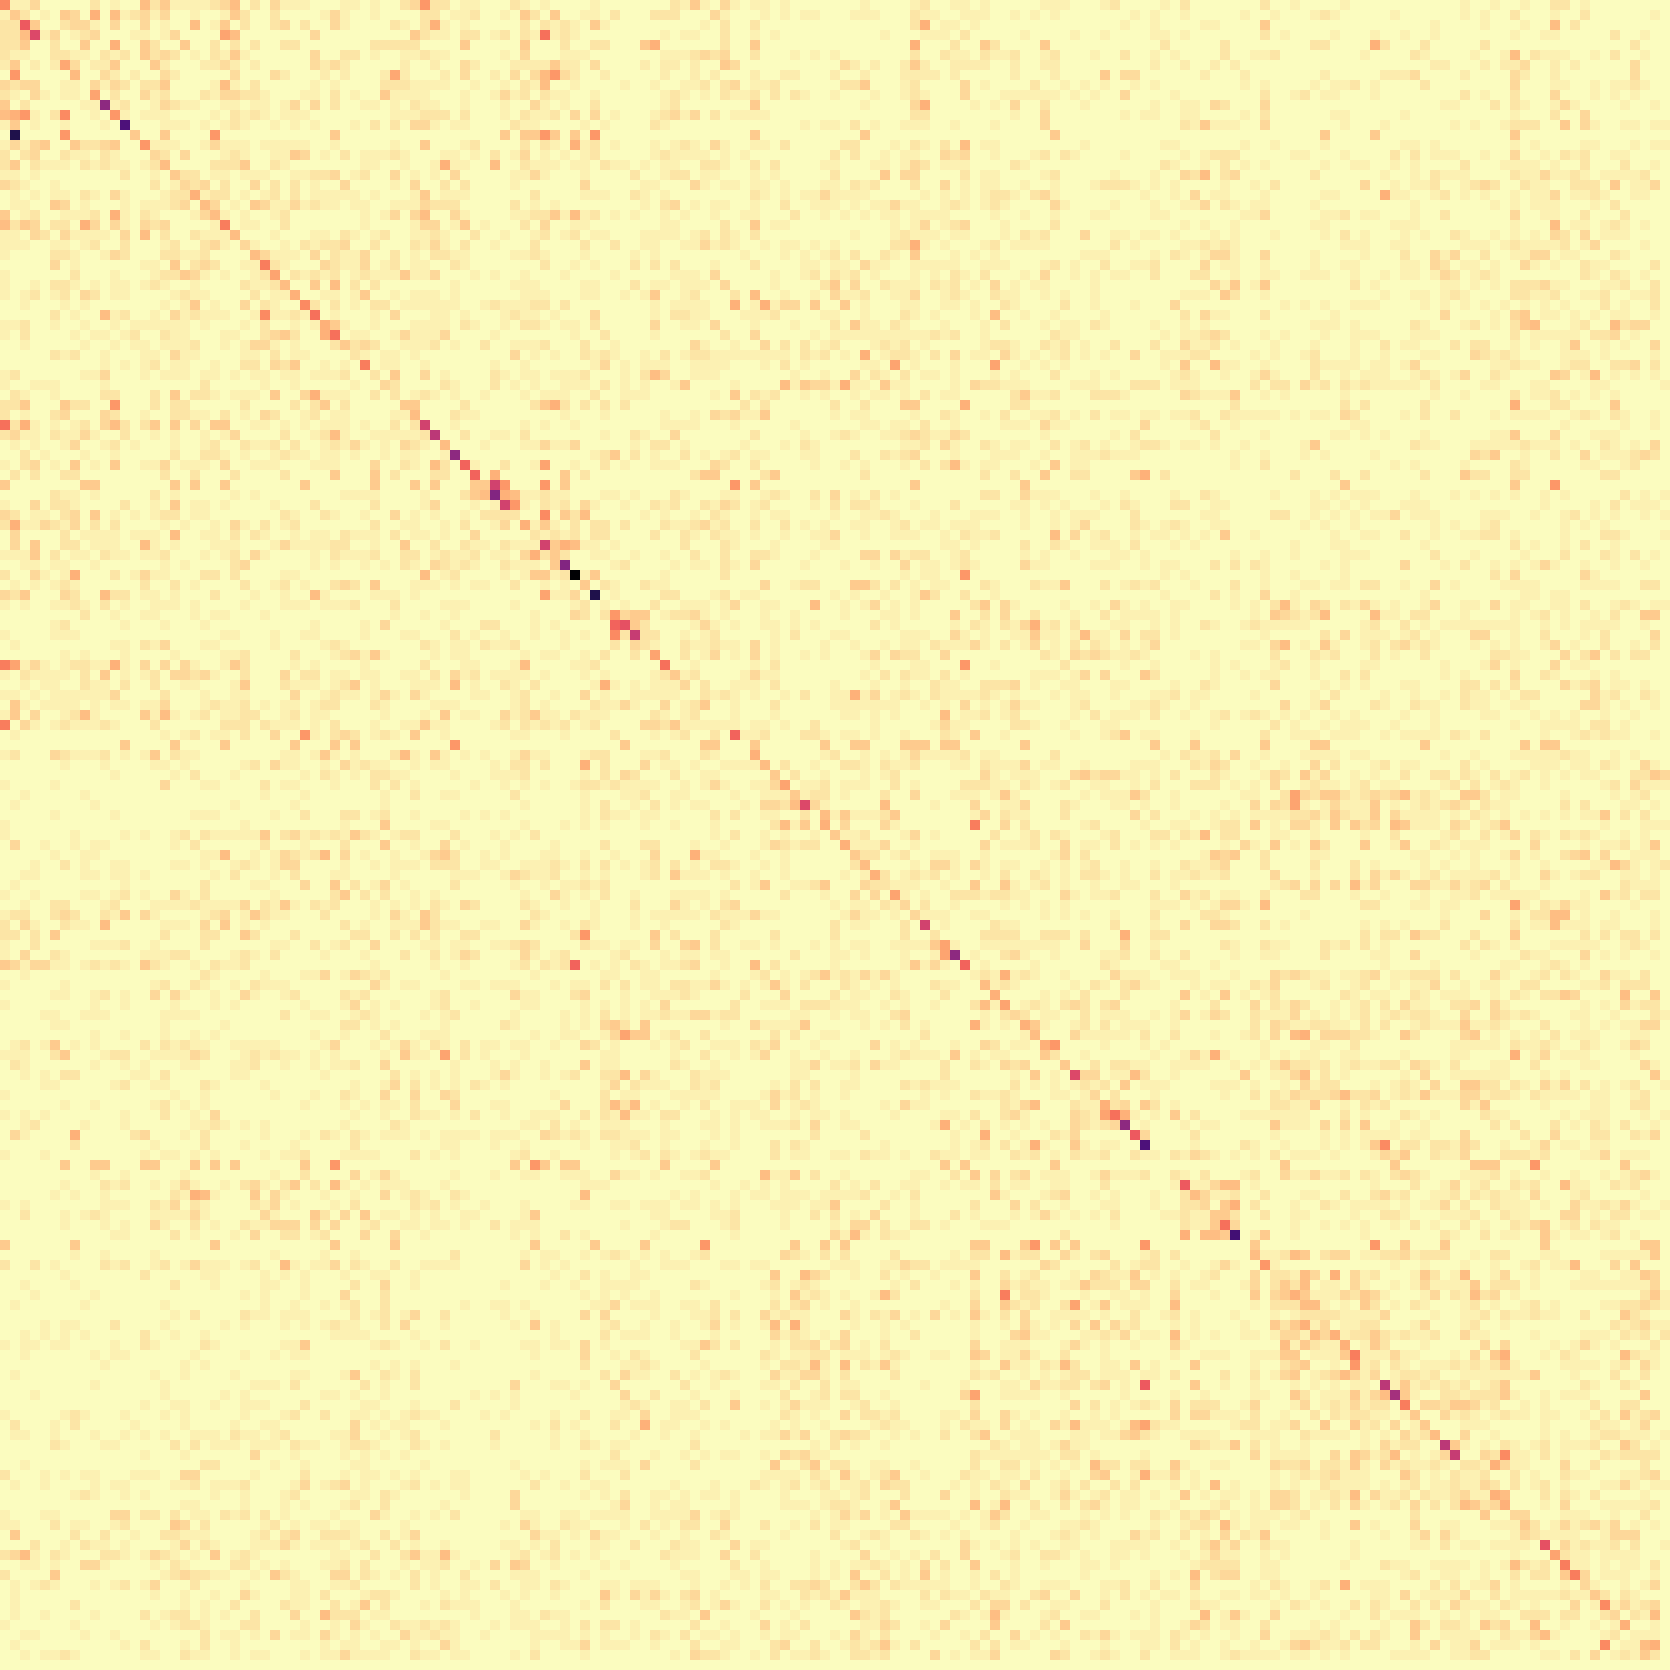

In [ ]:
# One-model/all-folds confusion matrix
with figsize(
    # 'square',
    # 'full',
    'full_dense',
):
    (cv_models
        [lambda df: df.params == params]
        .pipe(lambda df: plot_confusion_matrix(
            classes=df.iloc[0].test_evals.classes,
            M=np.array([
                row.test_evals.confusion_matrix_prob()
                for row in df_rows(df)
            ]).sum(axis=0),
            # normalize=False,  # For counts
            raw=True, scale=10,  # Faster dev
            format=None,  # Omit numbers, too dense
        ))
    )

# Model diagnostics: one model, one fold

In [ ]:
fold = 0
# params_i = ...  # Comment out to reuse from above
params = param_list[params_i]
[(_, model)] = list(cv_models[lambda df: (df.params == params) & (df.fold == fold)].iterrows())
print("param_list:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(param_list)))
print()
print('model:')
print('  params[%s/%s]: %r' % (params_i, len(param_list), model.params))
print('  fold[%s/%s]' % (model.fold, cv.cv.n_splits))
print()
print(model)

param_list:
  0: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]'
  1: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]'

model:
  params[-1/2]: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]'
  fold[0/3]

model_id                      classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]
params                                 classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]
params_dict        {'classifier': {'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}, 'downsample_classes': 50}
classifier_type                                  classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]
fold                                                                                                      

In [ ]:
# in: model
model_id = model.model_id
params = model.params
fold = model.fold
# train_evals = model.train_evals
test_evals = model.test_evals

# in: model, recs
# train_recs = recs.iloc[train_evals.i]
# train_X = Search.X(recs)[train_evals.i]
# train_y = Search.y(recs)[train_evals.i]
test_recs = recs.iloc[test_evals.i]
test_X = Search.X(recs)[test_evals.i]
test_y = Search.y(recs)[test_evals.i]  # (Don't need to store cv_models.test_evals.y if we have recs -- which sometimes we don't?)

display(
    # len(train_recs),
    len(test_recs),
)

[skip]

In [ ]:
# TODO TODO Restore this plot like 'Coverage error over ...' above, so we can see _one_ model instead of aggregating over n_splits models
# # TODO Update [kill the .merge, then species -> y_true]
# (search.coverage_error_by(test_recs, 'id')
#     [:5]
#     # .merge(test_recs[['id', 'species']], on='id', how='left')
#     # .pipe(ggplot, aes(x='species', y='coverage_error'))
#     # + geom_count(aes(size='..n..'))
#     # + stat_summary(fun_y=np.median, geom='point', color='red', alpha=.5, shape='|', size=6, stroke=1)
#     # + stat_summary(
#     #     fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75),
#     #     geom='linerange', color='red', alpha=.5, size=1,
#     # )
#     # + coord_flip()
#     # + geom_hline(yintercept=len(search.classes_), color='grey')
#     # + scale_x_discrete(limits=list(reversed(test_recs.species.cat.categories)))
#     # + theme_figsize('square')
#     # + ggtitle(rf'Coverage error over instance ({model_id})')
# )

[skip]

In [ ]:
# One-model/one-fold confusion matrix
with figsize(
    'square',
    # 'full',
    # 'full_dense',
):
    plot_confusion_matrix_df(
        confusion_matrix_prob_df(model.test_evals.y, model.test_evals.y_scores, model.test_evals.classes),
        title=model.model_id,
        # normalize=False,  # For counts
        raw=True, scale=10,  # Faster dev
    )

[skip]